Choosing a good set of hyperparameters is one of most important steps but also pretty much annoying and time consuming. The small number of hyperparameters may allow you to find an optimal hyperparameters after a few trials. This is, however, not the case for complex models like neural network. 

Indeed, when I just started my career as a data scientist, I was always frustrated to tune hyperparameters of Neural Network not to either underfit or overfit. Everytime I spent a lot of times and winded up not finding good set of hyperparameters, I was like

![frustration](https://media.giphy.com/media/ilkfz8Mn5Yz7O/giphy.gif)

Actually there were a lot of ways to tune parameters efficiently and algorithmically, which I was ignorant of back in those days. Especially how to tune Neural Network has been progress rapidly in a recent few years by utilizing various algorithms: [spectral analysis [1]](https://arxiv.org/pdf/1706.00764.pdf), [bandit algorithms [2]](https://arxiv.org/pdf/1603.06560.pdf), [evolutionary strategy [3]](https://arxiv.org/pdf/1711.09846.pdf), [reinforcement learning [4]](https://arxiv.org/pdf/1611.01578.pdf), etc. How to build predictive general models algorithmically is also one of the hot research topics. Many frameworks and algorithms have been suggested [[5]](https://cyphe.rs/static/atm.pdf), [[6]](https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf).

Automatically building and tuning models is one of the hot topics in research, some of which are successful in outperforming state-of-art models. Thus, building solid tuning algorithms are way cheaper and more efficient than hiring data scientists for tuning models.

![scientist](https://media.giphy.com/media/xUA7b6oaRIgzmAKpUY/giphy.gif)

In this blog post, we will go through the most basic three algorithms: grid, random, and Bayesian search. And, we will learn how to implement it in python.

# Background
When optimizing hyperparameters, information available is mostly only score value of defined metrics(e.g., accuracy for classification) with each set of hyperparameters. We query a set of hyperparameters and get a score value as a response. Thus, optimization algorithms have to make efficient queries and find an optimal set without knowing how objective function looks like. This kind of optimization problem is called balck-box optimization. Here is the definition of black-box optimization:

> "Black Box" optimization refers to a problem setup in which an optimization algorithm is supposed to optimize (e.g., minimize) an objective function through a so-called black-box interface: the algorithm may query the value f(x) for a point x, but it does not obtain gradient information, and in particular it cannot make any assumptions on the analytic form of f (e.g., being linear or quadratic). We think of such an objective function as being wrapped in a black-box. The goal of optimization is to find an as good as possible value f(x) within a predefined time, often defined by the number of available queries to the black box. Problems of this type regularly appear in practice, e.g., when optimizing parameters of a model that is either in fact hidden in a black box (e.g., a third party software library) or just too complex to be modeled explicitly.

> by [Balck-Box Optimization Competition homepage](https://bbcomp.ini.rub.de/).

\* There are some hyperparameter optimization methods to make use of gradient information, e.g., [[7]](http://proceedings.mlr.press/v37/maclaurin15.pdf).

Grid, random, and Bayesian search, are three of basic algorithms of black-box optimization. They have the following characteristics (We assume the problem is minimization here):
 

### Grid Search
Grid search is the simplest method. First, we place finite number of points on each hyperparameter axis and then make grid points by combining them. Here is the example:
```python
A: (1e-8, 1e-6, 1e-4)
B: (0, 1)
(A, B): [(1e-8, 0), (1e-8, 1), (1e-6, 0) (1e-6, 1) (1e-4, 0) (1e-4, 1)]
```
When you have only a few hyperparameters, this method may works. Once dimension increases, the number of trials blows up exponentially.


### Random Search
Random search is known effective over high dimensional search space. Especially when we have small subsets of effective hyperparameters out of high dimensional space, we search these effective parameters effectively [[8]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).


### Bayesian search
While random search samples points independently, Bayesian search samples promising points more effectively by utilizing historical results. We first use GP (Gaussian process) to estimate objective function based on historical results [9](https://arxiv.org/pdf/1206.2944.pdf).

GP also outputs variance along with mean. If this variance is large, small mean does not necessary imply promising because high values also likely happen as well. Points minimizing mean of estimation function are not necessary optimal. Thus, we need to define metric to consider trade off between mean and variance. 

We introduce functions called acquisition function to deal with this issue. One of the most commonly used function is _Expected Improvement_. Here is the definition:
$$  a_{EI}(x; \{x_n,  y_n\}, \theta) = \left.E[max(f(x_{best}) - f(x), 0) \right| \{x_n,  y_n\}, \theta]$$
where $f(\cdot)$ is score function; $\{x_n,  y_n\}$ historical input and its response from score function; $\theta$ is parameters of Gaussian process; $E[\cdot]$ is taking expectation with respect to a Gaussian probability.


The right hand can be calculated analytically to the following form:
$$a_{EI}(x; \{x_n,  y_n\}, \theta) = \sigma(x ;  \{x_n,  y_n\}, \theta) [\gamma(x) \Phi(\gamma(x)) + N (\gamma(x); 0, 1)]$$
where
$$\gamma(x) = \frac{f(x_{best}) − \mu(x ; \{x_n,  y_n\}, \theta)}{\sigma(x ;  \{x_n,  y_n\}, \theta)}$$
$N(\cdot; 0, 1)$ and $\Phi(\cdot)$ are p.d.f. and c.d.f of Gaussian distribution, respectively.

Here is python code:
```python
import numpy as np

def expected_improvement(x, model, evaluated_loss, jitter=0.01):
    """ expected_improvement
    Expected improvement acquisition function.

    Note
    ----
    This implementation aims for minimization

    Parameters:
    ----------
    x: array-like, shape = (n_hyperparams,)
    model: GPRegressor object of GPy.
        Gaussian process trained on previously evaluated hyperparameters.
    evaluated_loss: array-like(float), shape = (# historical results,).
         the values of the loss function for the previously evaluated
         hyperparameters.
    jitter: float
        positive value to make the acquisition more explorative.
    """
    x = np.atleast_2d(x)
    mu, var = model.predict(x)
    # Consider 1d case
    sigma = np.sqrt(var)[0, 0]
    mu = mu[0, 0]
    # Avoid too small sigma
    if sigma == 0.:
        return 0.
    else:
        loss_optimum = np.min(evaluated_loss)
        gamma = (loss_optimum - mu - jitter) / sigma
        ei_val = sigma * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        return ei_val
```

Summing up the above discussion, Bayesian optimization is executed in the following steps:
1. Sample a few points and score them.
2. Initialize GP with sampled points
3. Sample points that minimize acquisition function
4. Score sampled points and store the results in GP
5. Iterate 3. and 4.

To implement them in python, I have implemented two class objects: [Sampler](https://github.com/jjakimoto/BBOptimizer/tree/develop/bboptimizer/samplers) and [Optimizer](https://github.com/jjakimoto/BBOptimizer/blob/develop/bboptimizer/optimizer.py).

Sampler class basically consists of two methods:
- update: Update GP based on historical results
- sample: Sample optimal points with respect to an acquisition function

Optimizer class utilizes a sampler to find optimal points.


Here are python codes for the step 3. and 4.:

Step 3.
```python
def _bayes_sample(self, num_restarts=25):
    init_xs = self._random_sample(num_restarts)
    # Define search space 
    bounds = self.design_space.get_bounds()
    # Historical results
    evaluated_loss = self._y
    ys = []
    xs = []

    # Find a point to minimize acquisition function
    for x0 in init_xs:
        res = minimize(fun=-self.acquisition_func,
                       x0=x0,
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(self.model, evaluated_loss))
        ys.append(-res.fun)
        xs.append(res.x)
    idx = np.argmax(ys)
    best_x = np.array(xs)[idx]
    return best_x

def _random_sample(self, num_samples):
    Xs = []
    for i in range(num_samples):
        x = random_sample(self.params_conf)
        Xs.append(x)
    return list(Xs)
```

Step 4.
```python
def _update(self, eps=1e-6):
    X, y = self.data
    y = np.array(y)[:, None]
    # Update data in GP
    self.model.set_XY(X_vec, y)
    # Update hyperparameters of GP
    self.model.optimize()
```

`self.model.optimize()` optimize GP model defined at [GPy](https://github.com/SheffieldML/GPy). 
Then, we use these update and sample methods of the sampler object to optimize parameters

```python
for i in range(num_iter):
    Xs = sampler.sample(*args, **kwargs)
    ys = []
    for X in Xs:
        y = self.score_func(X)
        ys.append(y)
        sampler.update(Xs, ys)
    Xs, ys = sampler.data
    best_idx = np.argmin(ys)
    # Default is minimization
    if self._maximize:
        ys = -ys
    # Update with  fixed parameters
    best_X = Xs[best_idx]
    best_y = ys[best_idx]
    return best_X, best_y
```
To make it easy to understand the above codes, I change some parts from actual implementation. If you want to see the full implementation, check out [this repository](https://github.com/jjakimoto/BBOptimizer).

# Experiments
Let's compare performance of these algorithms!!

### Toy Model 

As a simple example, we shall test the following function:
```python
import numpy as np

map_func = dict(linear=lambda x: x, square=lambda x: x**2, sin=np.sin)

def score_func(x):
    score = np.sin(x["x2"]) + map_func[x["x4"]](x["x1"]) + map_func[x["x4"]](x["x3"])
    score_val = -score
    return score_val


params_conf = [
    {"name": "x1", "domain": (.1, 5), "type": "continuous",
     "num_grid": 5, "scale": "log"},
    {"name": "x2", "domain": (-5, 3), "type": "continuous",
     "num_grid": 5},
    {"name": "x3", "domain": (-3, 5), "type": "continuous",
     "num_grid": 5},
    {"name": "x4", "domain": ("linear", "sin", "square"),
     "type": "categorical"},
]
```

The `x3` determines which function is used with for the two  variables: `x1` and `x3`. Comparatively speaking, `x2` does not affect the performance because of sine function. The precise way of defining search space is explained in [my repository](https://github.com/jjakimoto/BBOptimizer).

From the definition above, we know the optimal result in advance:
```
params = {'x1': 5, 'x2': 3.141592..., 'x3', 5.0, 'x4': 'sqaure'} 
score = 51.0
```

To execute optimization, we use 
```python
import random
import numpy as np
from bboptimizer import Optimizer

np.random.seed(0)
random.seed(0)
bayes_opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=10, maximize=True)
bayes_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
random_opt = Optimizer(score_func, params_conf, sampler="random", maximize=True)
random_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
grid_opt = Optimizer(score_func, params_conf, sampler="grid", num_grid=3, maximize=True)
grid_opt.search(num_iter=50)
```

Here is the result:

![toy_model_opt]({filename}/images/bayes_opt/toy_model_opt.jpg)

In this example, Bayesian search achieves the almost optimal values:
```python
best_parmas = {'x1': 5, 'x2': -5.0, 'x3': -5.0, 'x4': 'square'}
best_score = 50.95892427466314
```
after 8 Bayesian samples and 10 random initialization while random and grid search achieve `24.004995120648054` and `25.968924274663138` even after 50 trials. In this example, grid search works slightly better than random search. This is because optimal values of `x2` and `x3` are placed at the end of search space, which allows grid search to try these values deterministically.

In [6]:
import numpy as np

map_func = dict(linear=lambda x: x, square=lambda x: x**2, sin=np.sin)

def score_func(x):
    score = np.sin(x["x2"]) + map_func[x["x4"]](x["x1"]) + map_func[x["x4"]](x["x3"])
    return score


params_conf = [
    {"name": "x1", "domain": (.1, 5), "type": "continuous",
     "num_grid": 5, "scale": "log"},
    {"name": "x2", "domain": (-5, 5), "type": "continuous",
     "num_grid": 5},
    {"name": "x3", "domain": (-5, 3), "type": "continuous",
     "num_grid": 5},
    {"name": "x4", "domain": ("linear", "sin", "square"),
     "type": "categorical"},
]

In [7]:
from bboptimizer import Optimizer
import random

np.random.seed(0)
random.seed(0)
bayes_opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=10, maximize=True)
bayes_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
random_opt = Optimizer(score_func, params_conf, sampler="random", maximize=True)
random_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
grid_opt = Optimizer(score_func, params_conf, sampler="grid", num_grid=3, maximize=True)
grid_opt.search(num_iter=50)

100%|██████████| 50/50 [00:00<00:00, 165.94it/s]


({'x1': 0.1, 'x2': -5.0, 'x3': -5.0, 'x4': 'square'}, 25.968924274663138)

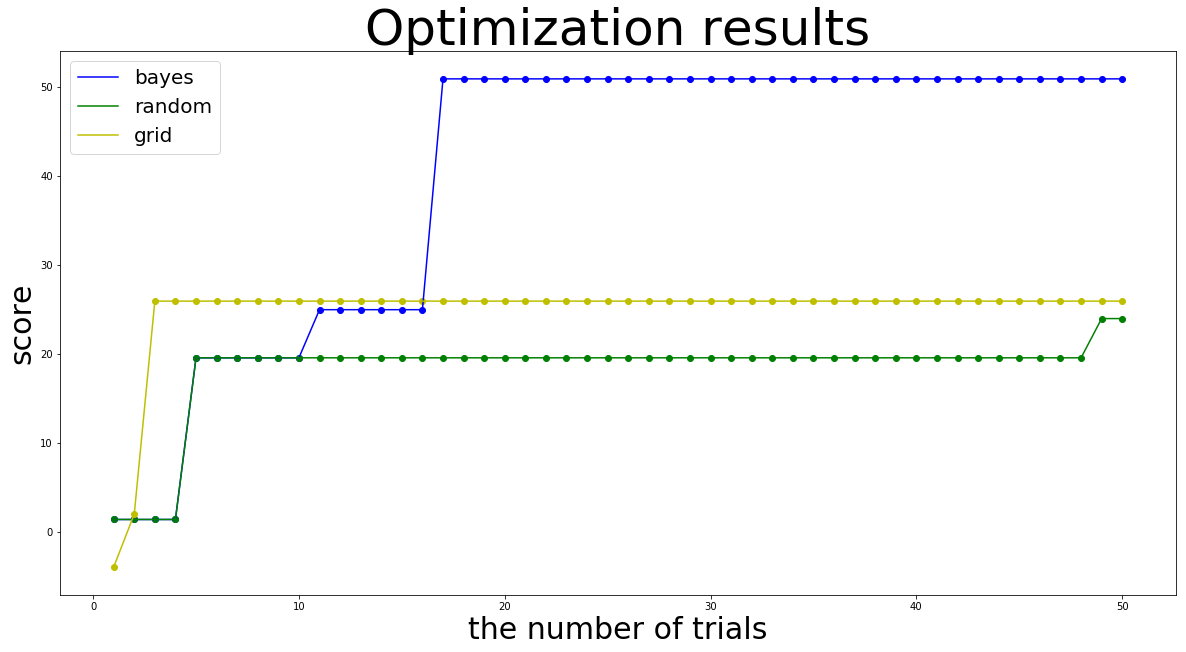

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
X = np.arange(1, len(bayes_opt.results[1]) + 1)
plt.plot(X, bayes_opt.results[1], color="b", label="bayes")
plt.plot(X, random_opt.results[1], color="g", label="random")
plt.plot(X, grid_opt.results[1], color="y", label="grid")

plt.scatter(X, bayes_opt.results[1], color="b")
plt.scatter(X, random_opt.results[1], color="g")
plt.scatter(X, grid_opt.results[1], color="y")

plt.xlabel("the number of trials", fontsize=30)
plt.ylabel("score", fontsize=30)
plt.title("Optimization results", fontsize=50)

plt.legend(fontsize=20)
plt.savefig("toy_model_opt.jpg")

In [11]:
print("bayes", bayes_opt.best_results)
print("random", random_opt.best_results)
print("grid", grid_opt.best_results)

bayes ({'x1': 5, 'x2': -5.0, 'x3': -5.0, 'x4': 'square'}, 50.95892427466314)
random ({'x1': 2.342606829481905, 'x2': 2.038885835403663, 'x3': -4.198184901501591, 'x4': 'square'}, 24.004995120648054)
grid ({'x1': 0.1, 'x2': -5.0, 'x3': -5.0, 'x4': 'square'}, 25.968924274663138)


### Hyperparameter Optimization
Next problem is tuning hyperparameters of one of the basic machine learning models, Support Vector Machine. We consider optimizing regularization parameters `C` and `gamma` with accuracy score under fixed kernel to RBF at `scikit-learn` implementation. We use an artificially classification problem made up with  `make_classification` of `scikit-learn`. Let's set up the problem!

```python
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit


data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=5,
                                   n_redundant=5)


def score_func(params):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_idx, test_idx = list(splitter.split(data, target))[0]
    train_data = data[train_idx]
    train_target = target[train_idx]
    clf = SVC(**params)
    clf.fit(train_data, train_target)
    pred = clf.predict(data[test_idx])
    true_y = target[test_idx]
    score = accuracy_score(true_y, pred)
    return score

params_conf = [
    {'name': 'C', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'gamma', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'kernel', 'domain': 'rbf', 'type': 'fixed'}
]
```

Here is the results:

![hyper_opt]({filename}/images/bayes_opt/hyper_opt.jpg)

- bayes
```python
best_params={'C': 100000.0, 'gamma': 0.03836608377440943, 'kernel': 'rbf'}
best_score=0.928
```
- random:
```python
best_params={'C': 196.07647697179934, 'gamma': 0.07509896588333721, 'kernel': 'rbf'}
best_score= 0.91
```
- grid:
```python
best_params={'C': 4.641588833612772, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
best_score=0.904
```

As you see in the result above, Bayesian optimization outperformed other algorithms. 

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit


data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=5,
                                   n_redundant=5)


def score_func(params):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    train_idx, test_idx = list(splitter.split(data, target))[0]
    train_data = data[train_idx]
    train_target = target[train_idx]
    clf = SVC(**params)
    clf.fit(train_data, train_target)
    pred = clf.predict(data[test_idx])
    true_y = target[test_idx]
    score = accuracy_score(true_y, pred)
    return score

params_conf = [
    {'name': 'C', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'gamma', 'domain': (1e-8, 1e5), 'type': 'continuous', 'scale': 'log'},
    {'name': 'kernel', 'domain': 'rbf', 'type': 'fixed'}
]

In [2]:
from bboptimizer import Optimizer
import random
import numpy as np

np.random.seed(0)
random.seed(0)
bayes_opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=10, maximize=True)
bayes_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
random_opt = Optimizer(score_func, params_conf, sampler="random", maximize=True)
random_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
grid_opt = Optimizer(score_func, params_conf, sampler="grid", num_grid=7, maximize=True)
grid_opt.search(num_iter=50)

100%|██████████| 50/50 [00:15<00:00,  2.71it/s]


({'C': 4.641588833612772, 'gamma': 0.03162277660168379, 'kernel': 'rbf'},
 0.904)

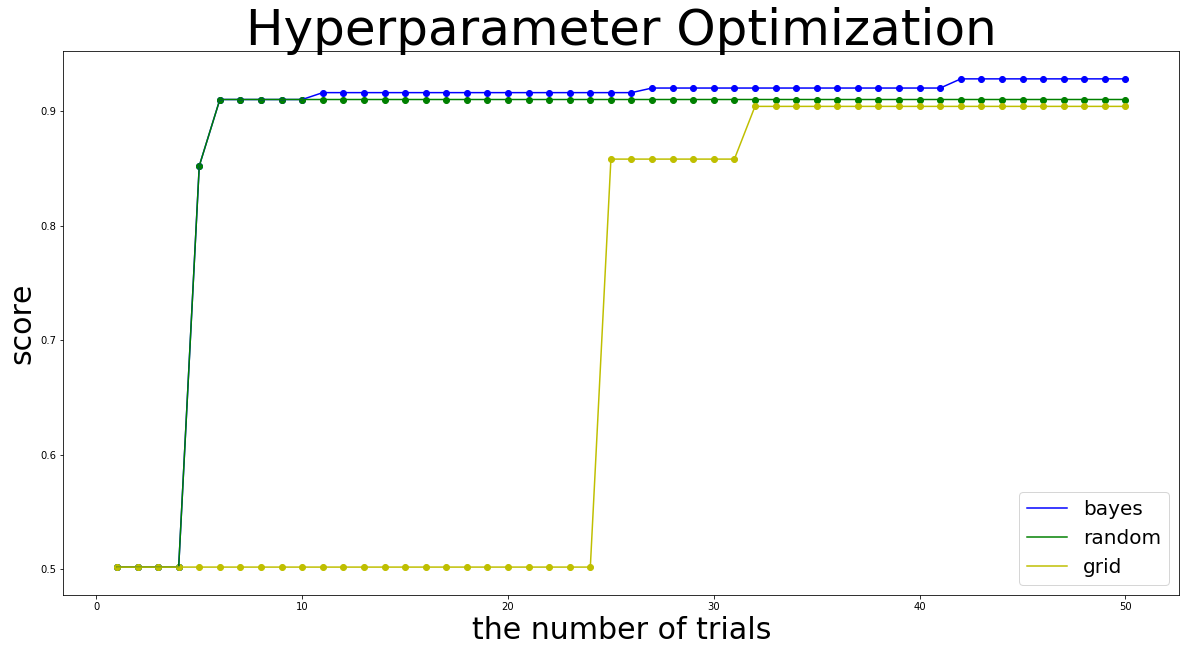

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
X = np.arange(1, len(bayes_opt.results[1]) + 1)
plt.plot(X, bayes_opt.results[1], color="b", label="bayes")
plt.plot(X, random_opt.results[1], color="g", label="random")
plt.plot(X, grid_opt.results[1], color="y", label="grid")

plt.scatter(X, bayes_opt.results[1], color="b")
plt.scatter(X, random_opt.results[1], color="g")
plt.scatter(X, grid_opt.results[1], color="y")

plt.xlabel("the number of trials", fontsize=30)
plt.ylabel("score", fontsize=30)
plt.title("Hyperparameter Optimization", fontsize=50)

plt.legend(fontsize=20)
plt.savefig("hyper_opt.jpg")

In [5]:
print("bayes", bayes_opt.best_results)
print("random", random_opt.best_results)
print("grid", grid_opt.best_results)

bayes ({'C': 100000.0, 'gamma': 0.03836608377440943, 'kernel': 'rbf'}, 0.928)
random ({'C': 196.07647697179934, 'gamma': 0.07509896588333721, 'kernel': 'rbf'}, 0.91)
grid ({'C': 4.641588833612772, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}, 0.904)


### Neural Network  Optimization

As a final example, we are going to optimize hyperparameters of Neural Network.
For the sake of the simplicity, we define hyperparameters with the following parameters:

For training configuration, we define
- learning rate
- the number of training epochs
- optimization algorithm
- batch size

For each input, hidden, output layers we define
- the number of layers
- the number of hidden units
- weight regularizer
- activation function 
- dropout rate
- if use batch normalization

Thus, we have 22 hyperparameters, which is almost infeasible to be optimized by grid search. In this example, we test Bayesian and random search to find good set of 22 hyperparameters.

To test optimization algorithms, we use machine learning "hello world" problem, classifying MNIST handwrite digit data. We fetch data from tensorflow interface and use the train and valid data.

Let's set up the problem:

```python
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import Activation, Reshape
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras.regularizers import l2

from bboptimizer import Optimizer

# Fetch MNIST dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")


train = mnist.train
X = train.images
train_X = X
train_y = np.expand_dims(train.labels, -1)
train_y = OneHotEncoder().fit_transform(train_y)

valid = mnist.validation
X = valid.images
valid_X = X 
valid_y = np.expand_dims(valid.labels, -1)
valid_y = OneHotEncoder().fit_transform(valid_y)


def get_optimzier(name, **kwargs):
    if name == "rmsprop":
        return RMSprop(**kwargs)
    elif name == "adam":
        return Adam(**kwargs)
    elif name == "sgd":
        return SGD(**kwargs)
    elif name == "adadelta":
        return Adadelta(**kwargs)
    else:
        raise ValueError(name)


def construct_NN(params):
    model = Sequential()
    model.add(Reshape((784,), input_shape=(784,)))
    
    def update_model(_model, _params, name):
        _model.add(Dropout(_params[name + "_drop_rate"]))
        _model.add(Dense(units=_params[name + "_num_units"],
                    activation=None,
                    kernel_regularizer=l2(_params[name + "_w_reg"])))
        if _params[name + "_is_batch"]:
            _model.add(BatchNormalization())
        if _params[name + "_activation"] is not None:
            _model.add(Activation(_params[name + "_activation"]))
        return _model
    
    # Add input layer    
    model = update_model(model, params, "input")
    # Add hidden layer
    for i in range(params["num_hidden_layers"]):
        model = update_model(model, params, "hidden")
    # Add output layer
    model = update_model(model, params, "output")
    optimizer = get_optimzier(params["optimizer"],
                              lr=params["learning_rate"])
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
        

def score_func(params):
    model = construct_NN(params)
    model.fit(train_X, train_y,
              epochs=params["epochs"],
              batch_size=params["batch_size"], verbose=1)
    score = model.evaluate(valid_X, valid_y,
                  batch_size=params["batch_size"])
    idx = model.metrics_names.index("acc")
    score = score[idx]
    print(params, score)
    return score

params_conf = [
    {"name": "num_hidden_layers", "type": "integer",
     "domain": (0, 5)},
    {"name": "batch_size", "type": "integer",
     "domain": (16, 128), "scale": "log"},
    {"name": "learning_rate", "type": "continuous",
     "domain": (1e-5, 1e-1), "scale": "log"},
    {"name": "epochs", "type": "integer",
     "domain": (10, 250), "scale": "log"},
    {"name": "optimizer", "type": "categorical",
     "domain": ("rmsprop", "sgd", "adam", "adadelta")},
    
    {"name": "input_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "input_num_units", "type": "integer",
     "domain": (32, 512), "scale": "log"},
    {"name": "input_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "input_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "input_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "hidden_drop_rate", "type": "continuous",
     "domain": (0, 0.75)},
    {"name": "hidden_num_units", "type": "integer",
     "domain": (32, 512), "scale": "log"},
    {"name": "hidden_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "hidden_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "hidden_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "output_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "output_num_units", "type": "fixed",
     "domain": 10},
    {"name": "output_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "output_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "output_activation", "type": "fixed",
     "domain": "softmax"},
    
]
```

Here is the result:

![hyper_opt]({filename}/images/bayes_opt/hyper_nn_opt.jpg)

```python
bayes:
best_params = {'num_hidden_layers': 0,
               'batch_size': 128,
               'learning_rate': 0.0009053002734681439,
               'epochs': 250,
               'optimizer': 'rmsprop',
               'input_drop_rate': 0.5,
               'input_num_units': 512,
               'input_w_reg': 1.2840834618450513e-06,
               'input_is_batch': True,
               'input_activation': 'sigmoid',
               'hidden_drop_rate': 0.0,
               'hidden_num_units': 41,
               'hidden_w_reg': 6.970606129393136e-07,
               'hidden_is_batch': True,
               'hidden_activation': 'relu',
               'output_drop_rate': 0.0,
               'output_w_reg': 1e-10,
               'output_is_batch': True,
               'output_num_units': 10,
               'output_activation': 'softmax'}

best_score = 0.9864


random:
best_params = {'batch_size': 74,
               'epochs': 204,
               'hidden_activation': 'tanh',
               'hidden_drop_rate': 0.6728025784523577,
               'hidden_is_batch': False,
               'hidden_num_units': 45,
               'hidden_w_reg': 1.4924891356983298e-08,
               'input_activation': 'relu',
               'input_drop_rate': 0.12861674273569668,
               'input_is_batch': True,
               'input_num_units': 92,
               'input_w_reg': 0.00018805052553280536,
               'learning_rate': 0.0006256532585348427,
               'num_hidden_layers': 0,
               'optimizer': 'adam',
               'output_activation': 'softmax',
               'output_drop_rate': 0.11413180495018566,
               'output_is_batch': False,
               'output_num_units': 10,
               'output_w_reg': 2.544391637336686e-06}
               
best_score = 0.9822000049591064
```

In this example, Bayesian search finds that maximum value of the number of epochs is more likely to bring better score and keep using this value from the middle of searching. Then, Bayesian search finds better values more efficiently.

In [10]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf

# Fetch MNIST dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")


train = mnist.train
X = train.images
train_X = X
train_y = np.expand_dims(train.labels, -1)
train_y = OneHotEncoder().fit_transform(train_y)

valid = mnist.validation
X = valid.images
valid_X = X 
valid_y = np.expand_dims(valid.labels, -1)
valid_y = OneHotEncoder().fit_transform(valid_y)

test = mnist.test
X = test.images
test_X = X
test_y = test.labels

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [17]:
from bboptimizer import Optimizer
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import Activation, Reshape
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras.regularizers import l1, l2


def get_optimzier(name, **kwargs):
    if name == "rmsprop":
        return RMSprop(**kwargs)
    elif name == "adam":
        return Adam(**kwargs)
    elif name == "sgd":
        return SGD(**kwargs)
    elif name == "adadelta":
        return Adadelta(**kwargs)
    else:
        raise ValueError(name)


def construct_NN(params):
    model = Sequential()
    model.add(Reshape((784,), input_shape=(784,)))
    
    def update_model(_model, _params, name):
        _model.add(Dropout(_params[name + "_drop_rate"]))
        _model.add(Dense(units=_params[name + "_num_units"],
                    activation=None,
                    kernel_regularizer=l2(_params[name + "_w_reg"])))
        if _params[name + "_is_batch"]:
            _model.add(BatchNormalization())
        if _params[name + "_activation"] is not None:
            _model.add(Activation(_params[name + "_activation"]))
        return _model
    
    # Add input layer    
    model = update_model(model, params, "input")
    # Add hidden layer
    for i in range(params["num_hidden_layers"]):
        model = update_model(model, params, "hidden")
    # Add output layer
    model = update_model(model, params, "output")
    optimizer = get_optimzier(params["optimizer"],
                              lr=params["learning_rate"])
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
        

def score_func(params):
    # print("parameters", params)
    model = construct_NN(params)
    model.fit(train_X, train_y,
              epochs=params["epochs"],
              batch_size=params["batch_size"], verbose=1)
    # print("###################", model.metrics_names)
    score = model.evaluate(valid_X, valid_y,
                  batch_size=params["batch_size"])
    idx = model.metrics_names.index("acc")
    score = score[idx]
    print(params, score)
    return score

params_conf = [
    {"name": "num_hidden_layers", "type": "integer",
     "domain": (0, 5)},
    {"name": "batch_size", "type": "integer",
     "domain": (16, 128), "scale": "log"},
    {"name": "learning_rate", "type": "continuous",
     "domain": (1e-5, 1e-1), "scale": "log"},
    {"name": "epochs", "type": "integer",
     "domain": (10, 250), "scale": "log"},
    {"name": "optimizer", "type": "categorical",
     "domain": ("rmsprop", "sgd", "adam", "adadelta")},
    
    {"name": "input_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "input_num_units", "type": "integer",
     "domain": (32, 512), "scale": "log"},
    {"name": "input_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "input_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "input_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "hidden_drop_rate", "type": "continuous",
     "domain": (0, 0.75)},
    {"name": "hidden_num_units", "type": "integer",
     "domain": (32, 512), "scale": "log"},
    {"name": "hidden_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "hidden_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "hidden_activation", "type": "categorical",
     "domain": ("relu", "sigmoid", "tanh")},
    
    {"name": "output_drop_rate", "type": "continuous",
     "domain": (0, 0.5)},
    {"name": "output_num_units", "type": "fixed",
     "domain": 10},
    {"name": "output_w_reg", "type": "continuous",
     "domain": (1e-10, 1e-1), "scale": "log"},
    {"name": "output_is_batch", "type": "categorical",
     "domain": (True, False)},
    {"name": "output_activation", "type": "fixed",
     "domain": "softmax"},
    
]




In [18]:
from bboptimizer import Optimizer
import random

np.random.seed(0)
random.seed(0)
bayes_opt = Optimizer(score_func, params_conf, sampler="bayes", r_min=10, maximize=True)
bayes_opt.search(num_iter=50)


np.random.seed(0)
random.seed(0)
random_opt = Optimizer(score_func, params_conf, sampler="random", maximize=True)
random_opt.search(num_iter=50)




  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1/158
55000/55000 [==============================] - 4s 79us/step - loss: 2.4706 - acc: 0.1035
Epoch 2/158
55000/55000 [==============================] - 4s 66us/step - loss: 2.4000 - acc: 0.1038
Epoch 3/158
55000/55000 [==============================] - 4s 66us/step - loss: 2.3864 - acc: 0.0996
Epoch 4/158
55000/55000 [==============================] - 4s 66us/step - loss: 2.3801 - acc: 0.1020
Epoch 5/158
55000/55000 [==============================] - 4s 66us/step - loss: 2.3727 - acc: 0.1044
Epoch 6/158
55000/55000 [==============================] - 4s 66us/step - loss: 2.3688 - acc: 0.1045
Epoch 7/158
55000/55000 [==============================] - 4s 67us/step - loss: 2.3644 - acc: 0.1039
Epoch 8/158
55000/55000 [==============================] - 4s 67us/step - loss: 2.3591 - acc: 0.1025
Epoch 9/158
55000/55000 [==============================] - 4s 68us/step - loss: 2.3560 - acc: 0.1050
Epoch 10/158
55000/55000 [==============================] - 4s 67us/step - loss: 2.3524 - a

55000/55000 [==============================] - 3s 63us/step - loss: 1.8551 - acc: 0.2521
Epoch 82/158
55000/55000 [==============================] - 3s 64us/step - loss: 1.8443 - acc: 0.2584
Epoch 83/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8376 - acc: 0.2573
Epoch 84/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8294 - acc: 0.2629
Epoch 85/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8235 - acc: 0.2661
Epoch 86/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8165 - acc: 0.2669
Epoch 87/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8037 - acc: 0.2699
Epoch 88/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.7971 - acc: 0.2715
Epoch 89/158
55000/55000 [==============================] - 3s 64us/step - loss: 1.7876 - acc: 0.2703
Epoch 90/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.7775 - acc: 




  2%|▏         | 1/50 [09:19<7:37:03, 559.66s/it]



Epoch 1/30
55000/55000 [==============================] - 5s 91us/step - loss: 2.8068 - acc: 0.6543
Epoch 2/30
55000/55000 [==============================] - 4s 78us/step - loss: 2.7954 - acc: 0.6620
Epoch 3/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7861 - acc: 0.6624
Epoch 4/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7932 - acc: 0.6678
Epoch 5/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7933 - acc: 0.6665
Epoch 6/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.8000 - acc: 0.6665
Epoch 7/30
55000/55000 [==============================] - 4s 78us/step - loss: 2.8163 - acc: 0.6669
Epoch 8/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.8060 - acc: 0.6714
Epoch 9/30
55000/55000 [==============================] - 4s 78us/step - loss: 2.8049 - acc: 0.6681
Epoch 10/30
55000/55000 [==============================] - 4s 78us/step - loss: 2.8196 - acc: 0.6723




  4%|▍         | 2/50 [11:28<5:44:25, 430.53s/it]



Epoch 1/16
55000/55000 [==============================] - 15s 277us/step - loss: 0.7952 - acc: 0.7556
Epoch 2/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.5891 - acc: 0.8213
Epoch 3/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.5014 - acc: 0.8507
Epoch 4/16
55000/55000 [==============================] - 14s 258us/step - loss: 0.4559 - acc: 0.8683
Epoch 5/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.4348 - acc: 0.8762
Epoch 6/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.4183 - acc: 0.8819
Epoch 7/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.3996 - acc: 0.8898
Epoch 8/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.3894 - acc: 0.8940
Epoch 9/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.3808 - acc: 0.8979
Epoch 10/16
55000/55000 [==============================] - 14s 257us/step - loss: 




  6%|▌         | 3/50 [15:18<4:50:04, 370.30s/it]



Epoch 1/35
55000/55000 [==============================] - 12s 212us/step - loss: 14.7465 - acc: 0.0988
Epoch 2/35
55000/55000 [==============================] - 11s 199us/step - loss: 14.6643 - acc: 0.0995
Epoch 3/35
55000/55000 [==============================] - 11s 193us/step - loss: 14.5637 - acc: 0.0978
Epoch 4/35
55000/55000 [==============================] - 11s 202us/step - loss: 14.4474 - acc: 0.1003
Epoch 5/35
55000/55000 [==============================] - 11s 200us/step - loss: 14.3242 - acc: 0.0981
Epoch 6/35
55000/55000 [==============================] - 11s 193us/step - loss: 14.1865 - acc: 0.0997
Epoch 7/35
55000/55000 [==============================] - 11s 194us/step - loss: 14.0561 - acc: 0.0990
Epoch 8/35
55000/55000 [==============================] - 11s 193us/step - loss: 13.9082 - acc: 0.1026
Epoch 9/35
55000/55000 [==============================] - 11s 194us/step - loss: 13.7593 - acc: 0.1024
Epoch 10/35
55000/55000 [==============================] - 11s 194us/step




  8%|▊         | 4/50 [21:32<4:44:49, 371.50s/it]



Epoch 1/32
55000/55000 [==============================] - 10s 174us/step - loss: 17.5011 - acc: 0.0985
Epoch 2/32
55000/55000 [==============================] - 9s 168us/step - loss: 17.1606 - acc: 0.0984
Epoch 3/32
55000/55000 [==============================] - 9s 163us/step - loss: 16.7735 - acc: 0.1011
Epoch 4/32
55000/55000 [==============================] - 9s 164us/step - loss: 16.3662 - acc: 0.1054
Epoch 5/32
55000/55000 [==============================] - 9s 163us/step - loss: 15.9644 - acc: 0.1064
Epoch 6/32
55000/55000 [==============================] - 9s 162us/step - loss: 15.5774 - acc: 0.1101
Epoch 7/32
55000/55000 [==============================] - 9s 164us/step - loss: 15.2099 - acc: 0.1120
Epoch 8/32
55000/55000 [==============================] - 9s 167us/step - loss: 14.8606 - acc: 0.1145
Epoch 9/32
55000/55000 [==============================] - 10s 179us/step - loss: 14.5330 - acc: 0.1182
Epoch 10/32
55000/55000 [==============================] - 10s 175us/step - loss




 10%|█         | 5/50 [26:31<4:22:17, 349.71s/it]



Epoch 1/14
55000/55000 [==============================] - 8s 152us/step - loss: 2.6908 - acc: 0.1077
Epoch 2/14
55000/55000 [==============================] - 7s 133us/step - loss: 2.6908 - acc: 0.1065
Epoch 3/14
55000/55000 [==============================] - 7s 130us/step - loss: 2.6824 - acc: 0.1089
Epoch 4/14
55000/55000 [==============================] - 7s 128us/step - loss: 2.6760 - acc: 0.1076
Epoch 5/14
55000/55000 [==============================] - 7s 126us/step - loss: 2.6594 - acc: 0.1128
Epoch 6/14
55000/55000 [==============================] - 7s 129us/step - loss: 2.6599 - acc: 0.1120
Epoch 7/14
55000/55000 [==============================] - 8s 137us/step - loss: 2.6562 - acc: 0.1113
Epoch 8/14
55000/55000 [==============================] - 8s 138us/step - loss: 2.6395 - acc: 0.1153
Epoch 9/14
55000/55000 [==============================] - 8s 140us/step - loss: 2.6291 - acc: 0.1193
Epoch 10/14
55000/55000 [==============================] - 7s 132us/step - loss: 2.6292 - a




 12%|█▏        | 6/50 [28:16<3:22:31, 276.17s/it]



Epoch 1/12
55000/55000 [==============================] - 3s 51us/step - loss: 2.8079 - acc: 0.1023
Epoch 2/12
55000/55000 [==============================] - 2s 38us/step - loss: 2.7627 - acc: 0.1046
Epoch 3/12
55000/55000 [==============================] - 2s 37us/step - loss: 2.7153 - acc: 0.1112
Epoch 4/12
55000/55000 [==============================] - 2s 37us/step - loss: 2.6604 - acc: 0.1172
Epoch 5/12
55000/55000 [==============================] - 2s 36us/step - loss: 2.6102 - acc: 0.1234
Epoch 6/12
55000/55000 [==============================] - 2s 37us/step - loss: 2.5481 - acc: 0.1334
Epoch 7/12
55000/55000 [==============================] - 2s 37us/step - loss: 2.4926 - acc: 0.1444
Epoch 8/12
55000/55000 [==============================] - 2s 37us/step - loss: 2.4454 - acc: 0.1488
Epoch 9/12
55000/55000 [==============================] - 2s 38us/step - loss: 2.4056 - acc: 0.1531
Epoch 10/12
55000/55000 [==============================] - 2s 36us/step - loss: 2.3686 - acc: 0.1577




 14%|█▍        | 7/50 [28:42<2:24:07, 201.12s/it]



Epoch 1/162
55000/55000 [==============================] - 10s 183us/step - loss: 12.2830 - acc: 0.1506
Epoch 2/162
55000/55000 [==============================] - 9s 158us/step - loss: 10.6342 - acc: 0.2817
Epoch 3/162
55000/55000 [==============================] - 9s 163us/step - loss: 9.3338 - acc: 0.4081
Epoch 4/162
55000/55000 [==============================] - 9s 167us/step - loss: 8.3207 - acc: 0.4964
Epoch 5/162
55000/55000 [==============================] - 9s 158us/step - loss: 7.4997 - acc: 0.5466
Epoch 6/162
55000/55000 [==============================] - 9s 156us/step - loss: 6.8091 - acc: 0.5891
Epoch 7/162
55000/55000 [==============================] - 9s 157us/step - loss: 6.2279 - acc: 0.6146
Epoch 8/162
55000/55000 [==============================] - 9s 156us/step - loss: 5.7246 - acc: 0.6376
Epoch 9/162
55000/55000 [==============================] - 9s 156us/step - loss: 5.2903 - acc: 0.6564
Epoch 10/162
55000/55000 [==============================] - 9s 156us/step - los

55000/55000 [==============================] - 9s 156us/step - loss: 0.9042 - acc: 0.8295
Epoch 81/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8953 - acc: 0.8314
Epoch 82/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8952 - acc: 0.8280
Epoch 83/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8858 - acc: 0.8292
Epoch 84/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8766 - acc: 0.8325
Epoch 85/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8728 - acc: 0.8303
Epoch 86/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8625 - acc: 0.8339
Epoch 87/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8624 - acc: 0.8324
Epoch 88/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.8581 - acc: 0.8314
Epoch 89/162
55000/55000 [==============================] - 9s 156us/step - loss: 0.85

55000/55000 [==============================] - 9s 159us/step - loss: 0.6408 - acc: 0.8557
Epoch 160/162
55000/55000 [==============================] - 9s 159us/step - loss: 0.6388 - acc: 0.8562
Epoch 161/162
55000/55000 [==============================] - 9s 160us/step - loss: 0.6412 - acc: 0.8555
Epoch 162/162
5000/5000 [==============================] - 0s 50us/step
{'num_hidden_layers': 3, 'batch_size': 25, 'learning_rate': 0.0018228690298073423, 'epochs': 162, 'optimizer': 'adadelta', 'input_drop_rate': 0.25448448033350723, 'input_num_units': 406, 'input_w_reg': 0.019517244023832918, 'input_is_batch': True, 'input_activation': 'sigmoid', 'hidden_drop_rate': 0.06233436947295179, 'hidden_num_units': 69, 'hidden_w_reg': 1.213976678631443e-10, 'hidden_is_batch': False, 'hidden_activation': 'tanh', 'output_drop_rate': 0.4211710398338655, 'output_w_reg': 6.676783001413344e-05, 'output_is_batch': True, 'output_num_units': 10, 'output_activation': 'softmax'} 0.933599993288517





 16%|█▌        | 8/50 [52:21<6:36:27, 566.38s/it]



Epoch 1/59
55000/55000 [==============================] - 4s 67us/step - loss: 2.3391 - acc: 0.1291
Epoch 2/59
55000/55000 [==============================] - 3s 56us/step - loss: 2.2225 - acc: 0.2005
Epoch 3/59
55000/55000 [==============================] - 3s 55us/step - loss: 2.1419 - acc: 0.2647
Epoch 4/59
55000/55000 [==============================] - 3s 55us/step - loss: 2.0634 - acc: 0.3301
Epoch 5/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.9917 - acc: 0.3857
Epoch 6/59
55000/55000 [==============================] - 3s 56us/step - loss: 1.9191 - acc: 0.4374
Epoch 7/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.8516 - acc: 0.4782
Epoch 8/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.7834 - acc: 0.5126
Epoch 9/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.7220 - acc: 0.5413
Epoch 10/59
55000/55000 [==============================] - 3s 59us/step - loss: 1.6668 - acc: 0.5639




 18%|█▊        | 9/50 [55:35<5:10:51, 454.91s/it]



Epoch 1/176
55000/55000 [==============================] - 2s 38us/step - loss: 11.6028 - acc: 0.4474
Epoch 2/176
55000/55000 [==============================] - 1s 25us/step - loss: 7.2387 - acc: 0.6821
Epoch 3/176
55000/55000 [==============================] - 1s 25us/step - loss: 4.6889 - acc: 0.7573
Epoch 4/176
55000/55000 [==============================] - 1s 27us/step - loss: 3.1025 - acc: 0.8013
Epoch 5/176
55000/55000 [==============================] - 1s 25us/step - loss: 2.1163 - acc: 0.8322
Epoch 6/176
55000/55000 [==============================] - 1s 25us/step - loss: 1.4921 - acc: 0.8562
Epoch 7/176
55000/55000 [==============================] - 1s 24us/step - loss: 1.0963 - acc: 0.8739
Epoch 8/176
55000/55000 [==============================] - 1s 24us/step - loss: 0.8466 - acc: 0.8891
Epoch 9/176
55000/55000 [==============================] - 1s 24us/step - loss: 0.6843 - acc: 0.8994
Epoch 10/176
55000/55000 [==============================] - 1s 24us/step - loss: 0.5875 - 

55000/55000 [==============================] - 2s 27us/step - loss: 0.3281 - acc: 0.9256
Epoch 82/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3260 - acc: 0.9266
Epoch 83/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3263 - acc: 0.9267
Epoch 84/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3263 - acc: 0.9255
Epoch 85/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3261 - acc: 0.9259
Epoch 86/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3253 - acc: 0.9255
Epoch 87/176
55000/55000 [==============================] - 1s 24us/step - loss: 0.3272 - acc: 0.9250
Epoch 88/176
55000/55000 [==============================] - 1s 26us/step - loss: 0.3264 - acc: 0.9253
Epoch 89/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3243 - acc: 0.9260
Epoch 90/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3256 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.3139 - acc: 0.9282
Epoch 161/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3142 - acc: 0.9289
Epoch 162/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3159 - acc: 0.9289
Epoch 163/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3134 - acc: 0.9279
Epoch 164/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3164 - acc: 0.9275
Epoch 165/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3180 - acc: 0.9258
Epoch 166/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3167 - acc: 0.9288
Epoch 167/176
55000/55000 [==============================] - 1s 22us/step - loss: 0.3176 - acc: 0.9271
Epoch 168/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.3135 - acc: 0.9287
Epoch 169/176
55000/55000 [==============================] - 1s 23us/step - loss: 0.316




 20%|██        | 10/50 [59:22<4:17:35, 386.38s/it]



Epoch 1/17
55000/55000 [==============================] - 16s 294us/step - loss: 0.7523 - acc: 0.7715
Epoch 2/17
55000/55000 [==============================] - 15s 279us/step - loss: 0.5803 - acc: 0.8402
Epoch 3/17
55000/55000 [==============================] - 15s 280us/step - loss: 0.5490 - acc: 0.8634
Epoch 4/17
55000/55000 [==============================] - 15s 280us/step - loss: 0.5381 - acc: 0.8756
Epoch 5/17
55000/55000 [==============================] - 16s 293us/step - loss: 0.5352 - acc: 0.8804
Epoch 6/17
55000/55000 [==============================] - 16s 285us/step - loss: 0.5287 - acc: 0.8874
Epoch 7/17
55000/55000 [==============================] - 16s 286us/step - loss: 0.5272 - acc: 0.8885
Epoch 8/17
55000/55000 [==============================] - 16s 284us/step - loss: 0.5268 - acc: 0.8903
Epoch 9/17
55000/55000 [==============================] - 15s 281us/step - loss: 0.5206 - acc: 0.8938
Epoch 10/17
55000/55000 [==============================] - 15s 282us/step - loss: 




 22%|██▏       | 11/50 [1:04:05<3:51:06, 355.54s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 29us/step - loss: 2.8178 - acc: 0.6355
Epoch 2/250
55000/55000 [==============================] - 1s 18us/step - loss: 2.0462 - acc: 0.7876
Epoch 3/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.6364 - acc: 0.8262
Epoch 4/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.3327 - acc: 0.8522
Epoch 5/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.1048 - acc: 0.8691
Epoch 6/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.9263 - acc: 0.8838
Epoch 7/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.7864 - acc: 0.8964
Epoch 8/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.6771 - acc: 0.9027
Epoch 9/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.5844 - acc: 0.9098
Epoch 10/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.5186 - a

55000/55000 [==============================] - 1s 18us/step - loss: 0.2598 - acc: 0.9390
Epoch 82/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2577 - acc: 0.9391
Epoch 83/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2577 - acc: 0.9396
Epoch 84/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2632 - acc: 0.9379
Epoch 85/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2617 - acc: 0.9370
Epoch 86/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2584 - acc: 0.9398
Epoch 87/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2610 - acc: 0.9381
Epoch 88/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2614 - acc: 0.9377
Epoch 89/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2581 - acc: 0.9399
Epoch 90/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2550 - acc: 

55000/55000 [==============================] - 1s 18us/step - loss: 0.2563 - acc: 0.9397
Epoch 161/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2546 - acc: 0.9400
Epoch 162/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2522 - acc: 0.9419
Epoch 163/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2532 - acc: 0.9414
Epoch 164/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2566 - acc: 0.9403
Epoch 165/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2580 - acc: 0.9391
Epoch 166/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2549 - acc: 0.9411
Epoch 167/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2538 - acc: 0.9410
Epoch 168/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2517 - acc: 0.9411
Epoch 169/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.254

55000/55000 [==============================] - 1s 18us/step - loss: 0.2556 - acc: 0.9403
Epoch 240/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2534 - acc: 0.9414
Epoch 241/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2540 - acc: 0.9404
Epoch 242/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2505 - acc: 0.9401
Epoch 243/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2545 - acc: 0.9418
Epoch 244/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2532 - acc: 0.9420
Epoch 245/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.2518 - acc: 0.9416
Epoch 246/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2518 - acc: 0.9418
Epoch 247/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.2540 - acc: 0.9417
Epoch 248/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.251




 24%|██▍       | 12/50 [1:08:25<3:27:01, 326.88s/it]



Epoch 1/36
55000/55000 [==============================] - 7s 131us/step - loss: 0.6289 - acc: 0.8115
Epoch 2/36
55000/55000 [==============================] - 6s 115us/step - loss: 0.4182 - acc: 0.8717
Epoch 3/36
55000/55000 [==============================] - 6s 117us/step - loss: 0.3454 - acc: 0.8990
Epoch 4/36
55000/55000 [==============================] - 6s 116us/step - loss: 0.3139 - acc: 0.9090
Epoch 5/36
55000/55000 [==============================] - 6s 117us/step - loss: 0.2898 - acc: 0.9184
Epoch 6/36
55000/55000 [==============================] - 6s 116us/step - loss: 0.2827 - acc: 0.9220
Epoch 7/36
55000/55000 [==============================] - 6s 115us/step - loss: 0.2775 - acc: 0.9256
Epoch 8/36
55000/55000 [==============================] - 6s 114us/step - loss: 0.2737 - acc: 0.9283
Epoch 9/36
55000/55000 [==============================] - 6s 114us/step - loss: 0.2737 - acc: 0.9295
Epoch 10/36
55000/55000 [==============================] - 6s 116us/step - loss: 0.2680 - a




 26%|██▌       | 13/50 [1:12:25<3:05:28, 300.77s/it]



Epoch 1/10
55000/55000 [==============================] - 17s 306us/step - loss: 0.8104 - acc: 0.7780
Epoch 2/10
55000/55000 [==============================] - 17s 303us/step - loss: 0.7984 - acc: 0.8339
Epoch 3/10
55000/55000 [==============================] - 17s 303us/step - loss: 0.8115 - acc: 0.8488
Epoch 4/10
55000/55000 [==============================] - 16s 299us/step - loss: 0.8091 - acc: 0.8605
Epoch 5/10
55000/55000 [==============================] - 17s 301us/step - loss: 0.8125 - acc: 0.8637
Epoch 6/10
55000/55000 [==============================] - 17s 302us/step - loss: 0.8187 - acc: 0.8673
Epoch 7/10
55000/55000 [==============================] - 17s 302us/step - loss: 0.8273 - acc: 0.8678
Epoch 8/10
55000/55000 [==============================] - 17s 303us/step - loss: 0.8241 - acc: 0.8704
Epoch 9/10
55000/55000 [==============================] - 17s 302us/step - loss: 0.8292 - acc: 0.8696
Epoch 10/10
5000/5000 [==============================] - 0s 84us/step
{'num_hidden




 28%|██▊       | 14/50 [1:15:23<2:38:22, 263.97s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 32us/step - loss: 5.3114 - acc: 0.5292
Epoch 2/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.5359 - acc: 0.6059
Epoch 3/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.4957 - acc: 0.6193
Epoch 4/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.4799 - acc: 0.6234
Epoch 5/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.4653 - acc: 0.6296
Epoch 6/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.4526 - acc: 0.6342
Epoch 7/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.4413 - acc: 0.6360
Epoch 8/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.4317 - acc: 0.6387
Epoch 9/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.4188 - acc: 0.6405
Epoch 10/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.4105 - a

55000/55000 [==============================] - 1s 20us/step - loss: 1.2098 - acc: 0.7001
Epoch 82/250
55000/55000 [==============================] - 1s 21us/step - loss: 1.2083 - acc: 0.6994
Epoch 83/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.2109 - acc: 0.6979
Epoch 84/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.2101 - acc: 0.7002
Epoch 85/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.2106 - acc: 0.6988
Epoch 86/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.2088 - acc: 0.6995
Epoch 87/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.2101 - acc: 0.6990
Epoch 88/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.2078 - acc: 0.6991
Epoch 89/250
55000/55000 [==============================] - 1s 20us/step - loss: 1.2076 - acc: 0.7001
Epoch 90/250
55000/55000 [==============================] - 1s 23us/step - loss: 1.2041 - acc: 

55000/55000 [==============================] - 1s 18us/step - loss: 1.1713 - acc: 0.7102
Epoch 161/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.1722 - acc: 0.7111
Epoch 162/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.1735 - acc: 0.7110
Epoch 163/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.1807 - acc: 0.7077
Epoch 164/250
55000/55000 [==============================] - 1s 17us/step - loss: 1.1675 - acc: 0.7126
Epoch 165/250
55000/55000 [==============================] - 1s 17us/step - loss: 1.1764 - acc: 0.7097
Epoch 166/250
55000/55000 [==============================] - 1s 17us/step - loss: 1.1747 - acc: 0.7105
Epoch 167/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.1762 - acc: 0.7077
Epoch 168/250
55000/55000 [==============================] - 1s 17us/step - loss: 1.1777 - acc: 0.7090
Epoch 169/250
55000/55000 [==============================] - 1s 18us/step - loss: 1.173

55000/55000 [==============================] - 1s 19us/step - loss: 1.1626 - acc: 0.7139
Epoch 240/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1656 - acc: 0.7131
Epoch 241/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1573 - acc: 0.7144
Epoch 242/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1586 - acc: 0.7130
Epoch 243/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1615 - acc: 0.7141
Epoch 244/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1624 - acc: 0.7137
Epoch 245/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1611 - acc: 0.7150
Epoch 246/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1587 - acc: 0.7139
Epoch 247/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.1533 - acc: 0.7157
Epoch 248/250
55000/55000 [==============================] - 1s 19us/step - loss: 1.168




 30%|███       | 15/50 [1:20:02<2:36:37, 268.50s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 38us/step - loss: 14.7131 - acc: 0.6869
Epoch 2/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.9314 - acc: 0.8169
Epoch 3/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.7429 - acc: 0.8230
Epoch 4/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.7137 - acc: 0.8267
Epoch 5/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.6990 - acc: 0.8289
Epoch 6/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.6821 - acc: 0.8324
Epoch 7/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.6731 - acc: 0.8348
Epoch 8/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.6678 - acc: 0.8369
Epoch 9/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.6625 - acc: 0.8351
Epoch 10/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.6564 - 

55000/55000 [==============================] - 1s 25us/step - loss: 0.5971 - acc: 0.8591
Epoch 82/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5943 - acc: 0.8593
Epoch 83/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5938 - acc: 0.8600
Epoch 84/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5960 - acc: 0.8604
Epoch 85/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5967 - acc: 0.8601
Epoch 86/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.5951 - acc: 0.8604
Epoch 87/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5968 - acc: 0.8597
Epoch 88/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5947 - acc: 0.8604
Epoch 89/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5953 - acc: 0.8597
Epoch 90/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5937 - acc: 

55000/55000 [==============================] - 1s 25us/step - loss: 0.5723 - acc: 0.8697
Epoch 161/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5740 - acc: 0.8695
Epoch 162/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5790 - acc: 0.8675
Epoch 163/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.5708 - acc: 0.8694
Epoch 164/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5785 - acc: 0.8675
Epoch 165/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5765 - acc: 0.8691
Epoch 166/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.5745 - acc: 0.8701
Epoch 167/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5735 - acc: 0.8703
Epoch 168/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5732 - acc: 0.8699
Epoch 169/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.575

55000/55000 [==============================] - 1s 25us/step - loss: 0.5596 - acc: 0.8784
Epoch 240/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5583 - acc: 0.8771
Epoch 241/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5588 - acc: 0.8783
Epoch 242/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5601 - acc: 0.8767
Epoch 243/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.5627 - acc: 0.8767
Epoch 244/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5586 - acc: 0.8761
Epoch 245/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5604 - acc: 0.8758
Epoch 246/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5600 - acc: 0.8762
Epoch 247/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.5599 - acc: 0.8768
Epoch 248/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.559




 32%|███▏      | 16/50 [1:25:58<2:47:01, 294.75s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.5064 - acc: 0.9001
Epoch 2/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3820 - acc: 0.9353
Epoch 3/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3641 - acc: 0.9370
Epoch 4/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3482 - acc: 0.9404
Epoch 5/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3414 - acc: 0.9401
Epoch 6/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3371 - acc: 0.9401
Epoch 7/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3287 - acc: 0.9423
Epoch 8/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3266 - acc: 0.9429
Epoch 9/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3240 - acc: 0.9424
Epoch 10/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3205 - a

55000/55000 [==============================] - 1s 24us/step - loss: 0.3137 - acc: 0.9444
Epoch 82/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3087 - acc: 0.9459
Epoch 83/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3109 - acc: 0.9445
Epoch 84/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3117 - acc: 0.9452
Epoch 85/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3117 - acc: 0.9450
Epoch 86/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3131 - acc: 0.9443
Epoch 87/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3172 - acc: 0.9433
Epoch 88/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3124 - acc: 0.9442
Epoch 89/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3129 - acc: 0.9439
Epoch 90/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3125 - acc: 

55000/55000 [==============================] - 1s 23us/step - loss: 0.3109 - acc: 0.9448
Epoch 161/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3102 - acc: 0.9460
Epoch 162/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3136 - acc: 0.9445
Epoch 163/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3123 - acc: 0.9449
Epoch 164/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3099 - acc: 0.9453
Epoch 165/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3116 - acc: 0.9444
Epoch 166/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3118 - acc: 0.9453
Epoch 167/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.3149 - acc: 0.9452
Epoch 168/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3094 - acc: 0.9456
Epoch 169/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.311

55000/55000 [==============================] - 1s 23us/step - loss: 0.3072 - acc: 0.9458
Epoch 240/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3068 - acc: 0.9456
Epoch 241/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3089 - acc: 0.9446
Epoch 242/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3113 - acc: 0.9437
Epoch 243/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3110 - acc: 0.9445
Epoch 244/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3107 - acc: 0.9442
Epoch 245/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3080 - acc: 0.9454
Epoch 246/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3105 - acc: 0.9451
Epoch 247/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.3082 - acc: 0.9449
Epoch 248/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.307




 34%|███▍      | 17/50 [1:31:41<2:49:55, 308.96s/it]



Epoch 1/250
55000/55000 [==============================] - 11s 192us/step - loss: 0.4909 - acc: 0.8622
Epoch 2/250
55000/55000 [==============================] - 10s 173us/step - loss: 0.2476 - acc: 0.9310
Epoch 3/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.1961 - acc: 0.9475
Epoch 4/250
55000/55000 [==============================] - 9s 171us/step - loss: 0.1690 - acc: 0.9552
Epoch 5/250
55000/55000 [==============================] - 9s 169us/step - loss: 0.1515 - acc: 0.9607
Epoch 6/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.1470 - acc: 0.9626
Epoch 7/250
55000/55000 [==============================] - 10s 177us/step - loss: 0.1344 - acc: 0.9665
Epoch 8/250
55000/55000 [==============================] - 10s 186us/step - loss: 0.1302 - acc: 0.9682
Epoch 9/250
55000/55000 [==============================] - 10s 187us/step - loss: 0.1269 - acc: 0.9695
Epoch 10/250
55000/55000 [==============================] - 10s 187us/step 

Epoch 80/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.0980 - acc: 0.9799
Epoch 81/250
55000/55000 [==============================] - 10s 187us/step - loss: 0.0970 - acc: 0.9797
Epoch 82/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.0983 - acc: 0.9795
Epoch 83/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.0962 - acc: 0.9801
Epoch 84/250
55000/55000 [==============================] - 10s 173us/step - loss: 0.0999 - acc: 0.9793
Epoch 85/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0987 - acc: 0.9790
Epoch 86/250
55000/55000 [==============================] - 9s 173us/step - loss: 0.0965 - acc: 0.9802
Epoch 87/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.1006 - acc: 0.9798
Epoch 88/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.0969 - acc: 0.9798
Epoch 89/250
55000/55000 [==============================] - 9s 17

55000/55000 [==============================] - 10s 175us/step - loss: 0.1009 - acc: 0.9789
Epoch 159/250
55000/55000 [==============================] - 10s 177us/step - loss: 0.0978 - acc: 0.9796
Epoch 160/250
55000/55000 [==============================] - 10s 177us/step - loss: 0.0969 - acc: 0.9796
Epoch 161/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0962 - acc: 0.9800
Epoch 162/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.0987 - acc: 0.9794
Epoch 163/250
55000/55000 [==============================] - 10s 180us/step - loss: 0.0988 - acc: 0.9795
Epoch 164/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.0998 - acc: 0.9793
Epoch 165/250
55000/55000 [==============================] - 9s 172us/step - loss: 0.0977 - acc: 0.9798
Epoch 166/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.0979 - acc: 0.9796
Epoch 167/250
55000/55000 [==============================] - 9s 167us/st

55000/55000 [==============================] - 10s 178us/step - loss: 0.0990 - acc: 0.9790
Epoch 237/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.0986 - acc: 0.9804
Epoch 238/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0982 - acc: 0.9801
Epoch 239/250
55000/55000 [==============================] - 10s 180us/step - loss: 0.1008 - acc: 0.9787
Epoch 240/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0955 - acc: 0.9803
Epoch 241/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0974 - acc: 0.9796
Epoch 242/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.0977 - acc: 0.9792
Epoch 243/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.0971 - acc: 0.9805
Epoch 244/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.0982 - acc: 0.9800
Epoch 245/250
55000/55000 [==============================] - 10s 178u




 36%|███▌      | 18/50 [2:12:43<8:29:17, 954.91s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.7191 - acc: 0.7766
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5424 - acc: 0.8321
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5132 - acc: 0.8428
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4993 - acc: 0.8477
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4902 - acc: 0.8515
Epoch 6/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.4873 - acc: 0.8527
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4815 - acc: 0.8549
Epoch 8/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.4804 - acc: 0.8561
Epoch 9/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.4792 - acc: 0.8557
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4750 - a

55000/55000 [==============================] - 1s 21us/step - loss: 0.4541 - acc: 0.8669
Epoch 82/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4578 - acc: 0.8653
Epoch 83/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4585 - acc: 0.8649
Epoch 84/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4506 - acc: 0.8687
Epoch 85/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4558 - acc: 0.8673
Epoch 86/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4604 - acc: 0.8660
Epoch 87/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4561 - acc: 0.8668
Epoch 88/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4539 - acc: 0.8674
Epoch 89/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4548 - acc: 0.8679
Epoch 90/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4540 - acc: 

55000/55000 [==============================] - 1s 21us/step - loss: 0.4568 - acc: 0.8673
Epoch 161/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4554 - acc: 0.8670
Epoch 162/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4570 - acc: 0.8670
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4542 - acc: 0.8663
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4524 - acc: 0.8689
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4538 - acc: 0.8686
Epoch 166/250
55000/55000 [==============================] - 1s 26us/step - loss: 0.4559 - acc: 0.8664
Epoch 167/250
55000/55000 [==============================] - 1s 27us/step - loss: 0.4526 - acc: 0.8676
Epoch 168/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.4525 - acc: 0.8674
Epoch 169/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.451

55000/55000 [==============================] - 1s 21us/step - loss: 0.4586 - acc: 0.8670
Epoch 240/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4566 - acc: 0.8668
Epoch 241/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4570 - acc: 0.8682
Epoch 242/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4515 - acc: 0.8683
Epoch 243/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4569 - acc: 0.8669
Epoch 244/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4517 - acc: 0.8690
Epoch 245/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4573 - acc: 0.8687
Epoch 246/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4583 - acc: 0.8683
Epoch 247/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4557 - acc: 0.8685
Epoch 248/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.459




 38%|███▊      | 19/50 [2:17:57<6:33:59, 762.58s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.6779 - acc: 0.8812
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4005 - acc: 0.9302
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2613 - acc: 0.9510
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1898 - acc: 0.9626
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1498 - acc: 0.9674
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1203 - acc: 0.9736
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1015 - acc: 0.9762
Epoch 8/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0878 - acc: 0.9790
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0744 - acc: 0.9821
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0661 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.0044 - acc: 0.9995
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0045 - acc: 0.9995
Epoch 83/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0042 - acc: 0.9996
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0043 - acc: 0.9994
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0044 - acc: 0.9994
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0046 - acc: 0.9995
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0042 - acc: 0.9996
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0042 - acc: 0.9995
Epoch 89/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0044 - acc: 0.9995
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0047 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.0036 - acc: 0.9996
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0038 - acc: 0.9994
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0034 - acc: 0.9997
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0030 - acc: 0.9997
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0033 - acc: 0.9996
Epoch 165/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0036 - acc: 0.9995
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0036 - acc: 0.9995
Epoch 167/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0035 - acc: 0.9996
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0037 - acc: 0.9995
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.003

55000/55000 [==============================] - 1s 23us/step - loss: 0.0031 - acc: 0.9996
Epoch 240/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0033 - acc: 0.9996
Epoch 241/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0032 - acc: 0.9995
Epoch 242/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0033 - acc: 0.9995
Epoch 243/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0031 - acc: 0.9997
Epoch 244/250
55000/55000 [==============================] - 1s 25us/step - loss: 0.0030 - acc: 0.9997
Epoch 245/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.0032 - acc: 0.9997
Epoch 246/250
55000/55000 [==============================] - 1s 24us/step - loss: 0.0033 - acc: 0.9995
Epoch 247/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0033 - acc: 0.9995
Epoch 248/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.003




 40%|████      | 20/50 [2:23:19<5:15:14, 630.49s/it]



Epoch 1/250
55000/55000 [==============================] - 13s 244us/step - loss: 0.9240 - acc: 0.7024
Epoch 2/250
55000/55000 [==============================] - 13s 232us/step - loss: 0.7219 - acc: 0.7754
Epoch 3/250
55000/55000 [==============================] - 13s 235us/step - loss: 0.6641 - acc: 0.7986
Epoch 4/250
55000/55000 [==============================] - 12s 226us/step - loss: 0.6444 - acc: 0.8072
Epoch 5/250
55000/55000 [==============================] - 13s 229us/step - loss: 0.6205 - acc: 0.8156
Epoch 6/250
55000/55000 [==============================] - 13s 231us/step - loss: 0.6111 - acc: 0.8219
Epoch 7/250
55000/55000 [==============================] - 13s 232us/step - loss: 0.5972 - acc: 0.8270
Epoch 8/250
55000/55000 [==============================] - 13s 235us/step - loss: 0.5975 - acc: 0.8274
Epoch 9/250
55000/55000 [==============================] - 13s 227us/step - loss: 0.5905 - acc: 0.8317
Epoch 10/250
55000/55000 [==============================] - 13s 228us/ste

55000/55000 [==============================] - 12s 222us/step - loss: 0.5160 - acc: 0.8624
Epoch 80/250
55000/55000 [==============================] - 12s 225us/step - loss: 0.5118 - acc: 0.8637
Epoch 81/250
55000/55000 [==============================] - 12s 220us/step - loss: 0.5172 - acc: 0.8607
Epoch 82/250
55000/55000 [==============================] - 12s 219us/step - loss: 0.5175 - acc: 0.8614
Epoch 83/250
55000/55000 [==============================] - 12s 220us/step - loss: 0.5112 - acc: 0.8636
Epoch 84/250
55000/55000 [==============================] - 12s 216us/step - loss: 0.5174 - acc: 0.8614
Epoch 85/250
55000/55000 [==============================] - 12s 217us/step - loss: 0.5140 - acc: 0.8638
Epoch 86/250
55000/55000 [==============================] - 12s 217us/step - loss: 0.5151 - acc: 0.8618
Epoch 87/250
55000/55000 [==============================] - 12s 216us/step - loss: 0.5219 - acc: 0.8616
Epoch 88/250
55000/55000 [==============================] - 12s 215us/step - 

55000/55000 [==============================] - 13s 233us/step - loss: 0.5052 - acc: 0.8653
Epoch 158/250
55000/55000 [==============================] - 13s 232us/step - loss: 0.5038 - acc: 0.8664
Epoch 159/250
55000/55000 [==============================] - 13s 229us/step - loss: 0.5085 - acc: 0.8659
Epoch 160/250
55000/55000 [==============================] - 13s 231us/step - loss: 0.5060 - acc: 0.8659
Epoch 161/250
55000/55000 [==============================] - 13s 232us/step - loss: 0.5074 - acc: 0.8657
Epoch 162/250
55000/55000 [==============================] - 13s 238us/step - loss: 0.5052 - acc: 0.8651
Epoch 163/250
55000/55000 [==============================] - 13s 240us/step - loss: 0.5006 - acc: 0.8659
Epoch 164/250
55000/55000 [==============================] - 13s 240us/step - loss: 0.5048 - acc: 0.8671
Epoch 165/250
55000/55000 [==============================] - 13s 233us/step - loss: 0.5020 - acc: 0.8662
Epoch 166/250
55000/55000 [==============================] - 13s 231u

55000/55000 [==============================] - 12s 217us/step - loss: 0.5027 - acc: 0.8653
Epoch 236/250
55000/55000 [==============================] - 12s 216us/step - loss: 0.4976 - acc: 0.8655
Epoch 237/250
55000/55000 [==============================] - 12s 216us/step - loss: 0.5054 - acc: 0.8651
Epoch 238/250
55000/55000 [==============================] - 12s 216us/step - loss: 0.5059 - acc: 0.8639
Epoch 239/250
55000/55000 [==============================] - 12s 215us/step - loss: 0.5084 - acc: 0.8630
Epoch 240/250
55000/55000 [==============================] - 12s 215us/step - loss: 0.5073 - acc: 0.8656
Epoch 241/250
55000/55000 [==============================] - 12s 215us/step - loss: 0.5061 - acc: 0.8648
Epoch 242/250
55000/55000 [==============================] - 12s 218us/step - loss: 0.5003 - acc: 0.8657
Epoch 243/250
55000/55000 [==============================] - 12s 214us/step - loss: 0.5051 - acc: 0.8636
Epoch 244/250
55000/55000 [==============================] - 12s 214u




 42%|████▏     | 21/50 [3:16:13<11:13:35, 1393.64s/it]



Epoch 1/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.6703 - acc: 0.8269
Epoch 2/250
55000/55000 [==============================] - 9s 158us/step - loss: 0.4036 - acc: 0.8889
Epoch 3/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.2949 - acc: 0.9180
Epoch 4/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.2369 - acc: 0.9341
Epoch 5/250
55000/55000 [==============================] - 9s 158us/step - loss: 0.2077 - acc: 0.9423
Epoch 6/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.1869 - acc: 0.9483
Epoch 7/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.1662 - acc: 0.9526
Epoch 8/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.1596 - acc: 0.9554
Epoch 9/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.1489 - acc: 0.9585
Epoch 10/250
55000/55000 [==============================] - 9s 158us/step - loss: 

55000/55000 [==============================] - 9s 157us/step - loss: 0.0629 - acc: 0.9830
Epoch 81/250
55000/55000 [==============================] - 9s 159us/step - loss: 0.0646 - acc: 0.9835
Epoch 82/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0626 - acc: 0.9836
Epoch 83/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0643 - acc: 0.9831
Epoch 84/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0634 - acc: 0.9831
Epoch 85/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0646 - acc: 0.9830
Epoch 86/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0621 - acc: 0.9831
Epoch 87/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0645 - acc: 0.9829
Epoch 88/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0634 - acc: 0.9837
Epoch 89/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.06

55000/55000 [==============================] - 9s 157us/step - loss: 0.0608 - acc: 0.9843
Epoch 160/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0574 - acc: 0.9857
Epoch 161/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0601 - acc: 0.9846
Epoch 162/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0580 - acc: 0.9856
Epoch 163/250
55000/55000 [==============================] - 9s 158us/step - loss: 0.0557 - acc: 0.9860
Epoch 164/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0599 - acc: 0.9848
Epoch 165/250
55000/55000 [==============================] - 9s 158us/step - loss: 0.0591 - acc: 0.9851
Epoch 166/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0576 - acc: 0.9853
Epoch 167/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0579 - acc: 0.9850
Epoch 168/250
55000/55000 [==============================] - 9s 157us/step - l

55000/55000 [==============================] - 9s 157us/step - loss: 0.0531 - acc: 0.9864
Epoch 238/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0555 - acc: 0.9861
Epoch 239/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0556 - acc: 0.9869
Epoch 240/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0562 - acc: 0.9867
Epoch 241/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0536 - acc: 0.9870
Epoch 242/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0544 - acc: 0.9867
Epoch 243/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0541 - acc: 0.9869
Epoch 244/250
55000/55000 [==============================] - 9s 156us/step - loss: 0.0545 - acc: 0.9868
Epoch 245/250
55000/55000 [==============================] - 9s 157us/step - loss: 0.0560 - acc: 0.9858
Epoch 246/250
55000/55000 [==============================] - 9s 156us/step - l




 44%|████▍     | 22/50 [3:52:36<12:40:55, 1630.54s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.8493 - acc: 0.8167
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6386 - acc: 0.8498
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4996 - acc: 0.8723
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3898 - acc: 0.8958
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3191 - acc: 0.9119
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2784 - acc: 0.9223
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2483 - acc: 0.9293
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2318 - acc: 0.9319
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2135 - acc: 0.9378
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2050 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.0810 - acc: 0.9756
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0814 - acc: 0.9750
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0822 - acc: 0.9746
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0811 - acc: 0.9747
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0812 - acc: 0.9754
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0800 - acc: 0.9753
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0798 - acc: 0.9756
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0795 - acc: 0.9755
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0807 - acc: 0.9748
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0775 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.0691 - acc: 0.9791
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0694 - acc: 0.9792
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0697 - acc: 0.9796
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0680 - acc: 0.9799
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0666 - acc: 0.9802
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0688 - acc: 0.9793
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0693 - acc: 0.9793
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0698 - acc: 0.9791
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0662 - acc: 0.9804
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.070

55000/55000 [==============================] - 1s 22us/step - loss: 0.0653 - acc: 0.9810
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0653 - acc: 0.9807
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0640 - acc: 0.9815
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0657 - acc: 0.9815
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0638 - acc: 0.9818
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0647 - acc: 0.9812
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0644 - acc: 0.9813
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0643 - acc: 0.9815
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0633 - acc: 0.9818
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.063




 46%|████▌     | 23/50 [3:57:59<9:17:12, 1238.22s/it] 



Epoch 1/250
55000/55000 [==============================] - 7s 124us/step - loss: 0.9547 - acc: 0.7388
Epoch 2/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.7258 - acc: 0.7846
Epoch 3/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.6656 - acc: 0.7982
Epoch 4/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.6162 - acc: 0.8112
Epoch 5/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.5922 - acc: 0.8198
Epoch 6/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.5583 - acc: 0.8307
Epoch 7/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.5462 - acc: 0.8327
Epoch 8/250
55000/55000 [==============================] - 6s 110us/step - loss: 0.5191 - acc: 0.8417
Epoch 9/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.5096 - acc: 0.8460
Epoch 10/250
55000/55000 [==============================] - 6s 111us/step - loss: 

55000/55000 [==============================] - 6s 111us/step - loss: 0.3012 - acc: 0.9107
Epoch 81/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2986 - acc: 0.9117
Epoch 82/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2964 - acc: 0.9126
Epoch 83/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2972 - acc: 0.9118
Epoch 84/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2967 - acc: 0.9121
Epoch 85/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2976 - acc: 0.9132
Epoch 86/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2981 - acc: 0.9115
Epoch 87/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2955 - acc: 0.9120
Epoch 88/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2979 - acc: 0.9106
Epoch 89/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.29

55000/55000 [==============================] - 6s 111us/step - loss: 0.2772 - acc: 0.9190
Epoch 160/250
55000/55000 [==============================] - 6s 110us/step - loss: 0.2840 - acc: 0.9169
Epoch 161/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2764 - acc: 0.9169
Epoch 162/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2764 - acc: 0.9184
Epoch 163/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2819 - acc: 0.9152
Epoch 164/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2779 - acc: 0.9176
Epoch 165/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2817 - acc: 0.9177
Epoch 166/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2762 - acc: 0.9185
Epoch 167/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2804 - acc: 0.9181
Epoch 168/250
55000/55000 [==============================] - 6s 111us/step - l

55000/55000 [==============================] - 6s 111us/step - loss: 0.2749 - acc: 0.9176
Epoch 238/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2750 - acc: 0.9189
Epoch 239/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2677 - acc: 0.9191
Epoch 240/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2720 - acc: 0.9199
Epoch 241/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2717 - acc: 0.9200
Epoch 242/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2725 - acc: 0.9204
Epoch 243/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2775 - acc: 0.9182
Epoch 244/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2728 - acc: 0.9192
Epoch 245/250
55000/55000 [==============================] - 6s 111us/step - loss: 0.2706 - acc: 0.9198
Epoch 246/250
55000/55000 [==============================] - 6s 111us/step - l




 48%|████▊     | 24/50 [4:23:45<9:36:28, 1330.34s/it]



Epoch 1/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.5697 - acc: 0.8884
Epoch 2/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.2629 - acc: 0.9399
Epoch 3/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.1729 - acc: 0.9563
Epoch 4/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.1291 - acc: 0.9659
Epoch 5/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.1055 - acc: 0.9709
Epoch 6/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0881 - acc: 0.9761
Epoch 7/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0751 - acc: 0.9792
Epoch 8/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0661 - acc: 0.9819
Epoch 9/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0570 - acc: 0.9846
Epoch 10/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0518 - a

55000/55000 [==============================] - 2s 34us/step - loss: 0.0091 - acc: 0.9987
Epoch 82/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0088 - acc: 0.9986
Epoch 83/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0085 - acc: 0.9989
Epoch 84/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0086 - acc: 0.9985
Epoch 85/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0094 - acc: 0.9987
Epoch 86/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0088 - acc: 0.9987
Epoch 87/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0090 - acc: 0.9988
Epoch 88/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0090 - acc: 0.9986
Epoch 89/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0092 - acc: 0.9986
Epoch 90/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0084 - acc: 

55000/55000 [==============================] - 2s 35us/step - loss: 0.0078 - acc: 0.9990
Epoch 161/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0078 - acc: 0.9989
Epoch 162/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0076 - acc: 0.9989
Epoch 163/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0077 - acc: 0.9989
Epoch 164/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0081 - acc: 0.9988
Epoch 165/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0080 - acc: 0.9988
Epoch 166/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0079 - acc: 0.9988
Epoch 167/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0083 - acc: 0.9986
Epoch 168/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0082 - acc: 0.9986
Epoch 169/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.007

55000/55000 [==============================] - 2s 35us/step - loss: 0.0077 - acc: 0.9987
Epoch 240/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0075 - acc: 0.9989
Epoch 241/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0074 - acc: 0.9987
Epoch 242/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0072 - acc: 0.9990
Epoch 243/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0079 - acc: 0.9986
Epoch 244/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0075 - acc: 0.9988
Epoch 245/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0075 - acc: 0.9988
Epoch 246/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0078 - acc: 0.9987
Epoch 247/250
55000/55000 [==============================] - 2s 34us/step - loss: 0.0071 - acc: 0.9991
Epoch 248/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.007




 50%|█████     | 25/50 [4:31:59<7:29:50, 1079.62s/it]



Epoch 1/250
55000/55000 [==============================] - 4s 69us/step - loss: 0.8280 - acc: 0.8032
Epoch 2/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.6122 - acc: 0.8337
Epoch 3/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.4946 - acc: 0.8587
Epoch 4/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.4136 - acc: 0.8797
Epoch 5/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.3651 - acc: 0.8905
Epoch 6/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.3206 - acc: 0.9041
Epoch 7/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.2915 - acc: 0.9135
Epoch 8/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.2746 - acc: 0.9188
Epoch 9/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.2591 - acc: 0.9217
Epoch 10/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.2443 - a

55000/55000 [==============================] - 3s 57us/step - loss: 0.1345 - acc: 0.9597
Epoch 82/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1318 - acc: 0.9603
Epoch 83/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1336 - acc: 0.9613
Epoch 84/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1289 - acc: 0.9613
Epoch 85/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1310 - acc: 0.9620
Epoch 86/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1282 - acc: 0.9617
Epoch 87/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1278 - acc: 0.9623
Epoch 88/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1298 - acc: 0.9615
Epoch 89/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1294 - acc: 0.9615
Epoch 90/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1310 - acc: 

55000/55000 [==============================] - 3s 56us/step - loss: 0.1196 - acc: 0.9650
Epoch 161/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1218 - acc: 0.9646
Epoch 162/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1214 - acc: 0.9655
Epoch 163/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1207 - acc: 0.9647
Epoch 164/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1243 - acc: 0.9639
Epoch 165/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1249 - acc: 0.9640
Epoch 166/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1209 - acc: 0.9643
Epoch 167/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1230 - acc: 0.9641
Epoch 168/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1228 - acc: 0.9641
Epoch 169/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.120

55000/55000 [==============================] - 3s 57us/step - loss: 0.1182 - acc: 0.9662
Epoch 240/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1205 - acc: 0.9652
Epoch 241/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1191 - acc: 0.9660
Epoch 242/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1157 - acc: 0.9665
Epoch 243/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1191 - acc: 0.9655
Epoch 244/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1219 - acc: 0.9648
Epoch 245/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1196 - acc: 0.9652
Epoch 246/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1193 - acc: 0.9644
Epoch 247/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.1175 - acc: 0.9662
Epoch 248/250
55000/55000 [==============================] - 3s 56us/step - loss: 0.121




 52%|█████▏    | 26/50 [4:45:19<6:38:16, 995.69s/it] 



Epoch 1/250
55000/55000 [==============================] - 3s 61us/step - loss: 0.8429 - acc: 0.8045
Epoch 2/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.6242 - acc: 0.8365
Epoch 3/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.5120 - acc: 0.8579
Epoch 4/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.4276 - acc: 0.8786
Epoch 5/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.3654 - acc: 0.8926
Epoch 6/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.3241 - acc: 0.9045
Epoch 7/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.2923 - acc: 0.9132
Epoch 8/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.2754 - acc: 0.9168
Epoch 9/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.2537 - acc: 0.9239
Epoch 10/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.2459 - a

55000/55000 [==============================] - 3s 49us/step - loss: 0.1089 - acc: 0.9656
Epoch 82/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1119 - acc: 0.9641
Epoch 83/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1103 - acc: 0.9650
Epoch 84/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.1108 - acc: 0.9642
Epoch 85/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1121 - acc: 0.9649
Epoch 86/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1082 - acc: 0.9654
Epoch 87/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1088 - acc: 0.9657
Epoch 88/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1072 - acc: 0.9665
Epoch 89/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1113 - acc: 0.9659
Epoch 90/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1098 - acc: 

55000/55000 [==============================] - 3s 49us/step - loss: 0.0974 - acc: 0.9701
Epoch 161/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0992 - acc: 0.9686
Epoch 162/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0999 - acc: 0.9683
Epoch 163/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1010 - acc: 0.9685
Epoch 164/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0989 - acc: 0.9689
Epoch 165/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0993 - acc: 0.9682
Epoch 166/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0976 - acc: 0.9691
Epoch 167/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0981 - acc: 0.9696
Epoch 168/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.1005 - acc: 0.9685
Epoch 169/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.101

55000/55000 [==============================] - 3s 48us/step - loss: 0.0931 - acc: 0.9710
Epoch 240/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0970 - acc: 0.9696
Epoch 241/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0962 - acc: 0.9709
Epoch 242/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0956 - acc: 0.9704
Epoch 243/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0944 - acc: 0.9711
Epoch 244/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0951 - acc: 0.9701
Epoch 245/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0957 - acc: 0.9705
Epoch 246/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0983 - acc: 0.9695
Epoch 247/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.0960 - acc: 0.9710
Epoch 248/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.094




 54%|█████▍    | 27/50 [4:56:47<5:46:20, 903.49s/it]



Epoch 1/250
55000/55000 [==============================] - 4s 64us/step - loss: 0.8247 - acc: 0.8073
Epoch 2/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.6032 - acc: 0.8385
Epoch 3/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.4777 - acc: 0.8686
Epoch 4/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.3935 - acc: 0.8860
Epoch 5/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.3337 - acc: 0.9023
Epoch 6/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.2942 - acc: 0.9131
Epoch 7/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.2678 - acc: 0.9196
Epoch 8/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.2455 - acc: 0.9255
Epoch 9/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.2344 - acc: 0.9285
Epoch 10/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.2231 - a

55000/55000 [==============================] - 3s 52us/step - loss: 0.1019 - acc: 0.9698
Epoch 82/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1025 - acc: 0.9686
Epoch 83/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1047 - acc: 0.9676
Epoch 84/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1060 - acc: 0.9673
Epoch 85/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.1053 - acc: 0.9682
Epoch 86/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1043 - acc: 0.9684
Epoch 87/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.1049 - acc: 0.9681
Epoch 88/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1009 - acc: 0.9690
Epoch 89/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1023 - acc: 0.9688
Epoch 90/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.1039 - acc: 

55000/55000 [==============================] - 3s 51us/step - loss: 0.0962 - acc: 0.9716
Epoch 161/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0937 - acc: 0.9727
Epoch 162/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0924 - acc: 0.9732
Epoch 163/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0959 - acc: 0.9713
Epoch 164/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.0892 - acc: 0.9737
Epoch 165/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0933 - acc: 0.9720
Epoch 166/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0941 - acc: 0.9721
Epoch 167/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0928 - acc: 0.9729
Epoch 168/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.0930 - acc: 0.9735
Epoch 169/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.093

55000/55000 [==============================] - 3s 52us/step - loss: 0.0892 - acc: 0.9734
Epoch 240/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0916 - acc: 0.9728
Epoch 241/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0891 - acc: 0.9741
Epoch 242/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.0893 - acc: 0.9749
Epoch 243/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0918 - acc: 0.9739
Epoch 244/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0857 - acc: 0.9750
Epoch 245/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.0889 - acc: 0.9745
Epoch 246/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0887 - acc: 0.9747
Epoch 247/250
55000/55000 [==============================] - 3s 52us/step - loss: 0.0927 - acc: 0.9727
Epoch 248/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.089




 56%|█████▌    | 28/50 [5:08:58<5:12:19, 851.78s/it]



Epoch 1/250
55000/55000 [==============================] - 3s 59us/step - loss: 0.8513 - acc: 0.8042
Epoch 2/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.6392 - acc: 0.8385
Epoch 3/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.5160 - acc: 0.8600
Epoch 4/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.4284 - acc: 0.8808
Epoch 5/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.3664 - acc: 0.8943
Epoch 6/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.3213 - acc: 0.9066
Epoch 7/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.2910 - acc: 0.9147
Epoch 8/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.2603 - acc: 0.9231
Epoch 9/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.2492 - acc: 0.9257
Epoch 10/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.2364 - a

55000/55000 [==============================] - 3s 47us/step - loss: 0.1049 - acc: 0.9673
Epoch 82/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1049 - acc: 0.9678
Epoch 83/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.1048 - acc: 0.9673
Epoch 84/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1035 - acc: 0.9681
Epoch 85/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1023 - acc: 0.9683
Epoch 86/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.0996 - acc: 0.9692
Epoch 87/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1029 - acc: 0.9681
Epoch 88/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1045 - acc: 0.9673
Epoch 89/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.1013 - acc: 0.9684
Epoch 90/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0973 - acc: 

55000/55000 [==============================] - 3s 46us/step - loss: 0.0870 - acc: 0.9726
Epoch 161/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0880 - acc: 0.9724
Epoch 162/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0899 - acc: 0.9726
Epoch 163/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0872 - acc: 0.9739
Epoch 164/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0885 - acc: 0.9725
Epoch 165/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0882 - acc: 0.9724
Epoch 166/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0875 - acc: 0.9730
Epoch 167/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0890 - acc: 0.9720
Epoch 168/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.0891 - acc: 0.9728
Epoch 169/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.088

55000/55000 [==============================] - 3s 47us/step - loss: 0.0816 - acc: 0.9755
Epoch 240/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.0860 - acc: 0.9739
Epoch 241/250
55000/55000 [==============================] - 3s 46us/step - loss: 0.0857 - acc: 0.9744
Epoch 242/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.0828 - acc: 0.9749
Epoch 243/250
55000/55000 [==============================] - 3s 47us/step - loss: 0.0859 - acc: 0.9741
Epoch 244/250
55000/55000 [==============================] - 3s 50us/step - loss: 0.0825 - acc: 0.9752
Epoch 245/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0837 - acc: 0.9737
Epoch 246/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0829 - acc: 0.9759
Epoch 247/250
55000/55000 [==============================] - 3s 49us/step - loss: 0.0843 - acc: 0.9749
Epoch 248/250
55000/55000 [==============================] - 3s 51us/step - loss: 0.084




 58%|█████▊    | 29/50 [5:19:57<4:37:49, 793.80s/it]



Epoch 1/250
55000/55000 [==============================] - 10s 187us/step - loss: 3.4576 - acc: 0.5657
Epoch 2/250
55000/55000 [==============================] - 9s 169us/step - loss: 2.4310 - acc: 0.7264
Epoch 3/250
55000/55000 [==============================] - 9s 172us/step - loss: 1.9689 - acc: 0.7444
Epoch 4/250
55000/55000 [==============================] - 10s 173us/step - loss: 1.7114 - acc: 0.7484
Epoch 5/250
55000/55000 [==============================] - 10s 174us/step - loss: 1.5491 - acc: 0.7573
Epoch 6/250
55000/55000 [==============================] - 10s 185us/step - loss: 1.4398 - acc: 0.7617
Epoch 7/250
55000/55000 [==============================] - 10s 177us/step - loss: 1.3755 - acc: 0.7608
Epoch 8/250
55000/55000 [==============================] - 10s 175us/step - loss: 1.3155 - acc: 0.7642
Epoch 9/250
55000/55000 [==============================] - 10s 177us/step - loss: 1.2719 - acc: 0.7670
Epoch 10/250
55000/55000 [==============================] - 10s 177us/step 

55000/55000 [==============================] - 10s 176us/step - loss: 0.5750 - acc: 0.8783
Epoch 80/250
55000/55000 [==============================] - 10s 177us/step - loss: 0.5705 - acc: 0.8803
Epoch 81/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.5688 - acc: 0.8793
Epoch 82/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.5627 - acc: 0.8824
Epoch 83/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.5570 - acc: 0.8829
Epoch 84/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.5527 - acc: 0.8832
Epoch 85/250
55000/55000 [==============================] - 10s 175us/step - loss: 0.5437 - acc: 0.8857
Epoch 86/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.5478 - acc: 0.8832
Epoch 87/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.5406 - acc: 0.8854
Epoch 88/250
55000/55000 [==============================] - 10s 175us/step - 

55000/55000 [==============================] - 9s 167us/step - loss: 0.3844 - acc: 0.9149
Epoch 158/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3779 - acc: 0.9167
Epoch 159/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3786 - acc: 0.9178
Epoch 160/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3735 - acc: 0.9193
Epoch 161/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3696 - acc: 0.9194
Epoch 162/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3757 - acc: 0.9187
Epoch 163/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3713 - acc: 0.9186
Epoch 164/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3679 - acc: 0.9203
Epoch 165/250
55000/55000 [==============================] - 9s 168us/step - loss: 0.3640 - acc: 0.9208
Epoch 166/250
55000/55000 [==============================] - 9s 168us/step - l

55000/55000 [==============================] - 10s 175us/step - loss: 0.3018 - acc: 0.9324
Epoch 236/250
55000/55000 [==============================] - 10s 177us/step - loss: 0.3035 - acc: 0.9301
Epoch 237/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.3007 - acc: 0.9320
Epoch 238/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.2958 - acc: 0.9328
Epoch 239/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.2978 - acc: 0.9320
Epoch 240/250
55000/55000 [==============================] - 10s 176us/step - loss: 0.2932 - acc: 0.9337
Epoch 241/250
55000/55000 [==============================] - 10s 187us/step - loss: 0.2961 - acc: 0.9329
Epoch 242/250
55000/55000 [==============================] - 10s 188us/step - loss: 0.2962 - acc: 0.9317
Epoch 243/250
55000/55000 [==============================] - 10s 189us/step - loss: 0.2938 - acc: 0.9331
Epoch 244/250
55000/55000 [==============================] - 10s 187u




 60%|██████    | 30/50 [6:00:26<7:08:06, 1284.32s/it]



Epoch 1/250
55000/55000 [==============================] - 3s 48us/step - loss: 0.8713 - acc: 0.8078
Epoch 2/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.6707 - acc: 0.8374
Epoch 3/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.5542 - acc: 0.8563
Epoch 4/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.4590 - acc: 0.8774
Epoch 5/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.3910 - acc: 0.8908
Epoch 6/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.3423 - acc: 0.9035
Epoch 7/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.3043 - acc: 0.9117
Epoch 8/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.2764 - acc: 0.9198
Epoch 9/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.2579 - acc: 0.9236
Epoch 10/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.2443 - a

55000/55000 [==============================] - 2s 36us/step - loss: 0.0992 - acc: 0.9695
Epoch 82/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.0981 - acc: 0.9692
Epoch 83/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0970 - acc: 0.9703
Epoch 84/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0967 - acc: 0.9699
Epoch 85/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.0982 - acc: 0.9691
Epoch 86/250
55000/55000 [==============================] - 2s 45us/step - loss: 0.0986 - acc: 0.9686
Epoch 87/250
55000/55000 [==============================] - 2s 41us/step - loss: 0.0968 - acc: 0.9693
Epoch 88/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.0978 - acc: 0.9690
Epoch 89/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.0972 - acc: 0.9695
Epoch 90/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.0966 - acc: 

55000/55000 [==============================] - 2s 38us/step - loss: 0.0856 - acc: 0.9731
Epoch 161/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.0836 - acc: 0.9740
Epoch 162/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.0835 - acc: 0.9741
Epoch 163/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0844 - acc: 0.9740
Epoch 164/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0821 - acc: 0.9748
Epoch 165/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.0820 - acc: 0.9747
Epoch 166/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.0815 - acc: 0.9749
Epoch 167/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.0811 - acc: 0.9753
Epoch 168/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0832 - acc: 0.9742
Epoch 169/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.082

55000/55000 [==============================] - 2s 38us/step - loss: 0.0789 - acc: 0.9757
Epoch 240/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0779 - acc: 0.9762
Epoch 241/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0770 - acc: 0.9769
Epoch 242/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0799 - acc: 0.9760
Epoch 243/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0769 - acc: 0.9766
Epoch 244/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0785 - acc: 0.9763
Epoch 245/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0788 - acc: 0.9765
Epoch 246/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0786 - acc: 0.9762
Epoch 247/250
55000/55000 [==============================] - 2s 38us/step - loss: 0.0776 - acc: 0.9757
Epoch 248/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.078




 62%|██████▏   | 31/50 [6:09:18<5:35:17, 1058.81s/it]



Epoch 1/250
55000/55000 [==============================] - 3s 55us/step - loss: 0.8472 - acc: 0.8091
Epoch 2/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.6357 - acc: 0.8402
Epoch 3/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.5147 - acc: 0.8614
Epoch 4/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.4225 - acc: 0.8823
Epoch 5/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.3567 - acc: 0.8972
Epoch 6/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.3150 - acc: 0.9077
Epoch 7/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.2792 - acc: 0.9183
Epoch 8/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.2563 - acc: 0.9247
Epoch 9/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.2404 - acc: 0.9281
Epoch 10/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.2341 - a

55000/55000 [==============================] - 2s 44us/step - loss: 0.1003 - acc: 0.9682
Epoch 82/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.1013 - acc: 0.9686
Epoch 83/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.1000 - acc: 0.9691
Epoch 84/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0977 - acc: 0.9697
Epoch 85/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0988 - acc: 0.9694
Epoch 86/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0978 - acc: 0.9697
Epoch 87/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0967 - acc: 0.9701
Epoch 88/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.1003 - acc: 0.9678
Epoch 89/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0989 - acc: 0.9690
Epoch 90/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0968 - acc: 

55000/55000 [==============================] - 2s 43us/step - loss: 0.0848 - acc: 0.9740
Epoch 161/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0870 - acc: 0.9739
Epoch 162/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0865 - acc: 0.9735
Epoch 163/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0884 - acc: 0.9723
Epoch 164/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0831 - acc: 0.9748
Epoch 165/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0886 - acc: 0.9729
Epoch 166/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0864 - acc: 0.9740
Epoch 167/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0838 - acc: 0.9754
Epoch 168/250
55000/55000 [==============================] - 2s 44us/step - loss: 0.0870 - acc: 0.9728
Epoch 169/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.086

55000/55000 [==============================] - 2s 42us/step - loss: 0.0830 - acc: 0.9755
Epoch 240/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0795 - acc: 0.9762
Epoch 241/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0813 - acc: 0.9751
Epoch 242/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0816 - acc: 0.9755
Epoch 243/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0820 - acc: 0.9750
Epoch 244/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0836 - acc: 0.9746
Epoch 245/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0828 - acc: 0.9744
Epoch 246/250
55000/55000 [==============================] - 2s 42us/step - loss: 0.0820 - acc: 0.9754
Epoch 247/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.0828 - acc: 0.9745
Epoch 248/250
55000/55000 [==============================] - 2s 43us/step - loss: 0.080




 64%|██████▍   | 32/50 [6:19:38<4:38:05, 926.99s/it] 



Epoch 1/250
55000/55000 [==============================] - 11s 195us/step - loss: 0.9416 - acc: 0.7687
Epoch 2/250
55000/55000 [==============================] - 10s 185us/step - loss: 0.7566 - acc: 0.7990
Epoch 3/250
55000/55000 [==============================] - 10s 183us/step - loss: 0.6624 - acc: 0.8170
Epoch 4/250
55000/55000 [==============================] - 10s 182us/step - loss: 0.5865 - acc: 0.8345
Epoch 5/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.5251 - acc: 0.8508
Epoch 6/250
55000/55000 [==============================] - 10s 180us/step - loss: 0.4716 - acc: 0.8668
Epoch 7/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.4290 - acc: 0.8799
Epoch 8/250
55000/55000 [==============================] - 10s 182us/step - loss: 0.3910 - acc: 0.8905
Epoch 9/250
55000/55000 [==============================] - 10s 183us/step - loss: 0.3579 - acc: 0.9003
Epoch 10/250
55000/55000 [==============================] - 10s 182us/ste

55000/55000 [==============================] - 10s 182us/step - loss: 0.1400 - acc: 0.9571
Epoch 80/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.1413 - acc: 0.9582
Epoch 81/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1411 - acc: 0.9576
Epoch 82/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1401 - acc: 0.9575
Epoch 83/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.1399 - acc: 0.9578
Epoch 84/250
55000/55000 [==============================] - 10s 182us/step - loss: 0.1401 - acc: 0.9585
Epoch 85/250
55000/55000 [==============================] - 10s 183us/step - loss: 0.1414 - acc: 0.9577
Epoch 86/250
55000/55000 [==============================] - 10s 183us/step - loss: 0.1409 - acc: 0.9584
Epoch 87/250
55000/55000 [==============================] - 10s 181us/step - loss: 0.1412 - acc: 0.9578
Epoch 88/250
55000/55000 [==============================] - 10s 181us/step - 

55000/55000 [==============================] - 10s 182us/step - loss: 0.1181 - acc: 0.9641
Epoch 158/250
55000/55000 [==============================] - 11s 194us/step - loss: 0.1153 - acc: 0.9654
Epoch 159/250
55000/55000 [==============================] - 11s 191us/step - loss: 0.1172 - acc: 0.9646
Epoch 160/250
55000/55000 [==============================] - 10s 191us/step - loss: 0.1177 - acc: 0.9647
Epoch 161/250
55000/55000 [==============================] - 10s 186us/step - loss: 0.1180 - acc: 0.9649
Epoch 162/250
55000/55000 [==============================] - 10s 185us/step - loss: 0.1152 - acc: 0.9651
Epoch 163/250
55000/55000 [==============================] - 10s 183us/step - loss: 0.1157 - acc: 0.9651
Epoch 164/250
55000/55000 [==============================] - 10s 180us/step - loss: 0.1165 - acc: 0.9647
Epoch 165/250
55000/55000 [==============================] - 10s 190us/step - loss: 0.1144 - acc: 0.9648
Epoch 166/250
55000/55000 [==============================] - 10s 180u

55000/55000 [==============================] - 10s 179us/step - loss: 0.1072 - acc: 0.9671
Epoch 236/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.1091 - acc: 0.9672
Epoch 237/250
55000/55000 [==============================] - 10s 178us/step - loss: 0.1089 - acc: 0.9675
Epoch 238/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1059 - acc: 0.9681
Epoch 239/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1072 - acc: 0.9680
Epoch 240/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1058 - acc: 0.9683
Epoch 241/250
55000/55000 [==============================] - 10s 180us/step - loss: 0.1052 - acc: 0.9686
Epoch 242/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1086 - acc: 0.9676
Epoch 243/250
55000/55000 [==============================] - 10s 179us/step - loss: 0.1066 - acc: 0.9683
Epoch 244/250
55000/55000 [==============================] - 10s 179u




 66%|██████▌   | 33/50 [7:02:17<6:41:22, 1416.61s/it]



Epoch 1/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.9036 - acc: 0.8037
Epoch 2/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.7303 - acc: 0.8327
Epoch 3/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.6262 - acc: 0.8483
Epoch 4/250
55000/55000 [==============================] - 2s 39us/step - loss: 0.5367 - acc: 0.8644
Epoch 5/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.4638 - acc: 0.8783
Epoch 6/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.4052 - acc: 0.8909
Epoch 7/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.3570 - acc: 0.9014
Epoch 8/250
55000/55000 [==============================] - 2s 40us/step - loss: 0.3177 - acc: 0.9107
Epoch 9/250
55000/55000 [==============================] - 2s 41us/step - loss: 0.2920 - acc: 0.9163
Epoch 10/250
55000/55000 [==============================] - 2s 37us/step - loss: 0.2715 - a

55000/55000 [==============================] - 2s 36us/step - loss: 0.1009 - acc: 0.9687
Epoch 82/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0981 - acc: 0.9695
Epoch 83/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.1008 - acc: 0.9693
Epoch 84/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0991 - acc: 0.9689
Epoch 85/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0955 - acc: 0.9698
Epoch 86/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0994 - acc: 0.9678
Epoch 87/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0967 - acc: 0.9702
Epoch 88/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0971 - acc: 0.9693
Epoch 89/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0958 - acc: 0.9692
Epoch 90/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0953 - acc: 

55000/55000 [==============================] - 2s 35us/step - loss: 0.0785 - acc: 0.9760
Epoch 161/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0798 - acc: 0.9753
Epoch 162/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0796 - acc: 0.9752
Epoch 163/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0784 - acc: 0.9763
Epoch 164/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0769 - acc: 0.9761
Epoch 165/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0765 - acc: 0.9766
Epoch 166/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0788 - acc: 0.9751
Epoch 167/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0798 - acc: 0.9750
Epoch 168/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0776 - acc: 0.9759
Epoch 169/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.077

55000/55000 [==============================] - 2s 36us/step - loss: 0.0725 - acc: 0.9774
Epoch 240/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0692 - acc: 0.9780
Epoch 241/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0710 - acc: 0.9775
Epoch 242/250
55000/55000 [==============================] - 2s 36us/step - loss: 0.0719 - acc: 0.9779
Epoch 243/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0713 - acc: 0.9783
Epoch 244/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0712 - acc: 0.9774
Epoch 245/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0714 - acc: 0.9779
Epoch 246/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0693 - acc: 0.9789
Epoch 247/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.0697 - acc: 0.9787
Epoch 248/250
55000/55000 [==============================] - 2s 35us/step - loss: 0.070




 68%|██████▊   | 34/50 [7:10:53<5:05:45, 1146.57s/it]



Epoch 1/250
55000/55000 [==============================] - 4s 66us/step - loss: 0.9093 - acc: 0.7989
Epoch 2/250
55000/55000 [==============================] - 3s 53us/step - loss: 0.7344 - acc: 0.8258
Epoch 3/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.6327 - acc: 0.8392
Epoch 4/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.5533 - acc: 0.8544
Epoch 5/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.4833 - acc: 0.8689
Epoch 6/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.4206 - acc: 0.8842
Epoch 7/250
55000/55000 [==============================] - 3s 53us/step - loss: 0.3777 - acc: 0.8943
Epoch 8/250
55000/55000 [==============================] - 3s 53us/step - loss: 0.3443 - acc: 0.9018
Epoch 9/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.3200 - acc: 0.9067
Epoch 10/250
55000/55000 [==============================] - 3s 53us/step - loss: 0.2924 - a

55000/55000 [==============================] - 3s 56us/step - loss: 0.1177 - acc: 0.9638
Epoch 82/250
55000/55000 [==============================] - 3s 57us/step - loss: 0.1165 - acc: 0.9652
Epoch 83/250
55000/55000 [==============================] - 3s 61us/step - loss: 0.1196 - acc: 0.9635
Epoch 84/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1158 - acc: 0.9651
Epoch 85/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1160 - acc: 0.9645
Epoch 86/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1157 - acc: 0.9653
Epoch 87/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1165 - acc: 0.9651
Epoch 88/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1191 - acc: 0.9642
Epoch 89/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1192 - acc: 0.9639
Epoch 90/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1137 - acc: 

55000/55000 [==============================] - 3s 54us/step - loss: 0.0988 - acc: 0.9702
Epoch 161/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0988 - acc: 0.9714
Epoch 162/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1006 - acc: 0.9698
Epoch 163/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1009 - acc: 0.9697
Epoch 164/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1012 - acc: 0.9696
Epoch 165/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0997 - acc: 0.9700
Epoch 166/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1003 - acc: 0.9704
Epoch 167/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0976 - acc: 0.9716
Epoch 168/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.1004 - acc: 0.9702
Epoch 169/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.099

55000/55000 [==============================] - 3s 54us/step - loss: 0.0916 - acc: 0.9737
Epoch 240/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0939 - acc: 0.9732
Epoch 241/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0937 - acc: 0.9729
Epoch 242/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0937 - acc: 0.9727
Epoch 243/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0935 - acc: 0.9727
Epoch 244/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0916 - acc: 0.9734
Epoch 245/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0928 - acc: 0.9725
Epoch 246/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0940 - acc: 0.9727
Epoch 247/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.0933 - acc: 0.9727
Epoch 248/250
55000/55000 [==============================] - 3s 54us/step - loss: 0.092




 70%|███████   | 35/50 [7:23:37<4:17:56, 1031.75s/it]



Epoch 1/250
55000/55000 [==============================] - 6s 115us/step - loss: 1.7336 - acc: 0.4280
Epoch 2/250
55000/55000 [==============================] - 6s 102us/step - loss: 1.2991 - acc: 0.6358
Epoch 3/250
55000/55000 [==============================] - 6s 103us/step - loss: 1.1859 - acc: 0.6884
Epoch 4/250
55000/55000 [==============================] - 6s 102us/step - loss: 1.1202 - acc: 0.7111
Epoch 5/250
55000/55000 [==============================] - 6s 102us/step - loss: 1.0654 - acc: 0.7298
Epoch 6/250
55000/55000 [==============================] - 6s 102us/step - loss: 1.0311 - acc: 0.7377
Epoch 7/250
55000/55000 [==============================] - 6s 103us/step - loss: 0.9957 - acc: 0.7475
Epoch 8/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.9694 - acc: 0.7526
Epoch 9/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.9412 - acc: 0.7607
Epoch 10/250
55000/55000 [==============================] - 6s 102us/step - loss: 

55000/55000 [==============================] - 6s 102us/step - loss: 0.6178 - acc: 0.8160
Epoch 81/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6210 - acc: 0.8147
Epoch 82/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6168 - acc: 0.8157
Epoch 83/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6144 - acc: 0.8175
Epoch 84/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6177 - acc: 0.8144
Epoch 85/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6177 - acc: 0.8160
Epoch 86/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6167 - acc: 0.8152
Epoch 87/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6103 - acc: 0.8178
Epoch 88/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.6054 - acc: 0.8191
Epoch 89/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.61

55000/55000 [==============================] - 6s 102us/step - loss: 0.5543 - acc: 0.8328
Epoch 160/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5487 - acc: 0.8335
Epoch 161/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5571 - acc: 0.8312
Epoch 162/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5510 - acc: 0.8327
Epoch 163/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5511 - acc: 0.8335
Epoch 164/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5499 - acc: 0.8344
Epoch 165/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5434 - acc: 0.8356
Epoch 166/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5503 - acc: 0.8343
Epoch 167/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.5456 - acc: 0.8363
Epoch 168/250
55000/55000 [==============================] - 6s 102us/step - l

55000/55000 [==============================] - 6s 102us/step - loss: 0.4869 - acc: 0.8524
Epoch 238/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4871 - acc: 0.8537
Epoch 239/250
55000/55000 [==============================] - 6s 103us/step - loss: 0.4857 - acc: 0.8538
Epoch 240/250
55000/55000 [==============================] - 6s 104us/step - loss: 0.4793 - acc: 0.8559
Epoch 241/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4820 - acc: 0.8558
Epoch 242/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4849 - acc: 0.8529
Epoch 243/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4816 - acc: 0.8548
Epoch 244/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4832 - acc: 0.8529
Epoch 245/250
55000/55000 [==============================] - 6s 102us/step - loss: 0.4769 - acc: 0.8569
Epoch 246/250
55000/55000 [==============================] - 6s 102us/step - l




 72%|███████▏  | 36/50 [7:47:20<4:28:08, 1149.20s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.6886 - acc: 0.8467
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7238 - acc: 0.9125
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5197 - acc: 0.9257
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4282 - acc: 0.9327
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3810 - acc: 0.9356
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3530 - acc: 0.9365
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3304 - acc: 0.9395
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3184 - acc: 0.9390
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3012 - acc: 0.9423
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2940 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.2135 - acc: 0.9537
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2185 - acc: 0.9530
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2154 - acc: 0.9532
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2142 - acc: 0.9532
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2121 - acc: 0.9538
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2160 - acc: 0.9523
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2158 - acc: 0.9524
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2154 - acc: 0.9534
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2125 - acc: 0.9539
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2164 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.2005 - acc: 0.9554
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2023 - acc: 0.9552
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2036 - acc: 0.9537
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2016 - acc: 0.9536
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2034 - acc: 0.9536
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2002 - acc: 0.9554
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2012 - acc: 0.9549
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2013 - acc: 0.9545
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2000 - acc: 0.9557
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.203

55000/55000 [==============================] - 1s 22us/step - loss: 0.1928 - acc: 0.9559
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1985 - acc: 0.9541
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1955 - acc: 0.9558
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1968 - acc: 0.9552
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1979 - acc: 0.9546
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1976 - acc: 0.9555
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1967 - acc: 0.9550
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1968 - acc: 0.9548
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1977 - acc: 0.9549
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.194




 74%|███████▍  | 37/50 [7:52:45<3:15:21, 901.67s/it] 



Epoch 1/250
55000/55000 [==============================] - 2s 30us/step - loss: 1.8195 - acc: 0.8531
Epoch 2/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.6272 - acc: 0.9233
Epoch 3/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.4520 - acc: 0.9343
Epoch 4/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.3796 - acc: 0.9398
Epoch 5/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.3385 - acc: 0.9423
Epoch 6/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.3126 - acc: 0.9431
Epoch 7/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2957 - acc: 0.9446
Epoch 8/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2834 - acc: 0.9447
Epoch 9/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2733 - acc: 0.9451
Epoch 10/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2685 - a

55000/55000 [==============================] - 1s 18us/step - loss: 0.2169 - acc: 0.9505
Epoch 82/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2154 - acc: 0.9506
Epoch 83/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2157 - acc: 0.9519
Epoch 84/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2200 - acc: 0.9495
Epoch 85/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2178 - acc: 0.9496
Epoch 86/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2168 - acc: 0.9501
Epoch 87/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2202 - acc: 0.9495
Epoch 88/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.2186 - acc: 0.9497
Epoch 89/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2168 - acc: 0.9501
Epoch 90/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2159 - acc: 

55000/55000 [==============================] - 1s 18us/step - loss: 0.2126 - acc: 0.9517
Epoch 161/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2130 - acc: 0.9517
Epoch 162/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2142 - acc: 0.9519
Epoch 163/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2145 - acc: 0.9499
Epoch 164/250
55000/55000 [==============================] - 1s 19us/step - loss: 0.2130 - acc: 0.9510
Epoch 165/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2151 - acc: 0.9511
Epoch 166/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2166 - acc: 0.9489
Epoch 167/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2122 - acc: 0.9519
Epoch 168/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2138 - acc: 0.9513
Epoch 169/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.212

55000/55000 [==============================] - 1s 18us/step - loss: 0.2114 - acc: 0.9508
Epoch 240/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2098 - acc: 0.9515
Epoch 241/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2107 - acc: 0.9515
Epoch 242/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2102 - acc: 0.9508
Epoch 243/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2097 - acc: 0.9503
Epoch 244/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2103 - acc: 0.9516
Epoch 245/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2080 - acc: 0.9519
Epoch 246/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2129 - acc: 0.9505
Epoch 247/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.2132 - acc: 0.9501
Epoch 248/250
55000/55000 [==============================] - 1s 18us/step - loss: 0.208




 76%|███████▌  | 38/50 [7:57:16<2:22:32, 712.72s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 34us/step - loss: 1.2678 - acc: 0.8431
Epoch 2/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5803 - acc: 0.9136
Epoch 3/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4387 - acc: 0.9246
Epoch 4/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.3757 - acc: 0.9293
Epoch 5/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.3444 - acc: 0.9332
Epoch 6/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.3246 - acc: 0.9343
Epoch 7/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.3095 - acc: 0.9367
Epoch 8/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.3028 - acc: 0.9373
Epoch 9/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2953 - acc: 0.9370
Epoch 10/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2882 - a

55000/55000 [==============================] - 1s 21us/step - loss: 0.2378 - acc: 0.9478
Epoch 82/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2389 - acc: 0.9477
Epoch 83/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2393 - acc: 0.9471
Epoch 84/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2389 - acc: 0.9461
Epoch 85/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2387 - acc: 0.9479
Epoch 86/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2393 - acc: 0.9461
Epoch 87/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2410 - acc: 0.9468
Epoch 88/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2355 - acc: 0.9489
Epoch 89/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2347 - acc: 0.9476
Epoch 90/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2358 - acc: 

55000/55000 [==============================] - 1s 21us/step - loss: 0.2284 - acc: 0.9485
Epoch 161/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2272 - acc: 0.9487
Epoch 162/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2284 - acc: 0.9483
Epoch 163/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2273 - acc: 0.9494
Epoch 164/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2329 - acc: 0.9480
Epoch 165/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2313 - acc: 0.9475
Epoch 166/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2290 - acc: 0.9483
Epoch 167/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2268 - acc: 0.9485
Epoch 168/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2291 - acc: 0.9486
Epoch 169/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.233

55000/55000 [==============================] - 1s 21us/step - loss: 0.2266 - acc: 0.9487
Epoch 240/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2240 - acc: 0.9492
Epoch 241/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2230 - acc: 0.9494
Epoch 242/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2226 - acc: 0.9493
Epoch 243/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2246 - acc: 0.9491
Epoch 244/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2237 - acc: 0.9486
Epoch 245/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2240 - acc: 0.9497
Epoch 246/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2225 - acc: 0.9486
Epoch 247/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.2261 - acc: 0.9479
Epoch 248/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.225




 78%|███████▊  | 39/50 [8:02:25<1:48:24, 591.35s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.4315 - acc: 0.8518
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6723 - acc: 0.9138
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4888 - acc: 0.9281
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4060 - acc: 0.9339
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3607 - acc: 0.9360
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3339 - acc: 0.9379
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3174 - acc: 0.9377
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3016 - acc: 0.9411
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2918 - acc: 0.9421
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2840 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.2156 - acc: 0.9524
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2114 - acc: 0.9540
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2118 - acc: 0.9531
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2085 - acc: 0.9538
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2125 - acc: 0.9538
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2141 - acc: 0.9532
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2111 - acc: 0.9532
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2115 - acc: 0.9529
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2141 - acc: 0.9526
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2079 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1994 - acc: 0.9552
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2013 - acc: 0.9542
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1999 - acc: 0.9547
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2019 - acc: 0.9557
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2032 - acc: 0.9535
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1992 - acc: 0.9557
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2000 - acc: 0.9548
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2025 - acc: 0.9536
Epoch 168/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.2006 - acc: 0.9553
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.201

55000/55000 [==============================] - 1s 22us/step - loss: 0.1921 - acc: 0.9549
Epoch 240/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.1954 - acc: 0.9555
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1962 - acc: 0.9556
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1949 - acc: 0.9567
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1932 - acc: 0.9555
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1959 - acc: 0.9549
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1972 - acc: 0.9543
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1930 - acc: 0.9553
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1932 - acc: 0.9564
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.194




 80%|████████  | 40/50 [8:07:50<1:25:15, 511.53s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 34us/step - loss: 1.4231 - acc: 0.8502
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6766 - acc: 0.9148
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4949 - acc: 0.9263
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4088 - acc: 0.9334
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3607 - acc: 0.9374
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3308 - acc: 0.9389
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3119 - acc: 0.9416
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3010 - acc: 0.9407
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2903 - acc: 0.9415
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2809 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.2064 - acc: 0.9549
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2062 - acc: 0.9549
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2083 - acc: 0.9542
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2071 - acc: 0.9535
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2092 - acc: 0.9534
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2145 - acc: 0.9519
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2076 - acc: 0.9547
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2067 - acc: 0.9546
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2104 - acc: 0.9534
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2113 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1984 - acc: 0.9557
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1941 - acc: 0.9565
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1996 - acc: 0.9566
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1968 - acc: 0.9546
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1969 - acc: 0.9558
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1974 - acc: 0.9562
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1914 - acc: 0.9569
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1941 - acc: 0.9557
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1960 - acc: 0.9549
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.199

55000/55000 [==============================] - 1s 22us/step - loss: 0.1912 - acc: 0.9553
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1931 - acc: 0.9555
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1927 - acc: 0.9569
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1964 - acc: 0.9551
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1907 - acc: 0.9566
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1902 - acc: 0.9562
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1898 - acc: 0.9555
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1919 - acc: 0.9566
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1924 - acc: 0.9549
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.193




 82%|████████▏ | 41/50 [8:13:13<1:08:16, 455.13s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.4071 - acc: 0.8293
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8119 - acc: 0.9062
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6124 - acc: 0.9217
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4993 - acc: 0.9312
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4250 - acc: 0.9354
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3719 - acc: 0.9395
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3337 - acc: 0.9434
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.3071 - acc: 0.9448
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2853 - acc: 0.9469
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2723 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1784 - acc: 0.9594
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1772 - acc: 0.9598
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1733 - acc: 0.9607
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1731 - acc: 0.9612
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1728 - acc: 0.9616
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1752 - acc: 0.9603
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1771 - acc: 0.9594
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1737 - acc: 0.9607
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1712 - acc: 0.9616
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1725 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1638 - acc: 0.9620
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1596 - acc: 0.9633
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1607 - acc: 0.9634
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1614 - acc: 0.9635
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1610 - acc: 0.9632
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1619 - acc: 0.9617
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1626 - acc: 0.9628
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1593 - acc: 0.9638
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1614 - acc: 0.9633
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.162

55000/55000 [==============================] - 1s 22us/step - loss: 0.1569 - acc: 0.9623
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1573 - acc: 0.9633
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1570 - acc: 0.9633
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1576 - acc: 0.9633
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1562 - acc: 0.9647
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1548 - acc: 0.9642
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1608 - acc: 0.9637
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1573 - acc: 0.9635
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1558 - acc: 0.9633
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.154




 84%|████████▍ | 42/50 [8:18:38<55:27, 415.97s/it]  



Epoch 1/250
55000/55000 [==============================] - 2s 34us/step - loss: 1.3574 - acc: 0.6992
Epoch 2/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.9483 - acc: 0.8439
Epoch 3/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.8265 - acc: 0.8708
Epoch 4/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.7461 - acc: 0.8861
Epoch 5/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.6839 - acc: 0.8956
Epoch 6/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.6335 - acc: 0.9049
Epoch 7/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5899 - acc: 0.9107
Epoch 8/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5565 - acc: 0.9159
Epoch 9/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5221 - acc: 0.9217
Epoch 10/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4965 - a

55000/55000 [==============================] - 1s 21us/step - loss: 0.1381 - acc: 0.9653
Epoch 82/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1362 - acc: 0.9667
Epoch 83/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1354 - acc: 0.9659
Epoch 84/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1326 - acc: 0.9679
Epoch 85/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1321 - acc: 0.9677
Epoch 86/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1310 - acc: 0.9676
Epoch 87/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1317 - acc: 0.9673
Epoch 88/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1295 - acc: 0.9681
Epoch 89/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1316 - acc: 0.9668
Epoch 90/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1294 - acc: 

55000/55000 [==============================] - 1s 21us/step - loss: 0.1083 - acc: 0.9715
Epoch 161/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1081 - acc: 0.9713
Epoch 162/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1089 - acc: 0.9706
Epoch 163/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1080 - acc: 0.9713
Epoch 164/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1096 - acc: 0.9712
Epoch 165/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1075 - acc: 0.9719
Epoch 166/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1078 - acc: 0.9716
Epoch 167/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1064 - acc: 0.9729
Epoch 168/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1085 - acc: 0.9704
Epoch 169/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.107

55000/55000 [==============================] - 1s 21us/step - loss: 0.1012 - acc: 0.9729
Epoch 240/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0985 - acc: 0.9731
Epoch 241/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0995 - acc: 0.9741
Epoch 242/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0997 - acc: 0.9733
Epoch 243/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1011 - acc: 0.9722
Epoch 244/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1010 - acc: 0.9735
Epoch 245/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1006 - acc: 0.9715
Epoch 246/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0987 - acc: 0.9735
Epoch 247/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.0963 - acc: 0.9737
Epoch 248/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.100




 86%|████████▌ | 43/50 [8:23:44<44:41, 383.08s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.4030 - acc: 0.7502
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.9888 - acc: 0.8642
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8501 - acc: 0.8903
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7617 - acc: 0.9028
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6935 - acc: 0.9112
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6343 - acc: 0.9192
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5874 - acc: 0.9234
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5490 - acc: 0.9274
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5121 - acc: 0.9316
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4793 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1306 - acc: 0.9686
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1324 - acc: 0.9693
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1310 - acc: 0.9689
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1308 - acc: 0.9695
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1314 - acc: 0.9687
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1287 - acc: 0.9690
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1298 - acc: 0.9685
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1286 - acc: 0.9693
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1296 - acc: 0.9695
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1266 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1118 - acc: 0.9719
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1106 - acc: 0.9725
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1136 - acc: 0.9720
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1108 - acc: 0.9727
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1088 - acc: 0.9736
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1114 - acc: 0.9725
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1101 - acc: 0.9725
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1083 - acc: 0.9717
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1127 - acc: 0.9720
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.112

55000/55000 [==============================] - 1s 22us/step - loss: 0.1057 - acc: 0.9738
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1044 - acc: 0.9741
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1066 - acc: 0.9736
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1050 - acc: 0.9734
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1033 - acc: 0.9751
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1047 - acc: 0.9740
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1027 - acc: 0.9743
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1030 - acc: 0.9743
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1055 - acc: 0.9738
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.103




 88%|████████▊ | 44/50 [8:29:07<36:29, 364.88s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 33us/step - loss: 1.3194 - acc: 0.7380
Epoch 2/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.9079 - acc: 0.8591
Epoch 3/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.7709 - acc: 0.8857
Epoch 4/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.6760 - acc: 0.9007
Epoch 5/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.6031 - acc: 0.9129
Epoch 6/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5489 - acc: 0.9164
Epoch 7/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.5023 - acc: 0.9236
Epoch 8/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4634 - acc: 0.9276
Epoch 9/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4285 - acc: 0.9317
Epoch 10/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.4018 - a

55000/55000 [==============================] - 1s 21us/step - loss: 0.1352 - acc: 0.9658
Epoch 82/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1342 - acc: 0.9657
Epoch 83/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1349 - acc: 0.9657
Epoch 84/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1319 - acc: 0.9669
Epoch 85/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1334 - acc: 0.9655
Epoch 86/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1318 - acc: 0.9657
Epoch 87/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1312 - acc: 0.9659
Epoch 88/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1299 - acc: 0.9660
Epoch 89/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1296 - acc: 0.9663
Epoch 90/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1313 - acc: 

55000/55000 [==============================] - 1s 21us/step - loss: 0.1158 - acc: 0.9697
Epoch 161/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1175 - acc: 0.9699
Epoch 162/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1189 - acc: 0.9694
Epoch 163/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1218 - acc: 0.9670
Epoch 164/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1189 - acc: 0.9676
Epoch 165/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1188 - acc: 0.9689
Epoch 166/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1178 - acc: 0.9685
Epoch 167/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1201 - acc: 0.9685
Epoch 168/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1185 - acc: 0.9692
Epoch 169/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.116

55000/55000 [==============================] - 1s 21us/step - loss: 0.1126 - acc: 0.9717
Epoch 240/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1131 - acc: 0.9707
Epoch 241/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1119 - acc: 0.9708
Epoch 242/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1139 - acc: 0.9702
Epoch 243/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1103 - acc: 0.9708
Epoch 244/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1117 - acc: 0.9700
Epoch 245/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1114 - acc: 0.9711
Epoch 246/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1108 - acc: 0.9708
Epoch 247/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.1124 - acc: 0.9707
Epoch 248/250
55000/55000 [==============================] - 1s 21us/step - loss: 0.113




 90%|█████████ | 45/50 [8:34:17<29:02, 348.41s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.5035 - acc: 0.6696
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 1.0831 - acc: 0.8284
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.9567 - acc: 0.8586
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8768 - acc: 0.8760
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8183 - acc: 0.8887
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7721 - acc: 0.8961
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7337 - acc: 0.9011
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6985 - acc: 0.9077
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6712 - acc: 0.9112
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6411 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1757 - acc: 0.9647
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1733 - acc: 0.9652
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1721 - acc: 0.9652
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1695 - acc: 0.9653
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1696 - acc: 0.9645
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1680 - acc: 0.9654
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1656 - acc: 0.9657
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1645 - acc: 0.9663
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1653 - acc: 0.9660
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1636 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1173 - acc: 0.9723
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1156 - acc: 0.9729
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1124 - acc: 0.9741
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1117 - acc: 0.9740
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1137 - acc: 0.9739
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1116 - acc: 0.9740
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1133 - acc: 0.9733
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1146 - acc: 0.9729
Epoch 168/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.1101 - acc: 0.9743
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.112

55000/55000 [==============================] - 1s 22us/step - loss: 0.0974 - acc: 0.9761
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0976 - acc: 0.9751
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0955 - acc: 0.9763
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0974 - acc: 0.9763
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0950 - acc: 0.9767
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0938 - acc: 0.9775
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0939 - acc: 0.9768
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0946 - acc: 0.9772
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0934 - acc: 0.9773
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.094




 92%|█████████▏| 46/50 [8:39:41<22:45, 341.31s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.2132 - acc: 0.7423
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8672 - acc: 0.8617
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7557 - acc: 0.8874
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6817 - acc: 0.9015
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6290 - acc: 0.9106
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5849 - acc: 0.9174
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5499 - acc: 0.9204
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5137 - acc: 0.9254
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4853 - acc: 0.9299
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.4574 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1285 - acc: 0.9704
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1304 - acc: 0.9691
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1261 - acc: 0.9709
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1285 - acc: 0.9699
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1240 - acc: 0.9719
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1263 - acc: 0.9707
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1253 - acc: 0.9707
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1239 - acc: 0.9710
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1235 - acc: 0.9707
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1215 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.0996 - acc: 0.9747
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0977 - acc: 0.9762
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0981 - acc: 0.9758
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0983 - acc: 0.9753
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0963 - acc: 0.9758
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0969 - acc: 0.9759
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0975 - acc: 0.9758
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0995 - acc: 0.9744
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0980 - acc: 0.9750
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.099

55000/55000 [==============================] - 1s 22us/step - loss: 0.0910 - acc: 0.9760
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0912 - acc: 0.9761
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0907 - acc: 0.9767
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0912 - acc: 0.9760
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0872 - acc: 0.9781
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0882 - acc: 0.9767
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0888 - acc: 0.9776
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0876 - acc: 0.9776
Epoch 247/250
55000/55000 [==============================] - 1s 23us/step - loss: 0.0850 - acc: 0.9790
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.088




 94%|█████████▍| 47/50 [8:45:05<16:48, 336.06s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.3289 - acc: 0.7248
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.9572 - acc: 0.8524
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8418 - acc: 0.8767
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7644 - acc: 0.8915
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7051 - acc: 0.9022
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6571 - acc: 0.9100
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6186 - acc: 0.9160
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5809 - acc: 0.9207
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5505 - acc: 0.9250
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5244 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1388 - acc: 0.9693
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1377 - acc: 0.9689
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1381 - acc: 0.9683
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1361 - acc: 0.9690
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1369 - acc: 0.9688
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1348 - acc: 0.9693
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1350 - acc: 0.9685
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1324 - acc: 0.9704
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1304 - acc: 0.9702
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1302 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1026 - acc: 0.9739
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1033 - acc: 0.9739
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1019 - acc: 0.9748
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0996 - acc: 0.9760
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1023 - acc: 0.9744
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1024 - acc: 0.9748
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1008 - acc: 0.9756
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1004 - acc: 0.9754
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1025 - acc: 0.9741
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.100

55000/55000 [==============================] - 1s 22us/step - loss: 0.0923 - acc: 0.9769
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0911 - acc: 0.9768
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0916 - acc: 0.9769
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0933 - acc: 0.9759
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0916 - acc: 0.9765
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0912 - acc: 0.9767
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0924 - acc: 0.9767
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0910 - acc: 0.9773
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0925 - acc: 0.9758
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.092




 96%|█████████▌| 48/50 [8:50:25<11:02, 331.22s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.2825 - acc: 0.7347
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.9225 - acc: 0.8568
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8077 - acc: 0.8823
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7347 - acc: 0.8966
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6791 - acc: 0.9054
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6334 - acc: 0.9131
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5946 - acc: 0.9181
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5603 - acc: 0.9242
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5291 - acc: 0.9270
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.5033 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.1350 - acc: 0.9700
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1336 - acc: 0.9710
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1349 - acc: 0.9688
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1334 - acc: 0.9694
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1307 - acc: 0.9712
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1331 - acc: 0.9691
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1306 - acc: 0.9704
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1303 - acc: 0.9702
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1318 - acc: 0.9689
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1291 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1000 - acc: 0.9762
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0992 - acc: 0.9752
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1025 - acc: 0.9749
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1015 - acc: 0.9749
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1002 - acc: 0.9752
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1014 - acc: 0.9747
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0990 - acc: 0.9758
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0985 - acc: 0.9754
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0995 - acc: 0.9749
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.100

55000/55000 [==============================] - 1s 22us/step - loss: 0.0937 - acc: 0.9763
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0894 - acc: 0.9775
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0933 - acc: 0.9762
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0936 - acc: 0.9759
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0918 - acc: 0.9764
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0926 - acc: 0.9764
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0940 - acc: 0.9758
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0927 - acc: 0.9759
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.0900 - acc: 0.9768
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.091




 98%|█████████▊| 49/50 [8:55:50<05:29, 329.44s/it]



Epoch 1/250
55000/55000 [==============================] - 2s 35us/step - loss: 1.5827 - acc: 0.6217
Epoch 2/250
55000/55000 [==============================] - 1s 22us/step - loss: 1.1285 - acc: 0.8103
Epoch 3/250
55000/55000 [==============================] - 1s 22us/step - loss: 1.0093 - acc: 0.8417
Epoch 4/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.9313 - acc: 0.8613
Epoch 5/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8751 - acc: 0.8699
Epoch 6/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.8298 - acc: 0.8824
Epoch 7/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7902 - acc: 0.8898
Epoch 8/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7570 - acc: 0.8958
Epoch 9/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.7283 - acc: 0.9008
Epoch 10/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.6999 - a

55000/55000 [==============================] - 1s 22us/step - loss: 0.2125 - acc: 0.9603
Epoch 82/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2126 - acc: 0.9607
Epoch 83/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2104 - acc: 0.9608
Epoch 84/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2103 - acc: 0.9603
Epoch 85/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2072 - acc: 0.9606
Epoch 86/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2062 - acc: 0.9608
Epoch 87/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2048 - acc: 0.9609
Epoch 88/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2034 - acc: 0.9611
Epoch 89/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.2001 - acc: 0.9619
Epoch 90/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1997 - acc: 

55000/55000 [==============================] - 1s 22us/step - loss: 0.1322 - acc: 0.9713
Epoch 161/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1339 - acc: 0.9699
Epoch 162/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1334 - acc: 0.9703
Epoch 163/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1327 - acc: 0.9711
Epoch 164/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1316 - acc: 0.9713
Epoch 165/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1290 - acc: 0.9717
Epoch 166/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1319 - acc: 0.9705
Epoch 167/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1302 - acc: 0.9706
Epoch 168/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1293 - acc: 0.9715
Epoch 169/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.130

55000/55000 [==============================] - 1s 22us/step - loss: 0.1041 - acc: 0.9754
Epoch 240/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1059 - acc: 0.9749
Epoch 241/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1047 - acc: 0.9753
Epoch 242/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1036 - acc: 0.9754
Epoch 243/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1032 - acc: 0.9759
Epoch 244/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1039 - acc: 0.9758
Epoch 245/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1036 - acc: 0.9759
Epoch 246/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1045 - acc: 0.9752
Epoch 247/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.1015 - acc: 0.9756
Epoch 248/250
55000/55000 [==============================] - 1s 22us/step - loss: 0.102




100%|██████████| 50/50 [9:01:13<00:00, 327.48s/it]





  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1/158
55000/55000 [==============================] - 4s 77us/step - loss: 2.4706 - acc: 0.1035
Epoch 2/158
55000/55000 [==============================] - 3s 63us/step - loss: 2.4000 - acc: 0.1038
Epoch 3/158
55000/55000 [==============================] - 4s 64us/step - loss: 2.3864 - acc: 0.0996
Epoch 4/158
55000/55000 [==============================] - 3s 63us/step - loss: 2.3801 - acc: 0.1020
Epoch 5/158
55000/55000 [==============================] - 4s 64us/step - loss: 2.3727 - acc: 0.1044
Epoch 6/158
55000/55000 [==============================] - 4s 64us/step - loss: 2.3688 - acc: 0.1045
Epoch 7/158
55000/55000 [==============================] - 4s 64us/step - loss: 2.3644 - acc: 0.1039
Epoch 8/158
55000/55000 [==============================] - 3s 63us/step - loss: 2.3591 - acc: 0.1025
Epoch 9/158
55000/55000 [==============================] - 4s 64us/step - loss: 2.3560 - acc: 0.1050
Epoch 10/158
55000/55000 [==============================] - 3s 63us/step - loss: 2.3524 - a

55000/55000 [==============================] - 3s 63us/step - loss: 1.8551 - acc: 0.2521
Epoch 82/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8443 - acc: 0.2584
Epoch 83/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8376 - acc: 0.2573
Epoch 84/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.8294 - acc: 0.2629
Epoch 85/158
55000/55000 [==============================] - 3s 64us/step - loss: 1.8235 - acc: 0.2661
Epoch 86/158
55000/55000 [==============================] - 4s 64us/step - loss: 1.8165 - acc: 0.2669
Epoch 87/158
55000/55000 [==============================] - 3s 64us/step - loss: 1.8037 - acc: 0.2699
Epoch 88/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.7971 - acc: 0.2715
Epoch 89/158
55000/55000 [==============================] - 3s 64us/step - loss: 1.7876 - acc: 0.2703
Epoch 90/158
55000/55000 [==============================] - 3s 63us/step - loss: 1.7775 - acc: 




  2%|▏         | 1/50 [09:14<7:33:13, 554.97s/it]



Epoch 1/30
55000/55000 [==============================] - 5s 90us/step - loss: 2.8038 - acc: 0.6560
Epoch 2/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.8025 - acc: 0.6597
Epoch 3/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7900 - acc: 0.6626
Epoch 4/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7901 - acc: 0.6663
Epoch 5/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7810 - acc: 0.6680
Epoch 6/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7959 - acc: 0.6678
Epoch 7/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7846 - acc: 0.6657
Epoch 8/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7995 - acc: 0.6711
Epoch 9/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.7998 - acc: 0.6701
Epoch 10/30
55000/55000 [==============================] - 4s 77us/step - loss: 2.8333 - acc: 0.6699




  4%|▍         | 2/50 [11:23<5:41:41, 427.11s/it]



Epoch 1/16
55000/55000 [==============================] - 15s 272us/step - loss: 0.7952 - acc: 0.7556
Epoch 2/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.5891 - acc: 0.8212
Epoch 3/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.5014 - acc: 0.8507
Epoch 4/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.4559 - acc: 0.8684
Epoch 5/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.4348 - acc: 0.8762
Epoch 6/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.4183 - acc: 0.8820
Epoch 7/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.3996 - acc: 0.8898
Epoch 8/16
55000/55000 [==============================] - 14s 257us/step - loss: 0.3894 - acc: 0.8940
Epoch 9/16
55000/55000 [==============================] - 14s 256us/step - loss: 0.3808 - acc: 0.8979
Epoch 10/16
55000/55000 [==============================] - 14s 257us/step - loss: 




  6%|▌         | 3/50 [15:11<4:47:48, 367.42s/it]



Epoch 1/35
55000/55000 [==============================] - 11s 206us/step - loss: 14.7465 - acc: 0.0988
Epoch 2/35
55000/55000 [==============================] - 11s 192us/step - loss: 14.6643 - acc: 0.0995
Epoch 3/35
55000/55000 [==============================] - 11s 192us/step - loss: 14.5637 - acc: 0.0978
Epoch 4/35
55000/55000 [==============================] - 11s 192us/step - loss: 14.4474 - acc: 0.1003
Epoch 5/35
55000/55000 [==============================] - 11s 191us/step - loss: 14.3242 - acc: 0.0981
Epoch 6/35
55000/55000 [==============================] - 11s 192us/step - loss: 14.1865 - acc: 0.0997
Epoch 7/35
55000/55000 [==============================] - 11s 191us/step - loss: 14.0561 - acc: 0.0990
Epoch 8/35
55000/55000 [==============================] - 11s 192us/step - loss: 13.9082 - acc: 0.1026
Epoch 9/35
55000/55000 [==============================] - 11s 192us/step - loss: 13.7593 - acc: 0.1024
Epoch 10/35
55000/55000 [==============================] - 11s 192us/step




  8%|▊         | 4/50 [21:23<4:42:33, 368.56s/it]



Epoch 1/32
55000/55000 [==============================] - 10s 175us/step - loss: 17.5011 - acc: 0.0985
Epoch 2/32
55000/55000 [==============================] - 9s 162us/step - loss: 17.1606 - acc: 0.0984
Epoch 3/32
55000/55000 [==============================] - 9s 162us/step - loss: 16.7735 - acc: 0.1011
Epoch 4/32
55000/55000 [==============================] - 9s 163us/step - loss: 16.3662 - acc: 0.1054
Epoch 5/32
55000/55000 [==============================] - 9s 162us/step - loss: 15.9644 - acc: 0.1064
Epoch 6/32
55000/55000 [==============================] - 9s 162us/step - loss: 15.5774 - acc: 0.1101
Epoch 7/32
55000/55000 [==============================] - 9s 162us/step - loss: 15.2099 - acc: 0.1120
Epoch 8/32
55000/55000 [==============================] - 9s 162us/step - loss: 14.8606 - acc: 0.1145
Epoch 9/32
55000/55000 [==============================] - 9s 162us/step - loss: 14.5330 - acc: 0.1182
Epoch 10/32
55000/55000 [==============================] - 9s 162us/step - loss: 




 10%|█         | 5/50 [26:10<4:18:03, 344.08s/it]



Epoch 1/14
55000/55000 [==============================] - 8s 140us/step - loss: 2.6908 - acc: 0.1077
Epoch 2/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6908 - acc: 0.1065
Epoch 3/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6824 - acc: 0.1089
Epoch 4/14
55000/55000 [==============================] - 7s 128us/step - loss: 2.6760 - acc: 0.1076
Epoch 5/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6594 - acc: 0.1128
Epoch 6/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6599 - acc: 0.1120
Epoch 7/14
55000/55000 [==============================] - 7s 129us/step - loss: 2.6562 - acc: 0.1113
Epoch 8/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6395 - acc: 0.1153
Epoch 9/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6291 - acc: 0.1193
Epoch 10/14
55000/55000 [==============================] - 7s 127us/step - loss: 2.6292 - a




 12%|█▏        | 6/50 [27:49<3:18:33, 270.75s/it]



Epoch 1/12
55000/55000 [==============================] - 3s 47us/step - loss: 2.8079 - acc: 0.1023
Epoch 2/12
55000/55000 [==============================] - 2s 33us/step - loss: 2.7627 - acc: 0.1046
Epoch 3/12
55000/55000 [==============================] - 2s 34us/step - loss: 2.7153 - acc: 0.1113
Epoch 4/12
55000/55000 [==============================] - 2s 33us/step - loss: 2.6603 - acc: 0.1175
Epoch 5/12
55000/55000 [==============================] - 2s 34us/step - loss: 2.6101 - acc: 0.1236
Epoch 6/12
55000/55000 [==============================] - 2s 33us/step - loss: 2.5479 - acc: 0.1336
Epoch 7/12
55000/55000 [==============================] - 2s 34us/step - loss: 2.4924 - acc: 0.1445
Epoch 8/12
55000/55000 [==============================] - 2s 33us/step - loss: 2.4453 - acc: 0.1489
Epoch 9/12
55000/55000 [==============================] - 2s 34us/step - loss: 2.4055 - acc: 0.1532
Epoch 10/12
55000/55000 [==============================] - 2s 33us/step - loss: 2.3685 - acc: 0.1576




 14%|█▍        | 7/50 [28:13<2:20:57, 196.68s/it]



Epoch 1/162
55000/55000 [==============================] - 9s 170us/step - loss: 12.2830 - acc: 0.1506
Epoch 2/162
55000/55000 [==============================] - 9s 157us/step - loss: 10.6342 - acc: 0.2817
Epoch 3/162
55000/55000 [==============================] - 9s 158us/step - loss: 9.3338 - acc: 0.4081
Epoch 4/162
55000/55000 [==============================] - 9s 157us/step - loss: 8.3207 - acc: 0.4964
Epoch 5/162
55000/55000 [==============================] - 9s 157us/step - loss: 7.4997 - acc: 0.5466
Epoch 6/162
55000/55000 [==============================] - 9s 157us/step - loss: 6.8091 - acc: 0.5891
Epoch 7/162
55000/55000 [==============================] - 9s 157us/step - loss: 6.2279 - acc: 0.6146
Epoch 8/162
55000/55000 [==============================] - 9s 158us/step - loss: 5.7246 - acc: 0.6376
Epoch 9/162
55000/55000 [==============================] - 9s 158us/step - loss: 5.2903 - acc: 0.6564
Epoch 10/162
55000/55000 [==============================] - 9s 157us/step - loss

55000/55000 [==============================] - 9s 157us/step - loss: 0.9042 - acc: 0.8295
Epoch 81/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8953 - acc: 0.8314
Epoch 82/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8952 - acc: 0.8280
Epoch 83/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8858 - acc: 0.8292
Epoch 84/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8766 - acc: 0.8325
Epoch 85/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8728 - acc: 0.8303
Epoch 86/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8625 - acc: 0.8339
Epoch 87/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8624 - acc: 0.8324
Epoch 88/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.8581 - acc: 0.8314
Epoch 89/162
55000/55000 [==============================] - 9s 158us/step - loss: 0.85

55000/55000 [==============================] - 9s 157us/step - loss: 0.6408 - acc: 0.8557
Epoch 160/162
55000/55000 [==============================] - 9s 158us/step - loss: 0.6388 - acc: 0.8562
Epoch 161/162
55000/55000 [==============================] - 9s 157us/step - loss: 0.6412 - acc: 0.8555
Epoch 162/162
5000/5000 [==============================] - 0s 50us/step
{'num_hidden_layers': 3, 'batch_size': 25, 'learning_rate': 0.0018228690298073423, 'epochs': 162, 'optimizer': 'adadelta', 'input_drop_rate': 0.25448448033350723, 'input_num_units': 406, 'input_w_reg': 0.019517244023832918, 'input_is_batch': True, 'input_activation': 'sigmoid', 'hidden_drop_rate': 0.06233436947295179, 'hidden_num_units': 69, 'hidden_w_reg': 1.213976678631443e-10, 'hidden_is_batch': False, 'hidden_activation': 'tanh', 'output_drop_rate': 0.4211710398338655, 'output_w_reg': 6.676783001413344e-05, 'output_is_batch': True, 'output_num_units': 10, 'output_activation': 'softmax'} 0.933599993288517





 16%|█▌        | 8/50 [51:37<6:31:16, 558.96s/it]



Epoch 1/59
55000/55000 [==============================] - 4s 66us/step - loss: 2.3391 - acc: 0.1291
Epoch 2/59
55000/55000 [==============================] - 3s 55us/step - loss: 2.2225 - acc: 0.2005
Epoch 3/59
55000/55000 [==============================] - 3s 55us/step - loss: 2.1419 - acc: 0.2647
Epoch 4/59
55000/55000 [==============================] - 3s 55us/step - loss: 2.0634 - acc: 0.3301
Epoch 5/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.9917 - acc: 0.3857
Epoch 6/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.9191 - acc: 0.4374
Epoch 7/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.8516 - acc: 0.4782
Epoch 8/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.7834 - acc: 0.5126
Epoch 9/59
55000/55000 [==============================] - 3s 55us/step - loss: 1.7220 - acc: 0.5413
Epoch 10/59
55000/55000 [==============================] - 3s 57us/step - loss: 1.6668 - acc: 0.5639




 18%|█▊        | 9/50 [54:36<5:04:03, 444.95s/it]



Epoch 1/176
55000/55000 [==============================] - 2s 31us/step - loss: 11.6028 - acc: 0.4474
Epoch 2/176
55000/55000 [==============================] - 1s 20us/step - loss: 7.2387 - acc: 0.6821
Epoch 3/176
55000/55000 [==============================] - 1s 20us/step - loss: 4.6889 - acc: 0.7573
Epoch 4/176
55000/55000 [==============================] - 1s 21us/step - loss: 3.1025 - acc: 0.8013
Epoch 5/176
55000/55000 [==============================] - 1s 21us/step - loss: 2.1163 - acc: 0.8322
Epoch 6/176
55000/55000 [==============================] - 1s 20us/step - loss: 1.4921 - acc: 0.8562
Epoch 7/176
55000/55000 [==============================] - 1s 20us/step - loss: 1.0963 - acc: 0.8739
Epoch 8/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.8466 - acc: 0.8888
Epoch 9/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.6845 - acc: 0.8989
Epoch 10/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.5876 - 

55000/55000 [==============================] - 1s 20us/step - loss: 0.3284 - acc: 0.9247
Epoch 82/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3264 - acc: 0.9265
Epoch 83/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3255 - acc: 0.9263
Epoch 84/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3260 - acc: 0.9250
Epoch 85/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3267 - acc: 0.9242
Epoch 86/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3250 - acc: 0.9253
Epoch 87/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3286 - acc: 0.9239
Epoch 88/176
55000/55000 [==============================] - 1s 21us/step - loss: 0.3254 - acc: 0.9255
Epoch 89/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3247 - acc: 0.9262
Epoch 90/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3253 - acc: 

55000/55000 [==============================] - 1s 20us/step - loss: 0.3145 - acc: 0.9286
Epoch 161/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3151 - acc: 0.9287
Epoch 162/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3151 - acc: 0.9284
Epoch 163/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3140 - acc: 0.9286
Epoch 164/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3184 - acc: 0.9270
Epoch 165/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3172 - acc: 0.9272
Epoch 166/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3189 - acc: 0.9271
Epoch 167/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3153 - acc: 0.9283
Epoch 168/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.3140 - acc: 0.9285
Epoch 169/176
55000/55000 [==============================] - 1s 20us/step - loss: 0.317




 20%|██        | 10/50 [57:54<4:07:14, 370.85s/it]



Epoch 1/103
55000/55000 [==============================] - 5s 95us/step - loss: 2.7137 - acc: 0.1060
Epoch 2/103
55000/55000 [==============================] - 4s 76us/step - loss: 2.6124 - acc: 0.1263
Epoch 3/103
55000/55000 [==============================] - 4s 76us/step - loss: 2.5097 - acc: 0.1460
Epoch 4/103
55000/55000 [==============================] - 4s 75us/step - loss: 2.4116 - acc: 0.1694
Epoch 5/103
55000/55000 [==============================] - 4s 75us/step - loss: 2.3172 - acc: 0.1935
Epoch 6/103
55000/55000 [==============================] - 4s 75us/step - loss: 2.2231 - acc: 0.2196
Epoch 7/103
55000/55000 [==============================] - 4s 76us/step - loss: 2.1394 - acc: 0.2452
Epoch 8/103
55000/55000 [==============================] - 4s 75us/step - loss: 2.0640 - acc: 0.2705
Epoch 9/103
55000/55000 [==============================] - 4s 76us/step - loss: 1.9820 - acc: 0.3059
Epoch 10/103
55000/55000 [==============================] - 4s 76us/step - loss: 1.9119 - a

55000/55000 [==============================] - 4s 76us/step - loss: 0.6034 - acc: 0.8705
Epoch 82/103
55000/55000 [==============================] - 4s 75us/step - loss: 0.6025 - acc: 0.8695
Epoch 83/103
55000/55000 [==============================] - 4s 75us/step - loss: 0.5949 - acc: 0.8714
Epoch 84/103
55000/55000 [==============================] - 4s 76us/step - loss: 0.5947 - acc: 0.8703
Epoch 85/103
55000/55000 [==============================] - 4s 76us/step - loss: 0.5901 - acc: 0.8725
Epoch 86/103
55000/55000 [==============================] - 4s 75us/step - loss: 0.5860 - acc: 0.8737
Epoch 87/103
55000/55000 [==============================] - 4s 75us/step - loss: 0.5853 - acc: 0.8737
Epoch 88/103
55000/55000 [==============================] - 4s 76us/step - loss: 0.5819 - acc: 0.8746
Epoch 89/103
55000/55000 [==============================] - 4s 76us/step - loss: 0.5741 - acc: 0.8762
Epoch 90/103
55000/55000 [==============================] - 4s 75us/step - loss: 0.5728 - acc: 




 22%|██▏       | 11/50 [1:05:05<4:12:48, 388.93s/it]



Epoch 1/169
55000/55000 [==============================] - 3s 59us/step - loss: 1.9751 - acc: 0.3616
Epoch 2/169
55000/55000 [==============================] - 3s 49us/step - loss: 1.3333 - acc: 0.6910
Epoch 3/169
55000/55000 [==============================] - 3s 49us/step - loss: 1.0271 - acc: 0.7728
Epoch 4/169
55000/55000 [==============================] - 3s 48us/step - loss: 0.8613 - acc: 0.8089
Epoch 5/169
55000/55000 [==============================] - 3s 50us/step - loss: 0.7568 - acc: 0.8280
Epoch 6/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.6860 - acc: 0.8417
Epoch 7/169
55000/55000 [==============================] - 3s 48us/step - loss: 0.6349 - acc: 0.8476
Epoch 8/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.5951 - acc: 0.8560
Epoch 9/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.5639 - acc: 0.8612
Epoch 10/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.5375 - a

55000/55000 [==============================] - 3s 49us/step - loss: 0.2869 - acc: 0.9164
Epoch 82/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2864 - acc: 0.9164
Epoch 83/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2861 - acc: 0.9173
Epoch 84/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2849 - acc: 0.9177
Epoch 85/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2845 - acc: 0.9168
Epoch 86/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2836 - acc: 0.9181
Epoch 87/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2833 - acc: 0.9180
Epoch 88/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2831 - acc: 0.9183
Epoch 89/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2828 - acc: 0.9172
Epoch 90/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2802 - acc: 

55000/55000 [==============================] - 3s 49us/step - loss: 0.2425 - acc: 0.9289
Epoch 161/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2417 - acc: 0.9292
Epoch 162/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2400 - acc: 0.9307
Epoch 163/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2384 - acc: 0.9303
Epoch 164/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2395 - acc: 0.9302
Epoch 165/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2398 - acc: 0.9301
Epoch 166/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2396 - acc: 0.9297
Epoch 167/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2403 - acc: 0.9299
Epoch 168/169
55000/55000 [==============================] - 3s 49us/step - loss: 0.2404 - acc: 0.9301
Epoch 169/169
5000/5000 [==============================] - 0s 25us/step
{'num_hidden_la




 24%|██▍       | 12/50 [1:12:40<4:18:54, 408.80s/it]



Epoch 1/177
55000/55000 [==============================] - 5s 89us/step - loss: 70.0597 - acc: 0.0987
Epoch 2/177
55000/55000 [==============================] - 4s 78us/step - loss: 68.5694 - acc: 0.1005
Epoch 3/177
55000/55000 [==============================] - 4s 78us/step - loss: 67.0563 - acc: 0.1003
Epoch 4/177
55000/55000 [==============================] - 4s 78us/step - loss: 65.5688 - acc: 0.0999
Epoch 5/177
55000/55000 [==============================] - 4s 78us/step - loss: 64.0719 - acc: 0.1014
Epoch 6/177
55000/55000 [==============================] - 4s 78us/step - loss: 62.5861 - acc: 0.1006
Epoch 7/177
55000/55000 [==============================] - 4s 77us/step - loss: 61.0985 - acc: 0.1018
Epoch 8/177
55000/55000 [==============================] - 4s 77us/step - loss: 59.6061 - acc: 0.1004
Epoch 9/177
55000/55000 [==============================] - 4s 78us/step - loss: 58.1272 - acc: 0.1018
Epoch 10/177
55000/55000 [==============================] - 4s 78us/step - loss: 5

Epoch 81/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3610 - acc: 0.1123
Epoch 82/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3595 - acc: 0.1123
Epoch 83/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3580 - acc: 0.1123
Epoch 84/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3566 - acc: 0.1123
Epoch 85/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3553 - acc: 0.1123
Epoch 86/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3541 - acc: 0.1123
Epoch 87/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3528 - acc: 0.1123
Epoch 88/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3517 - acc: 0.1123
Epoch 89/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3505 - acc: 0.1123
Epoch 90/177
55000/55000 [==============================] - 4s 78us/step - loss: 2

55000/55000 [==============================] - 4s 78us/step - loss: 2.3114 - acc: 0.1123
Epoch 161/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3112 - acc: 0.1123
Epoch 162/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3110 - acc: 0.1123
Epoch 163/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3108 - acc: 0.1123
Epoch 164/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3106 - acc: 0.1123
Epoch 165/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3104 - acc: 0.1123
Epoch 166/177
55000/55000 [==============================] - 4s 77us/step - loss: 2.3102 - acc: 0.1123
Epoch 167/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3100 - acc: 0.1123
Epoch 168/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.3098 - acc: 0.1123
Epoch 169/177
55000/55000 [==============================] - 4s 78us/step - loss: 2.309




 26%|██▌       | 13/50 [1:25:19<5:16:42, 513.57s/it]



Epoch 1/123
55000/55000 [==============================] - 5s 90us/step - loss: 2.7196 - acc: 0.1203
Epoch 2/123
55000/55000 [==============================] - 4s 78us/step - loss: 2.6963 - acc: 0.1224
Epoch 3/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.6801 - acc: 0.1263
Epoch 4/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.6647 - acc: 0.1259
Epoch 5/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.6397 - acc: 0.1321
Epoch 6/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.6233 - acc: 0.1366
Epoch 7/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.6065 - acc: 0.1416
Epoch 8/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.5930 - acc: 0.1404
Epoch 9/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.5767 - acc: 0.1435
Epoch 10/123
55000/55000 [==============================] - 4s 77us/step - loss: 2.5589 - a

55000/55000 [==============================] - 4s 77us/step - loss: 1.7984 - acc: 0.3935
Epoch 82/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7914 - acc: 0.3964
Epoch 83/123
55000/55000 [==============================] - 4s 77us/step - loss: 1.7890 - acc: 0.3980
Epoch 84/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7792 - acc: 0.4010
Epoch 85/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7713 - acc: 0.4041
Epoch 86/123
55000/55000 [==============================] - 4s 77us/step - loss: 1.7612 - acc: 0.4081
Epoch 87/123
55000/55000 [==============================] - 4s 77us/step - loss: 1.7568 - acc: 0.4085
Epoch 88/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7512 - acc: 0.4113
Epoch 89/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7523 - acc: 0.4105
Epoch 90/123
55000/55000 [==============================] - 4s 78us/step - loss: 1.7391 - acc: 




 28%|██▊       | 14/50 [1:34:05<5:10:24, 517.34s/it]



Epoch 1/10
55000/55000 [==============================] - 2s 33us/step - loss: 2.4628 - acc: 0.1096
Epoch 2/10
55000/55000 [==============================] - 1s 21us/step - loss: 2.3162 - acc: 0.1337
Epoch 3/10
55000/55000 [==============================] - 1s 22us/step - loss: 2.2691 - acc: 0.1656
Epoch 4/10
55000/55000 [==============================] - 1s 21us/step - loss: 2.1403 - acc: 0.2321
Epoch 5/10
55000/55000 [==============================] - 1s 21us/step - loss: 1.9212 - acc: 0.3218
Epoch 6/10
55000/55000 [==============================] - 1s 21us/step - loss: 1.7224 - acc: 0.3967
Epoch 7/10
55000/55000 [==============================] - 1s 21us/step - loss: 1.5613 - acc: 0.4560
Epoch 8/10
55000/55000 [==============================] - 1s 22us/step - loss: 1.4342 - acc: 0.5057
Epoch 9/10
55000/55000 [==============================] - 1s 21us/step - loss: 1.3244 - acc: 0.5462
Epoch 10/10
5000/5000 [==============================] - 0s 14us/step
{'num_hidden_layers': 3, 'batc




 30%|███       | 15/50 [1:34:18<3:33:33, 366.09s/it]



Epoch 1/71
55000/55000 [==============================] - 4s 75us/step - loss: 9.4923 - acc: 0.8191
Epoch 2/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.7552 - acc: 0.8705
Epoch 3/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.6955 - acc: 0.8844
Epoch 4/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.6756 - acc: 0.8893
Epoch 5/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.6474 - acc: 0.8945
Epoch 6/71
55000/55000 [==============================] - 3s 59us/step - loss: 0.6241 - acc: 0.8998
Epoch 7/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.6288 - acc: 0.9023
Epoch 8/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.6203 - acc: 0.9040
Epoch 9/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.5919 - acc: 0.9076
Epoch 10/71
55000/55000 [==============================] - 3s 58us/step - loss: 0.5853 - acc: 0.9107




 32%|███▏      | 16/50 [1:38:08<3:04:19, 325.29s/it]



Epoch 1/27
55000/55000 [==============================] - 3s 59us/step - loss: 1.1203 - acc: 0.6308
Epoch 2/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.9092 - acc: 0.7135
Epoch 3/27
55000/55000 [==============================] - 3s 46us/step - loss: 0.8789 - acc: 0.7267
Epoch 4/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.8676 - acc: 0.7365
Epoch 5/27
55000/55000 [==============================] - 3s 46us/step - loss: 0.8508 - acc: 0.7444
Epoch 6/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.8473 - acc: 0.7453
Epoch 7/27
55000/55000 [==============================] - 3s 46us/step - loss: 0.8442 - acc: 0.7464
Epoch 8/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.8370 - acc: 0.7503
Epoch 9/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.8437 - acc: 0.7508
Epoch 10/27
55000/55000 [==============================] - 3s 47us/step - loss: 0.8373 - acc: 0.7562




 34%|███▍      | 17/50 [1:39:18<2:16:52, 248.87s/it]



Epoch 1/170
55000/55000 [==============================] - 14s 256us/step - loss: 2.6413 - acc: 0.1017
Epoch 2/170
55000/55000 [==============================] - 13s 243us/step - loss: 2.5140 - acc: 0.1032
Epoch 3/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.4348 - acc: 0.1053
Epoch 4/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.3852 - acc: 0.1059
Epoch 5/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.3538 - acc: 0.1065
Epoch 6/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.3336 - acc: 0.1095
Epoch 7/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.3208 - acc: 0.1128
Epoch 8/170
55000/55000 [==============================] - 13s 241us/step - loss: 2.3138 - acc: 0.1145
Epoch 9/170
55000/55000 [==============================] - 13s 242us/step - loss: 2.3103 - acc: 0.1137
Epoch 10/170
55000/55000 [==============================] - 13s 241us/ste

55000/55000 [==============================] - 13s 241us/step - loss: 1.7703 - acc: 0.3450
Epoch 80/170
55000/55000 [==============================] - 13s 243us/step - loss: 1.7594 - acc: 0.3483
Epoch 81/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7658 - acc: 0.3474
Epoch 82/170
55000/55000 [==============================] - 13s 242us/step - loss: 1.7568 - acc: 0.3492
Epoch 83/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7519 - acc: 0.3487
Epoch 84/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7456 - acc: 0.3518
Epoch 85/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7412 - acc: 0.3514
Epoch 86/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7297 - acc: 0.3552
Epoch 87/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.7282 - acc: 0.3563
Epoch 88/170
55000/55000 [==============================] - 13s 241us/step - 

55000/55000 [==============================] - 13s 241us/step - loss: 1.4770 - acc: 0.4627
Epoch 158/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.4688 - acc: 0.4669
Epoch 159/170
55000/55000 [==============================] - 13s 240us/step - loss: 1.4688 - acc: 0.4676
Epoch 160/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.4595 - acc: 0.4715
Epoch 161/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.4582 - acc: 0.4719
Epoch 162/170
55000/55000 [==============================] - 13s 242us/step - loss: 1.4582 - acc: 0.4739
Epoch 163/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.4541 - acc: 0.4745
Epoch 164/170
55000/55000 [==============================] - 13s 241us/step - loss: 1.4597 - acc: 0.4737
Epoch 165/170
55000/55000 [==============================] - 13s 242us/step - loss: 1.4440 - acc: 0.4764
Epoch 166/170
55000/55000 [==============================] - 13s 241u




 36%|███▌      | 18/50 [2:16:58<7:34:27, 852.11s/it]



Epoch 1/85
55000/55000 [==============================] - 2s 36us/step - loss: 2.0896 - acc: 0.2938
Epoch 2/85
55000/55000 [==============================] - 1s 23us/step - loss: 1.5228 - acc: 0.5371
Epoch 3/85
55000/55000 [==============================] - 1s 23us/step - loss: 1.3285 - acc: 0.6348
Epoch 4/85
55000/55000 [==============================] - 1s 23us/step - loss: 1.2118 - acc: 0.6955
Epoch 5/85
55000/55000 [==============================] - 1s 23us/step - loss: 1.1385 - acc: 0.7263
Epoch 6/85
55000/55000 [==============================] - 1s 24us/step - loss: 1.0852 - acc: 0.7455
Epoch 7/85
55000/55000 [==============================] - 1s 23us/step - loss: 1.0344 - acc: 0.7622
Epoch 8/85
55000/55000 [==============================] - 1s 23us/step - loss: 0.9920 - acc: 0.7760
Epoch 9/85
55000/55000 [==============================] - 1s 23us/step - loss: 0.9633 - acc: 0.7822
Epoch 10/85
55000/55000 [==============================] - 1s 23us/step - loss: 0.9255 - acc: 0.7969

55000/55000 [==============================] - 1s 23us/step - loss: 0.4056 - acc: 0.8956
Epoch 83/85
55000/55000 [==============================] - 1s 24us/step - loss: 0.4072 - acc: 0.8933
Epoch 84/85
55000/55000 [==============================] - 1s 23us/step - loss: 0.4041 - acc: 0.8954
Epoch 85/85
5000/5000 [==============================] - 0s 13us/step
{'num_hidden_layers': 1, 'batch_size': 125, 'learning_rate': 7.372044321758891e-05, 'epochs': 85, 'optimizer': 'rmsprop', 'input_drop_rate': 0.13166118836857532, 'input_num_units': 34, 'input_w_reg': 0.0006689719135662108, 'input_is_batch': False, 'input_activation': 'tanh', 'hidden_drop_rate': 0.24001286311685088, 'hidden_num_units': 93, 'hidden_w_reg': 1.9717598633691786e-05, 'hidden_is_batch': True, 'hidden_activation': 'sigmoid', 'output_drop_rate': 0.4155242276180952, 'output_w_reg': 4.579695386341415e-05, 'output_is_batch': True, 'output_num_units': 10, 'output_activation': 'softmax'} 0.9425999999046326





 38%|███▊      | 19/50 [2:18:49<5:25:21, 629.72s/it]



Epoch 1/173
55000/55000 [==============================] - 6s 101us/step - loss: 2.7332 - acc: 0.3133
Epoch 2/173
55000/55000 [==============================] - 5s 88us/step - loss: 1.3722 - acc: 0.5930
Epoch 3/173
55000/55000 [==============================] - 5s 89us/step - loss: 1.1244 - acc: 0.6661
Epoch 4/173
55000/55000 [==============================] - 5s 89us/step - loss: 1.0233 - acc: 0.7067
Epoch 5/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.9560 - acc: 0.7539
Epoch 6/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.8934 - acc: 0.7832
Epoch 7/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.8557 - acc: 0.7978
Epoch 8/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.8266 - acc: 0.8084
Epoch 9/173
55000/55000 [==============================] - 5s 88us/step - loss: 0.8091 - acc: 0.8127
Epoch 10/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.7909 - 

55000/55000 [==============================] - 5s 89us/step - loss: 0.6420 - acc: 0.8541
Epoch 82/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6401 - acc: 0.8571
Epoch 83/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6365 - acc: 0.8558
Epoch 84/173
55000/55000 [==============================] - 5s 88us/step - loss: 0.6386 - acc: 0.8556
Epoch 85/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6370 - acc: 0.8560
Epoch 86/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6326 - acc: 0.8581
Epoch 87/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6426 - acc: 0.8552
Epoch 88/173
55000/55000 [==============================] - 5s 88us/step - loss: 0.6355 - acc: 0.8567
Epoch 89/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6309 - acc: 0.8579
Epoch 90/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6384 - acc: 

55000/55000 [==============================] - 5s 89us/step - loss: 0.6182 - acc: 0.8610
Epoch 161/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6110 - acc: 0.8621
Epoch 162/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6077 - acc: 0.8631
Epoch 163/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6129 - acc: 0.8621
Epoch 164/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6130 - acc: 0.8601
Epoch 165/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6183 - acc: 0.8605
Epoch 166/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6117 - acc: 0.8621
Epoch 167/173
55000/55000 [==============================] - 5s 88us/step - loss: 0.6160 - acc: 0.8606
Epoch 168/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.6109 - acc: 0.8630
Epoch 169/173
55000/55000 [==============================] - 5s 89us/step - loss: 0.609




 40%|████      | 20/50 [2:32:57<5:47:31, 695.06s/it]



Epoch 1/105
55000/55000 [==============================] - 3s 53us/step - loss: 2.4280 - acc: 0.1317
Epoch 2/105
55000/55000 [==============================] - 2s 41us/step - loss: 2.1504 - acc: 0.2514
Epoch 3/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.7853 - acc: 0.3839
Epoch 4/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.5398 - acc: 0.4649
Epoch 5/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.3885 - acc: 0.5247
Epoch 6/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.2989 - acc: 0.5672
Epoch 7/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.2052 - acc: 0.6036
Epoch 8/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.1466 - acc: 0.6316
Epoch 9/105
55000/55000 [==============================] - 2s 41us/step - loss: 1.0961 - acc: 0.6507
Epoch 10/105
55000/55000 [==============================] - 2s 40us/step - loss: 1.0518 - a

55000/55000 [==============================] - 2s 44us/step - loss: 0.5795 - acc: 0.8421
Epoch 82/105
55000/55000 [==============================] - 2s 44us/step - loss: 0.5765 - acc: 0.8437
Epoch 83/105
55000/55000 [==============================] - 2s 43us/step - loss: 0.5789 - acc: 0.8425
Epoch 84/105
55000/55000 [==============================] - 3s 47us/step - loss: 0.5722 - acc: 0.8449
Epoch 85/105
55000/55000 [==============================] - 2s 45us/step - loss: 0.5737 - acc: 0.8445
Epoch 86/105
55000/55000 [==============================] - 2s 43us/step - loss: 0.5726 - acc: 0.8445
Epoch 87/105
55000/55000 [==============================] - 2s 44us/step - loss: 0.5694 - acc: 0.8459
Epoch 88/105
55000/55000 [==============================] - 2s 43us/step - loss: 0.5673 - acc: 0.8461
Epoch 89/105
55000/55000 [==============================] - 3s 47us/step - loss: 0.5667 - acc: 0.8483
Epoch 90/105
55000/55000 [==============================] - 3s 47us/step - loss: 0.5655 - acc: 




 42%|████▏     | 21/50 [2:37:02<4:30:48, 560.29s/it]



Epoch 1/18
55000/55000 [==============================] - 10s 178us/step - loss: 3.1078 - acc: 0.1019
Epoch 2/18
55000/55000 [==============================] - 9s 165us/step - loss: 3.0886 - acc: 0.1017
Epoch 3/18
55000/55000 [==============================] - 9s 165us/step - loss: 3.0841 - acc: 0.1041
Epoch 4/18
55000/55000 [==============================] - 9s 172us/step - loss: 3.0774 - acc: 0.1041
Epoch 5/18
55000/55000 [==============================] - 9s 168us/step - loss: 3.0594 - acc: 0.1057
Epoch 6/18
55000/55000 [==============================] - 9s 169us/step - loss: 3.0555 - acc: 0.1077
Epoch 7/18
55000/55000 [==============================] - 9s 157us/step - loss: 3.0438 - acc: 0.1088
Epoch 8/18
55000/55000 [==============================] - 9s 155us/step - loss: 3.0362 - acc: 0.1094
Epoch 9/18
55000/55000 [==============================] - 9s 159us/step - loss: 3.0192 - acc: 0.1128
Epoch 10/18
55000/55000 [==============================] - 9s 156us/step - loss: 3.0119 - 




 44%|████▍     | 22/50 [2:39:47<3:26:01, 441.49s/it]



Epoch 1/26
55000/55000 [==============================] - 4s 73us/step - loss: 4.5941 - acc: 0.1647
Epoch 2/26
55000/55000 [==============================] - 3s 61us/step - loss: 5.3802 - acc: 0.1814
Epoch 3/26
55000/55000 [==============================] - 3s 59us/step - loss: 4.9037 - acc: 0.1953
Epoch 4/26
55000/55000 [==============================] - 3s 56us/step - loss: 4.4747 - acc: 0.1900
Epoch 5/26
55000/55000 [==============================] - 3s 57us/step - loss: 4.5099 - acc: 0.1894
Epoch 6/26
55000/55000 [==============================] - 3s 57us/step - loss: 4.7390 - acc: 0.1859
Epoch 7/26
55000/55000 [==============================] - 3s 58us/step - loss: 4.8892 - acc: 0.1879
Epoch 8/26
55000/55000 [==============================] - 3s 58us/step - loss: 4.4725 - acc: 0.1874
Epoch 9/26
55000/55000 [==============================] - 3s 58us/step - loss: 4.4324 - acc: 0.1876
Epoch 10/26
55000/55000 [==============================] - 3s 58us/step - loss: 4.6216 - acc: 0.1838




 46%|████▌     | 23/50 [2:41:11<2:30:24, 334.24s/it]



Epoch 1/168
55000/55000 [==============================] - 4s 69us/step - loss: 1.6076 - acc: 0.7423
Epoch 2/168
55000/55000 [==============================] - 3s 57us/step - loss: 1.1689 - acc: 0.8494
Epoch 3/168
55000/55000 [==============================] - 3s 57us/step - loss: 1.0082 - acc: 0.8650
Epoch 4/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.8852 - acc: 0.8732
Epoch 5/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.7894 - acc: 0.8800
Epoch 6/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.7047 - acc: 0.8869
Epoch 7/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.6472 - acc: 0.8877
Epoch 8/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.5962 - acc: 0.8909
Epoch 9/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.5558 - acc: 0.8933
Epoch 10/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.5253 - a

55000/55000 [==============================] - 3s 57us/step - loss: 0.2947 - acc: 0.9338
Epoch 82/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2916 - acc: 0.9353
Epoch 83/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2921 - acc: 0.9348
Epoch 84/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2897 - acc: 0.9357
Epoch 85/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2913 - acc: 0.9354
Epoch 86/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2904 - acc: 0.9344
Epoch 87/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2868 - acc: 0.9358
Epoch 88/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2897 - acc: 0.9353
Epoch 89/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2861 - acc: 0.9358
Epoch 90/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2858 - acc: 

55000/55000 [==============================] - 3s 58us/step - loss: 0.2538 - acc: 0.9451
Epoch 161/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2530 - acc: 0.9439
Epoch 162/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2501 - acc: 0.9450
Epoch 163/168
55000/55000 [==============================] - 3s 58us/step - loss: 0.2521 - acc: 0.9447
Epoch 164/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2520 - acc: 0.9441
Epoch 165/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2531 - acc: 0.9435
Epoch 166/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2528 - acc: 0.9443
Epoch 167/168
55000/55000 [==============================] - 3s 57us/step - loss: 0.2537 - acc: 0.9440
Epoch 168/168
5000/5000 [==============================] - 0s 24us/step
{'num_hidden_layers': 1, 'batch_size': 44, 'learning_rate': 0.08127941309391129, 'epochs': 168, 'optimizer': 'adadelta




 48%|████▊     | 24/50 [2:50:03<2:50:36, 393.73s/it]



Epoch 1/121
55000/55000 [==============================] - 3s 55us/step - loss: 2.1461 - acc: 0.4376
Epoch 2/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.5855 - acc: 0.6553
Epoch 3/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.4134 - acc: 0.7148
Epoch 4/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.3073 - acc: 0.7445
Epoch 5/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.2316 - acc: 0.7583
Epoch 6/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.1620 - acc: 0.7759
Epoch 7/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.1059 - acc: 0.7845
Epoch 8/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.0596 - acc: 0.7919
Epoch 9/121
55000/55000 [==============================] - 2s 41us/step - loss: 1.0169 - acc: 0.7971
Epoch 10/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.9801 - a

55000/55000 [==============================] - 2s 42us/step - loss: 0.4219 - acc: 0.8789
Epoch 82/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4208 - acc: 0.8797
Epoch 83/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4194 - acc: 0.8790
Epoch 84/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4171 - acc: 0.8790
Epoch 85/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4201 - acc: 0.8792
Epoch 86/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4175 - acc: 0.8798
Epoch 87/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4135 - acc: 0.8824
Epoch 88/121
55000/55000 [==============================] - 2s 42us/step - loss: 0.4111 - acc: 0.8813
Epoch 89/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4122 - acc: 0.8817
Epoch 90/121
55000/55000 [==============================] - 2s 41us/step - loss: 0.4093 - acc: 




 50%|█████     | 25/50 [2:54:39<2:29:21, 358.47s/it]



Epoch 1/52
55000/55000 [==============================] - 4s 69us/step - loss: 15.2992 - acc: 0.1022
Epoch 2/52
55000/55000 [==============================] - 3s 54us/step - loss: 6.8202 - acc: 0.1026
Epoch 3/52
55000/55000 [==============================] - 3s 55us/step - loss: 4.3507 - acc: 0.1149
Epoch 4/52
55000/55000 [==============================] - 3s 54us/step - loss: 3.1534 - acc: 0.2334
Epoch 5/52
55000/55000 [==============================] - 3s 54us/step - loss: 2.5081 - acc: 0.2917
Epoch 6/52
55000/55000 [==============================] - 3s 55us/step - loss: 2.2014 - acc: 0.3150
Epoch 7/52
55000/55000 [==============================] - 3s 55us/step - loss: 2.0236 - acc: 0.3342
Epoch 8/52
55000/55000 [==============================] - 3s 54us/step - loss: 1.9090 - acc: 0.3478
Epoch 9/52
55000/55000 [==============================] - 3s 54us/step - loss: 1.8360 - acc: 0.3629
Epoch 10/52
55000/55000 [==============================] - 3s 54us/step - loss: 1.7855 - acc: 0.370




 52%|█████▏    | 26/50 [2:57:18<1:59:22, 298.45s/it]



Epoch 1/197
55000/55000 [==============================] - 8s 138us/step - loss: 2.3499 - acc: 0.1031
Epoch 2/197
55000/55000 [==============================] - 7s 120us/step - loss: 2.3083 - acc: 0.1081
Epoch 3/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3045 - acc: 0.1079
Epoch 4/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3033 - acc: 0.1086
Epoch 5/197
55000/55000 [==============================] - 6s 115us/step - loss: 2.3032 - acc: 0.1073
Epoch 6/197
55000/55000 [==============================] - 7s 120us/step - loss: 2.3027 - acc: 0.1099
Epoch 7/197
55000/55000 [==============================] - 8s 139us/step - loss: 2.3032 - acc: 0.1091
Epoch 8/197
55000/55000 [==============================] - 7s 122us/step - loss: 2.3031 - acc: 0.1078
Epoch 9/197
55000/55000 [==============================] - 6s 118us/step - loss: 2.3032 - acc: 0.1080
Epoch 10/197
55000/55000 [==============================] - 6s 118us/step - loss: 

55000/55000 [==============================] - 6s 116us/step - loss: 2.3032 - acc: 0.1101
Epoch 81/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3030 - acc: 0.1057
Epoch 82/197
55000/55000 [==============================] - 6s 115us/step - loss: 2.3031 - acc: 0.1082
Epoch 83/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3030 - acc: 0.1099
Epoch 84/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3034 - acc: 0.1078
Epoch 85/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3030 - acc: 0.1089
Epoch 86/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1072
Epoch 87/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1083
Epoch 88/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3030 - acc: 0.1087
Epoch 89/197
55000/55000 [==============================] - 6s 117us/step - loss: 2.30

55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1079
Epoch 160/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1082
Epoch 161/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1092
Epoch 162/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1072
Epoch 163/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3029 - acc: 0.1070
Epoch 164/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3031 - acc: 0.1080
Epoch 165/197
55000/55000 [==============================] - 6s 116us/step - loss: 2.3032 - acc: 0.1081
Epoch 166/197
55000/55000 [==============================] - 6s 117us/step - loss: 2.3032 - acc: 0.1088
Epoch 167/197
55000/55000 [==============================] - 6s 115us/step - loss: 2.3033 - acc: 0.1069
Epoch 168/197
55000/55000 [==============================] - 6s 117us/step - l




 54%|█████▍    | 27/50 [3:18:26<3:45:59, 589.53s/it]



Epoch 1/60
55000/55000 [==============================] - 6s 110us/step - loss: 0.8335 - acc: 0.7971
Epoch 2/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.5933 - acc: 0.8401
Epoch 3/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.4906 - acc: 0.8609
Epoch 4/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.4326 - acc: 0.8751
Epoch 5/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.3935 - acc: 0.8855
Epoch 6/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.3657 - acc: 0.8909
Epoch 7/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.3425 - acc: 0.8994
Epoch 8/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.3208 - acc: 0.9057
Epoch 9/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.3022 - acc: 0.9108
Epoch 10/60
55000/55000 [==============================] - 5s 98us/step - loss: 0.2906 - acc: 0.914




 56%|█████▌    | 28/50 [3:23:52<3:07:03, 510.18s/it]



Epoch 1/34
55000/55000 [==============================] - 4s 64us/step - loss: 3.8446 - acc: 0.1046
Epoch 2/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8362 - acc: 0.1039
Epoch 3/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8282 - acc: 0.1060
Epoch 4/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8265 - acc: 0.1029
Epoch 5/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8193 - acc: 0.1036
Epoch 6/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8112 - acc: 0.1011
Epoch 7/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8044 - acc: 0.1036
Epoch 8/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.8014 - acc: 0.1042
Epoch 9/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.7961 - acc: 0.1044
Epoch 10/34
55000/55000 [==============================] - 3s 51us/step - loss: 3.7906 - acc: 0.1037




 58%|█████▊    | 29/50 [3:25:29<2:15:12, 386.29s/it]



Epoch 1/19
55000/55000 [==============================] - 13s 240us/step - loss: 1.4515 - acc: 0.6645
Epoch 2/19
55000/55000 [==============================] - 12s 222us/step - loss: 0.8740 - acc: 0.7810
Epoch 3/19
55000/55000 [==============================] - 12s 222us/step - loss: 0.7432 - acc: 0.8016
Epoch 4/19
55000/55000 [==============================] - 12s 222us/step - loss: 0.6755 - acc: 0.8144
Epoch 5/19
55000/55000 [==============================] - 12s 223us/step - loss: 0.6297 - acc: 0.8248
Epoch 6/19
55000/55000 [==============================] - 12s 222us/step - loss: 0.5994 - acc: 0.8341
Epoch 7/19
55000/55000 [==============================] - 12s 223us/step - loss: 0.5672 - acc: 0.8432
Epoch 8/19
55000/55000 [==============================] - 12s 223us/step - loss: 0.5414 - acc: 0.8509
Epoch 9/19
55000/55000 [==============================] - 12s 223us/step - loss: 0.5220 - acc: 0.8573
Epoch 10/19
55000/55000 [==============================] - 12s 222us/step - loss: 




 60%|██████    | 30/50 [3:29:24<1:53:39, 341.00s/it]



Epoch 1/60
55000/55000 [==============================] - 4s 73us/step - loss: 2.2069 - acc: 0.2365
Epoch 2/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.8749 - acc: 0.4847
Epoch 3/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.6441 - acc: 0.5966
Epoch 4/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.4548 - acc: 0.6549
Epoch 5/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.2985 - acc: 0.6891
Epoch 6/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.1745 - acc: 0.7155
Epoch 7/60
55000/55000 [==============================] - 3s 61us/step - loss: 1.0704 - acc: 0.7372
Epoch 8/60
55000/55000 [==============================] - 3s 61us/step - loss: 0.9869 - acc: 0.7546
Epoch 9/60
55000/55000 [==============================] - 3s 61us/step - loss: 0.9229 - acc: 0.7683
Epoch 10/60
55000/55000 [==============================] - 3s 61us/step - loss: 0.8688 - acc: 0.7756




 62%|██████▏   | 31/50 [3:32:48<1:35:00, 300.03s/it]



Epoch 1/171
55000/55000 [==============================] - 4s 71us/step - loss: 0.8334 - acc: 0.7986
Epoch 2/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.5094 - acc: 0.8736
Epoch 3/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.4282 - acc: 0.8893
Epoch 4/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3899 - acc: 0.8959
Epoch 5/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3700 - acc: 0.8995
Epoch 6/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3539 - acc: 0.9035
Epoch 7/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3416 - acc: 0.9076
Epoch 8/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3292 - acc: 0.9106
Epoch 9/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3283 - acc: 0.9101
Epoch 10/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.3177 - a

55000/55000 [==============================] - 3s 58us/step - loss: 0.2580 - acc: 0.9302
Epoch 82/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2557 - acc: 0.9311
Epoch 83/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2544 - acc: 0.9333
Epoch 84/171
55000/55000 [==============================] - 3s 59us/step - loss: 0.2546 - acc: 0.9313
Epoch 85/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2524 - acc: 0.9338
Epoch 86/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2529 - acc: 0.9319
Epoch 87/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2508 - acc: 0.9321
Epoch 88/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2527 - acc: 0.9328
Epoch 89/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2556 - acc: 0.9321
Epoch 90/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2521 - acc: 

55000/55000 [==============================] - 3s 58us/step - loss: 0.2451 - acc: 0.9352
Epoch 161/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2427 - acc: 0.9355
Epoch 162/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2397 - acc: 0.9353
Epoch 163/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2395 - acc: 0.9371
Epoch 164/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2393 - acc: 0.9380
Epoch 165/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2436 - acc: 0.9356
Epoch 166/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2414 - acc: 0.9354
Epoch 167/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2416 - acc: 0.9351
Epoch 168/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.2424 - acc: 0.9353
Epoch 169/171
55000/55000 [==============================] - 3s 58us/step - loss: 0.240




 64%|██████▍   | 32/50 [3:41:55<1:52:12, 374.01s/it]



Epoch 1/10
55000/55000 [==============================] - 5s 96us/step - loss: 2.8203 - acc: 0.1017
Epoch 2/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.8050 - acc: 0.1025
Epoch 3/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.7905 - acc: 0.1016
Epoch 4/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.7735 - acc: 0.1023
Epoch 5/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.7544 - acc: 0.1044
Epoch 6/10
55000/55000 [==============================] - 5s 83us/step - loss: 2.7383 - acc: 0.1027
Epoch 7/10
55000/55000 [==============================] - 4s 81us/step - loss: 2.7252 - acc: 0.1017
Epoch 8/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.7095 - acc: 0.1050
Epoch 9/10
55000/55000 [==============================] - 4s 80us/step - loss: 2.6889 - acc: 0.1073
Epoch 10/10
5000/5000 [==============================] - 0s 30us/step
{'num_hidden_layers': 4, 'batc




 66%|██████▌   | 33/50 [3:42:42<1:18:08, 275.82s/it]



Epoch 1/17
55000/55000 [==============================] - 2s 41us/step - loss: 1.1540 - acc: 0.8325
Epoch 2/17
55000/55000 [==============================] - 2s 31us/step - loss: 0.9759 - acc: 0.8829
Epoch 3/17
55000/55000 [==============================] - 2s 28us/step - loss: 0.9582 - acc: 0.8913
Epoch 4/17
55000/55000 [==============================] - 2s 27us/step - loss: 0.9460 - acc: 0.8964
Epoch 5/17
55000/55000 [==============================] - 2s 27us/step - loss: 0.9375 - acc: 0.9002
Epoch 6/17
55000/55000 [==============================] - 2s 28us/step - loss: 0.9357 - acc: 0.9019
Epoch 7/17
55000/55000 [==============================] - 2s 27us/step - loss: 0.9311 - acc: 0.9037
Epoch 8/17
55000/55000 [==============================] - 2s 28us/step - loss: 0.9329 - acc: 0.9047
Epoch 9/17
55000/55000 [==============================] - 2s 28us/step - loss: 0.9241 - acc: 0.9063
Epoch 10/17
55000/55000 [==============================] - 2s 28us/step - loss: 0.9224 - acc: 0.9082




 68%|██████▊   | 34/50 [3:43:09<53:41, 201.33s/it]  



Epoch 1/55
55000/55000 [==============================] - 6s 109us/step - loss: 1.9738 - acc: 0.3016
Epoch 2/55
55000/55000 [==============================] - 5s 96us/step - loss: 1.2303 - acc: 0.5809
Epoch 3/55
55000/55000 [==============================] - 5s 95us/step - loss: 1.0197 - acc: 0.6726
Epoch 4/55
55000/55000 [==============================] - 5s 95us/step - loss: 0.9242 - acc: 0.7163
Epoch 5/55
55000/55000 [==============================] - 5s 96us/step - loss: 0.8637 - acc: 0.7418
Epoch 6/55
55000/55000 [==============================] - 5s 95us/step - loss: 0.8252 - acc: 0.7592
Epoch 7/55
55000/55000 [==============================] - 5s 95us/step - loss: 0.7888 - acc: 0.7755
Epoch 8/55
55000/55000 [==============================] - 5s 95us/step - loss: 0.7575 - acc: 0.7874
Epoch 9/55
55000/55000 [==============================] - 5s 96us/step - loss: 0.7361 - acc: 0.7977
Epoch 10/55
55000/55000 [==============================] - 5s 95us/step - loss: 0.7237 - acc: 0.802




 70%|███████   | 35/50 [3:48:00<57:02, 228.19s/it]



Epoch 1/52
55000/55000 [==============================] - 3s 48us/step - loss: 1.0676 - acc: 0.7442
Epoch 2/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.4789 - acc: 0.8888
Epoch 3/52
55000/55000 [==============================] - 2s 33us/step - loss: 0.3961 - acc: 0.9074
Epoch 4/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.3555 - acc: 0.9175
Epoch 5/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.3289 - acc: 0.9245
Epoch 6/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.3155 - acc: 0.9271
Epoch 7/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.3045 - acc: 0.9299
Epoch 8/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.2938 - acc: 0.9320
Epoch 9/52
55000/55000 [==============================] - 2s 34us/step - loss: 0.2886 - acc: 0.9345
Epoch 10/52
55000/55000 [==============================] - 2s 33us/step - loss: 0.2854 - acc: 0.9348




 72%|███████▏  | 36/50 [3:49:39<44:09, 189.26s/it]



Epoch 1/37
55000/55000 [==============================] - 2s 31us/step - loss: 0.5581 - acc: 0.8808
Epoch 2/37
55000/55000 [==============================] - 1s 18us/step - loss: 0.4515 - acc: 0.9085
Epoch 3/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4559 - acc: 0.9075
Epoch 4/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4592 - acc: 0.9054
Epoch 5/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4510 - acc: 0.9067
Epoch 6/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4469 - acc: 0.9077
Epoch 7/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4523 - acc: 0.9047
Epoch 8/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4500 - acc: 0.9051
Epoch 9/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4545 - acc: 0.9059
Epoch 10/37
55000/55000 [==============================] - 1s 19us/step - loss: 0.4535 - acc: 0.9044




 74%|███████▍  | 37/50 [3:50:18<31:16, 144.31s/it]



Epoch 1/198
55000/55000 [==============================] - 4s 77us/step - loss: 0.5461 - acc: 0.8290
Epoch 2/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.4650 - acc: 0.8553
Epoch 3/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.4420 - acc: 0.8636
Epoch 4/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.4179 - acc: 0.8699
Epoch 5/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.4040 - acc: 0.8741
Epoch 6/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3941 - acc: 0.8789
Epoch 7/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3865 - acc: 0.8808
Epoch 8/198
55000/55000 [==============================] - 4s 66us/step - loss: 0.3765 - acc: 0.8832
Epoch 9/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3742 - acc: 0.8855
Epoch 10/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3693 - a

55000/55000 [==============================] - 4s 65us/step - loss: 0.3335 - acc: 0.9032
Epoch 82/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3323 - acc: 0.9014
Epoch 83/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3235 - acc: 0.9062
Epoch 84/198
55000/55000 [==============================] - 4s 66us/step - loss: 0.3299 - acc: 0.9053
Epoch 85/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3271 - acc: 0.9057
Epoch 86/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3270 - acc: 0.9053
Epoch 87/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3268 - acc: 0.9056
Epoch 88/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3309 - acc: 0.9041
Epoch 89/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3319 - acc: 0.9044
Epoch 90/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3254 - acc: 

55000/55000 [==============================] - 4s 65us/step - loss: 0.3320 - acc: 0.9037
Epoch 161/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3242 - acc: 0.9075
Epoch 162/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3267 - acc: 0.9073
Epoch 163/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3265 - acc: 0.9056
Epoch 164/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3253 - acc: 0.9060
Epoch 165/198
55000/55000 [==============================] - 4s 66us/step - loss: 0.3222 - acc: 0.9076
Epoch 166/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3308 - acc: 0.9032
Epoch 167/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3242 - acc: 0.9086
Epoch 168/198
55000/55000 [==============================] - 4s 65us/step - loss: 0.3294 - acc: 0.9054
Epoch 169/198
55000/55000 [==============================] - 4s 66us/step - loss: 0.324




 76%|███████▌  | 38/50 [4:02:10<1:02:55, 314.66s/it]



Epoch 1/204
55000/55000 [==============================] - 2s 43us/step - loss: 0.4905 - acc: 0.8655
Epoch 2/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.2622 - acc: 0.9299
Epoch 3/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.2137 - acc: 0.9431
Epoch 4/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.1887 - acc: 0.9501
Epoch 5/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.1696 - acc: 0.9562
Epoch 6/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.1554 - acc: 0.9597
Epoch 7/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.1477 - acc: 0.9607
Epoch 8/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.1383 - acc: 0.9640
Epoch 9/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.1355 - acc: 0.9646
Epoch 10/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.1294 - a

55000/55000 [==============================] - 2s 32us/step - loss: 0.0902 - acc: 0.9787
Epoch 82/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0897 - acc: 0.9791
Epoch 83/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0910 - acc: 0.9790
Epoch 84/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.0900 - acc: 0.9792
Epoch 85/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0879 - acc: 0.9795
Epoch 86/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0891 - acc: 0.9786
Epoch 87/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0875 - acc: 0.9795
Epoch 88/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0857 - acc: 0.9806
Epoch 89/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.0874 - acc: 0.9801
Epoch 90/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0889 - acc: 

55000/55000 [==============================] - 2s 31us/step - loss: 0.0855 - acc: 0.9803
Epoch 161/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0839 - acc: 0.9814
Epoch 162/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0869 - acc: 0.9798
Epoch 163/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.0846 - acc: 0.9803
Epoch 164/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0839 - acc: 0.9814
Epoch 165/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0831 - acc: 0.9815
Epoch 166/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0835 - acc: 0.9814
Epoch 167/204
55000/55000 [==============================] - 2s 31us/step - loss: 0.0865 - acc: 0.9807
Epoch 168/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.0838 - acc: 0.9817
Epoch 169/204
55000/55000 [==============================] - 2s 32us/step - loss: 0.086




 78%|███████▊  | 39/50 [4:08:07<59:59, 327.22s/it]  



Epoch 1/12
55000/55000 [==============================] - 7s 126us/step - loss: 2.6149 - acc: 0.1014
Epoch 2/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5970 - acc: 0.1021
Epoch 3/12
55000/55000 [==============================] - 6s 113us/step - loss: 2.5853 - acc: 0.1037
Epoch 4/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5746 - acc: 0.1016
Epoch 5/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5635 - acc: 0.1032
Epoch 6/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5560 - acc: 0.1031
Epoch 7/12
55000/55000 [==============================] - 6s 113us/step - loss: 2.5467 - acc: 0.1054
Epoch 8/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5399 - acc: 0.1029
Epoch 9/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5332 - acc: 0.1029
Epoch 10/12
55000/55000 [==============================] - 6s 112us/step - loss: 2.5264 - a




 80%|████████  | 40/50 [4:09:23<41:58, 251.81s/it]



Epoch 1/21
55000/55000 [==============================] - 8s 150us/step - loss: 3.1921 - acc: 0.4979
Epoch 2/21
55000/55000 [==============================] - 8s 137us/step - loss: 3.1250 - acc: 0.5105
Epoch 3/21
55000/55000 [==============================] - 8s 137us/step - loss: 3.0041 - acc: 0.5289
Epoch 4/21
55000/55000 [==============================] - 7s 136us/step - loss: 2.8732 - acc: 0.5362
Epoch 5/21
55000/55000 [==============================] - 8s 137us/step - loss: 2.8364 - acc: 0.5377
Epoch 6/21
55000/55000 [==============================] - 8s 137us/step - loss: 2.8075 - acc: 0.5372
Epoch 7/21
55000/55000 [==============================] - 7s 136us/step - loss: 2.7741 - acc: 0.5354
Epoch 8/21
55000/55000 [==============================] - 8s 137us/step - loss: 2.7646 - acc: 0.5359
Epoch 9/21
55000/55000 [==============================] - 8s 137us/step - loss: 2.7698 - acc: 0.5397
Epoch 10/21
55000/55000 [==============================] - 7s 136us/step - loss: 2.7203 - a




 82%|████████▏ | 41/50 [4:12:02<33:38, 224.24s/it]



Epoch 1/72
55000/55000 [==============================] - 2s 45us/step - loss: 0.4739 - acc: 0.8943
Epoch 2/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3866 - acc: 0.9215
Epoch 3/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3841 - acc: 0.9255
Epoch 4/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3793 - acc: 0.9277
Epoch 5/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3710 - acc: 0.9297
Epoch 6/72
55000/55000 [==============================] - 2s 34us/step - loss: 0.3643 - acc: 0.9300
Epoch 7/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3663 - acc: 0.9294
Epoch 8/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3572 - acc: 0.9335
Epoch 9/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3577 - acc: 0.9330
Epoch 10/72
55000/55000 [==============================] - 2s 33us/step - loss: 0.3588 - acc: 0.9326




 84%|████████▍ | 42/50 [4:14:15<26:13, 196.71s/it]



Epoch 1/179
55000/55000 [==============================] - 11s 195us/step - loss: 2.0495 - acc: 0.2770
Epoch 2/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.6049 - acc: 0.4523
Epoch 3/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.4445 - acc: 0.5208
Epoch 4/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.3249 - acc: 0.5656
Epoch 5/179
55000/55000 [==============================] - 10s 179us/step - loss: 1.2334 - acc: 0.5979
Epoch 6/179
55000/55000 [==============================] - 10s 179us/step - loss: 1.1657 - acc: 0.6187
Epoch 7/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.1070 - acc: 0.6388
Epoch 8/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.0640 - acc: 0.6513
Epoch 9/179
55000/55000 [==============================] - 10s 178us/step - loss: 1.0284 - acc: 0.6650
Epoch 10/179
55000/55000 [==============================] - 10s 178us/ste

55000/55000 [==============================] - 10s 179us/step - loss: 0.6319 - acc: 0.8055
Epoch 80/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.6256 - acc: 0.8080
Epoch 81/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.6275 - acc: 0.8077
Epoch 82/179
55000/55000 [==============================] - 10s 180us/step - loss: 0.6271 - acc: 0.8089
Epoch 83/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.6214 - acc: 0.8094
Epoch 84/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.6198 - acc: 0.8125
Epoch 85/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.6095 - acc: 0.8152
Epoch 86/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.6145 - acc: 0.8114
Epoch 87/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.6147 - acc: 0.8142
Epoch 88/179
55000/55000 [==============================] - 10s 178us/step - 

55000/55000 [==============================] - 10s 179us/step - loss: 0.5369 - acc: 0.8362
Epoch 158/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5357 - acc: 0.8379
Epoch 159/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5361 - acc: 0.8373
Epoch 160/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.5331 - acc: 0.8388
Epoch 161/179
55000/55000 [==============================] - 10s 178us/step - loss: 0.5358 - acc: 0.8391
Epoch 162/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5296 - acc: 0.8391
Epoch 163/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5334 - acc: 0.8382
Epoch 164/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5317 - acc: 0.8389
Epoch 165/179
55000/55000 [==============================] - 10s 179us/step - loss: 0.5289 - acc: 0.8406
Epoch 166/179
55000/55000 [==============================] - 10s 178u




 86%|████████▌ | 43/50 [4:43:37<1:17:44, 666.29s/it]



Epoch 1/75
55000/55000 [==============================] - 3s 46us/step - loss: 5.7284 - acc: 0.1004
Epoch 2/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7338 - acc: 0.0988
Epoch 3/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7334 - acc: 0.0978
Epoch 4/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7249 - acc: 0.1027
Epoch 5/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7308 - acc: 0.1003
Epoch 6/75
55000/55000 [==============================] - 2s 35us/step - loss: 5.7272 - acc: 0.0995
Epoch 7/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7241 - acc: 0.1029
Epoch 8/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7266 - acc: 0.1005
Epoch 9/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7213 - acc: 0.1022
Epoch 10/75
55000/55000 [==============================] - 2s 34us/step - loss: 5.7331 - acc: 0.0983




 88%|████████▊ | 44/50 [4:45:59<50:53, 508.91s/it]  



Epoch 1/98
55000/55000 [==============================] - 5s 91us/step - loss: 2.7389 - acc: 0.0983
Epoch 2/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.7332 - acc: 0.1000
Epoch 3/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.7230 - acc: 0.1008
Epoch 4/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.7140 - acc: 0.1007
Epoch 5/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.6976 - acc: 0.1021
Epoch 6/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.7012 - acc: 0.1025
Epoch 7/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.6905 - acc: 0.1013
Epoch 8/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.6829 - acc: 0.1019
Epoch 9/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.6733 - acc: 0.1016
Epoch 10/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.6670 - acc: 0.1034

55000/55000 [==============================] - 4s 76us/step - loss: 2.2364 - acc: 0.1793
Epoch 83/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.2266 - acc: 0.1862
Epoch 84/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.2240 - acc: 0.1884
Epoch 85/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.2192 - acc: 0.1900
Epoch 86/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.2122 - acc: 0.1931
Epoch 87/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.2087 - acc: 0.1926
Epoch 88/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.2019 - acc: 0.1971
Epoch 89/98
55000/55000 [==============================] - 4s 78us/step - loss: 2.1970 - acc: 0.2004
Epoch 90/98
55000/55000 [==============================] - 4s 75us/step - loss: 2.1919 - acc: 0.1986
Epoch 91/98
55000/55000 [==============================] - 4s 76us/step - loss: 2.1850 - acc: 0.2041
Ep




 90%|█████████ | 45/50 [4:52:47<39:53, 478.66s/it]



Epoch 1/60
55000/55000 [==============================] - 6s 105us/step - loss: 2.7101 - acc: 0.1038
Epoch 2/60
55000/55000 [==============================] - 5s 93us/step - loss: 2.7100 - acc: 0.1027
Epoch 3/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.7064 - acc: 0.1031
Epoch 4/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.7077 - acc: 0.1039
Epoch 5/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.7009 - acc: 0.1060
Epoch 6/60
55000/55000 [==============================] - 5s 93us/step - loss: 2.6995 - acc: 0.1059
Epoch 7/60
55000/55000 [==============================] - 5s 93us/step - loss: 2.6893 - acc: 0.1061
Epoch 8/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.6948 - acc: 0.1057
Epoch 9/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.6986 - acc: 0.1054
Epoch 10/60
55000/55000 [==============================] - 5s 92us/step - loss: 2.6980 - acc: 0.107




 92%|█████████▏| 46/50 [4:57:54<28:28, 427.17s/it]



Epoch 1/87
55000/55000 [==============================] - 8s 138us/step - loss: 27.0123 - acc: 0.1090
Epoch 2/87
55000/55000 [==============================] - 7s 121us/step - loss: 25.2806 - acc: 0.1199
Epoch 3/87
55000/55000 [==============================] - 7s 122us/step - loss: 23.6952 - acc: 0.1307
Epoch 4/87
55000/55000 [==============================] - 7s 121us/step - loss: 22.2296 - acc: 0.1415
Epoch 5/87
55000/55000 [==============================] - 7s 121us/step - loss: 20.8582 - acc: 0.1562
Epoch 6/87
55000/55000 [==============================] - 7s 121us/step - loss: 19.5746 - acc: 0.1704
Epoch 7/87
55000/55000 [==============================] - 7s 121us/step - loss: 18.3676 - acc: 0.1805
Epoch 8/87
55000/55000 [==============================] - 7s 121us/step - loss: 17.2220 - acc: 0.1895
Epoch 9/87
55000/55000 [==============================] - 7s 121us/step - loss: 16.1471 - acc: 0.1978
Epoch 10/87
55000/55000 [==============================] - 7s 122us/step - loss: 1

55000/55000 [==============================] - 7s 122us/step - loss: 1.3247 - acc: 0.6583
Epoch 82/87
55000/55000 [==============================] - 7s 122us/step - loss: 1.3163 - acc: 0.6576
Epoch 83/87
55000/55000 [==============================] - 7s 121us/step - loss: 1.3042 - acc: 0.6591
Epoch 84/87
55000/55000 [==============================] - 7s 121us/step - loss: 1.3019 - acc: 0.6589
Epoch 85/87
55000/55000 [==============================] - 7s 121us/step - loss: 1.2784 - acc: 0.6664
Epoch 86/87
55000/55000 [==============================] - 7s 121us/step - loss: 1.2747 - acc: 0.6645
Epoch 87/87
5000/5000 [==============================] - 0s 40us/step
{'num_hidden_layers': 4, 'batch_size': 53, 'learning_rate': 0.0060405992392381655, 'epochs': 87, 'optimizer': 'adadelta', 'input_drop_rate': 0.4744305103602537, 'input_num_units': 32, 'input_w_reg': 6.679898831561726e-05, 'input_is_batch': True, 'input_activation': 'relu', 'hidden_drop_rate': 0.45029417782322967, 'hidden_num_uni




 94%|█████████▍| 47/50 [5:07:37<23:42, 474.06s/it]



Epoch 1/11
55000/55000 [==============================] - 3s 52us/step - loss: 21.2059 - acc: 0.1285
Epoch 2/11
55000/55000 [==============================] - 2s 40us/step - loss: 17.7905 - acc: 0.2169
Epoch 3/11
55000/55000 [==============================] - 2s 40us/step - loss: 14.6696 - acc: 0.3065
Epoch 4/11
55000/55000 [==============================] - 2s 40us/step - loss: 12.0655 - acc: 0.3840
Epoch 5/11
55000/55000 [==============================] - 2s 40us/step - loss: 10.0181 - acc: 0.4533
Epoch 6/11
55000/55000 [==============================] - 2s 40us/step - loss: 8.4717 - acc: 0.5073
Epoch 7/11
55000/55000 [==============================] - 2s 40us/step - loss: 7.3242 - acc: 0.5511
Epoch 8/11
55000/55000 [==============================] - 2s 41us/step - loss: 6.4574 - acc: 0.5863
Epoch 9/11
55000/55000 [==============================] - 2s 41us/step - loss: 5.7857 - acc: 0.6147
Epoch 10/11
55000/55000 [==============================] - 2s 40us/step - loss: 5.2532 - acc: 0




 96%|█████████▌| 48/50 [5:08:03<11:19, 339.56s/it]



Epoch 1/15
55000/55000 [==============================] - 5s 83us/step - loss: 16.3729 - acc: 0.0990
Epoch 2/15
55000/55000 [==============================] - 4s 66us/step - loss: 15.6945 - acc: 0.1004
Epoch 3/15
55000/55000 [==============================] - 4s 65us/step - loss: 14.9839 - acc: 0.1011
Epoch 4/15
55000/55000 [==============================] - 4s 66us/step - loss: 14.2894 - acc: 0.0999
Epoch 5/15
55000/55000 [==============================] - 4s 66us/step - loss: 13.6191 - acc: 0.0975
Epoch 6/15
55000/55000 [==============================] - 4s 65us/step - loss: 12.9842 - acc: 0.1006
Epoch 7/15
55000/55000 [==============================] - 4s 66us/step - loss: 12.3940 - acc: 0.1000
Epoch 8/15
55000/55000 [==============================] - 4s 66us/step - loss: 11.8468 - acc: 0.0996
Epoch 9/15
55000/55000 [==============================] - 4s 66us/step - loss: 11.3477 - acc: 0.1007
Epoch 10/15
55000/55000 [==============================] - 4s 66us/step - loss: 10.8834 - a




 98%|█████████▊| 49/50 [5:09:00<04:14, 254.71s/it]



Epoch 1/28
55000/55000 [==============================] - 9s 156us/step - loss: 6.3615 - acc: 0.1006
Epoch 2/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.3282 - acc: 0.1032
Epoch 3/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.2916 - acc: 0.1078
Epoch 4/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.2622 - acc: 0.1080
Epoch 5/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.2267 - acc: 0.1099
Epoch 6/28
55000/55000 [==============================] - 8s 142us/step - loss: 6.1951 - acc: 0.1144
Epoch 7/28
55000/55000 [==============================] - 8s 142us/step - loss: 6.1584 - acc: 0.1168
Epoch 8/28
55000/55000 [==============================] - 8s 142us/step - loss: 6.1282 - acc: 0.1213
Epoch 9/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.0944 - acc: 0.1241
Epoch 10/28
55000/55000 [==============================] - 8s 143us/step - loss: 6.0581 - a




100%|██████████| 50/50 [5:12:41<00:00, 244.75s/it]




({'batch_size': 74,
  'epochs': 204,
  'hidden_activation': 'tanh',
  'hidden_drop_rate': 0.6728025784523577,
  'hidden_is_batch': False,
  'hidden_num_units': 45,
  'hidden_w_reg': 1.4924891356983298e-08,
  'input_activation': 'relu',
  'input_drop_rate': 0.12861674273569668,
  'input_is_batch': True,
  'input_num_units': 92,
  'input_w_reg': 0.00018805052553280536,
  'learning_rate': 0.0006256532585348427,
  'num_hidden_layers': 0,
  'optimizer': 'adam',
  'output_activation': 'softmax',
  'output_drop_rate': 0.11413180495018566,
  'output_is_batch': False,
  'output_num_units': 10,
  'output_w_reg': 2.544391637336686e-06},
 0.9822000049591064)

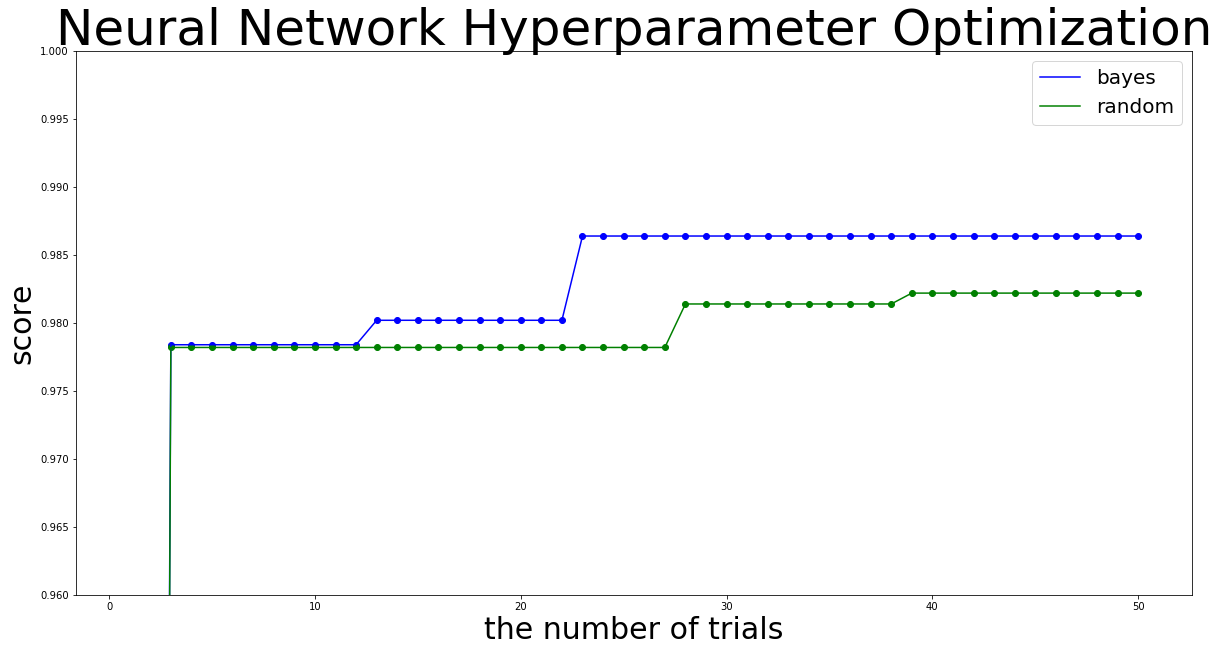

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
X = np.arange(1, len(bayes_opt.results[1]) + 1)
plt.plot(X, bayes_opt.results[1], color="b", label="bayes")
plt.plot(X, random_opt.results[1], color="g", label="random")
# plt.plot(X, grid_opt.results[1], color="y", label="grid")

plt.scatter(X, bayes_opt.results[1], color="b")
plt.scatter(X, random_opt.results[1], color="g")
# plt.scatter(X, grid_opt.results[1], color="y")

plt.xlabel("the number of trials", fontsize=30)
plt.ylabel("score", fontsize=30)
plt.title("Neural Network Hyperparameter Optimization", fontsize=50)

plt.ylim(0.96, 1.0)

plt.legend(fontsize=20)
plt.savefig("hyper_nn_opt.jpg")

# Wrap Up

As we go through in this article, Bayesian optimization is easy to implement and efficient to optimize hyperparameters of Machine Learning algorithms. If you have computer resources, I highly recommend you to parallelize processes to speed up [[10]](https://arxiv.org/pdf/1602.05149.pdf). As you have time, you can also try to use Bayesian methods to utilize gradient information [[11]](https://arxiv.org/pdf/1703.04389.pdf).

# References
- [0] [BBOptimizer](https://github.com/jjakimoto/BBOptimizer)
- [1] [Hyperparameter Optimization: A Spectral Approach](https://arxiv.org/pdf/1706.00764.pdf)
- [2] [Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization](https://arxiv.org/pdf/1603.06560.pdf)
- [3] [Population Based Training of Neural Networks](https://arxiv.org/pdf/1711.09846.pdf)
- [4] [NEURAL ARCHITECTURE SEARCH WITH REINFORCEMENT LEARNING](https://arxiv.org/pdf/1611.01578.pdf)
- [5] [ATM: A distributed, collaborative, scalable system for automated machine learning](https://cyphe.rs/static/atm.pdf)
- [6] [Efficient and Robust Automated Machine Learning](https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf)
- [7] [Gradient-based Hyperparameter Optimization through Reversible Learning](http://proceedings.mlr.press/v37/maclaurin15.pdf)
- [8] [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
- [9] [PRACTICAL BAYESIAN OPTIMIZATION OF MACHINE LEARNING ALGORITHMS](https://arxiv.org/pdf/1206.2944.pdf)
- [10] [Parallel Bayesian Global Optimization of Expensive Functions](https://arxiv.org/pdf/1602.05149.pdf)
- [11] [Bayesian Optimization with Gradients](https://arxiv.org/pdf/1703.04389.pdf)